# Introduction and Scope

The S&P 500 stock market index was created in 1957, and it's a collection of US equities used to track the performance of the broader American equity market. Today, this index tracks the performance of 505 common stocks issued by 500 of the largest firms in the US by market capitalisation, and the index accounts for roughly 80% of the US equity market in terms of market cap. 

The S&P 500 index has changed over time as different public companies have been added to or removed from the index as a result of their growth or decline. Companies have also been removed from the index due to other reasons such as being taken private by private equity firms or because of mergers and acquisitions. For simplicity, the project will only use price data on extant constituents of the S&P 500 and will not consider companies who used to be part of the S&P 500. 

The goal of this project is to use a long short-term memory (LSTM) network to generate buy and sell signals for stock that is part of the S&P 500 index. To achieve this, the neural network will be trained on the daily stock price data of the constituents of the S&P500 index from 03/01/2001 to 15/10/2021. In this kernel, the stock that signals will be generated for is Apple.

# Import packages and set up file directory

In [71]:
import os
import pandas_datareader.data as web # for obtaining stock data from Yahoo Finance
import datetime as dt
import numpy as np
import pandas as pd
import random
from collections import deque
from sklearn import preprocessing
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

# Configuring chart settings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
style.use('seaborn') ## ggplot

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Getting the S&P 500 Data

This is the code that I used to obtain the stock price data for all the stocks in the S&P 500 index.

In [10]:
def get_sp500_tickers():
    """
    Returns a data frame of the S&P 500 tickers from the 
    Wikipedia on the S&P 500 Index
    
    Also saves a pickle file of the tickers for future use
    """
    tickers = pd.read_html(
        'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol']
    
    with open('sp500_tickers','wb') as f:
        pickle.dump(tickers,f)  
    return tickers 

In [11]:
def get_sp500_data(reload_sp500 = False):
    """
    Creates a directory called "stocks_dfs" and stores the price 
    data of all the stocks in the S&P 500 index in that folder
    
    Price data on each company is from 03/01/2001 - 15/10/2021
    """
    tickers = []
    if reload_sp500==True:
        tickers = get_sp500_tickers()
    else:
        with open('sp500_tickers','rb') as f:
            tickers = pickle.load(f)
    
    for i in range(len(tickers)):
        tickers[i] = tickers[i].replace('.', '-')
    
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
    
    start = dt.datetime(2000,1,1) # 12/31/1999
    end = dt.datetime.now() # Get up to the most recent time 

    for ticker in tickers:
        if not os.path.exists(f'stock_dfs/{ticker}.csv'):
            df = web.DataReader(ticker,'yahoo',start,end)
            df.to_csv(f'stock_dfs/{ticker}.csv') 
        else:
            print(f'Already have {ticker}')

In [12]:
def compile_data():
    with open('sp500_tickers','rb') as f:
        tickers = pickle.load(f)
    
    for i in range(len(tickers)):
        tickers[i] = tickers[i].replace('.', '-')
    
    main_df = pd.DataFrame()
    
    for count, ticker in enumerate(tickers):
        df = pd.read_csv(f'stock_dfs/{ticker}.csv')
        df.set_index('Date',inplace=True)
        df.rename(columns = {'Adj Close':f'{ticker}_close',
                            'Open':f'{ticker}_open',
                            'High':f'{ticker}_high',
                            'Low':f'{ticker}_low',
                            'Volume':f'{ticker}_volume'},
                  inplace = True)
        df.drop(['Close'],axis=1,inplace = True)
        
        if main_df.empty:
            main_df = df
        else:
            main_df = pd.concat([main_df,df],axis =1)
            
        if count % 100 == 0:
            print(count)
            
    main_df.to_csv('sp500_data.csv')

Although I couldn't get these functions to work on Kaggle (because I couldn't find a way to access the output directory), 

```
get_sp500_data(reload_sp500 = True)
compile_data()
```

the functions do work my local device, so please run this code locally to get the data on the S&P 500's constituents' stock prices. Once you download the data, then upload it to this notebook and continue reading!

# Exploring the Data

In [278]:
sp500 = pd.read_csv('sp500_data.csv',index_col = 0)

In [279]:
sp500.index = pd.to_datetime(sp500.index)

In [280]:
# daily stock data on sp500 companies from 31/12/1999 - 23/8/2021
sp500.head(1)

MMM_high   MMM_low  MMM_open  MMM_close  MMM_volume  \
2000-01-03     48.25  47.03125  48.03125    47.1875   2173400.0   

            MMM_adj_close   ABT_high    ABT_low   ABT_open  ABT_close  ...  \
2000-01-03      27.179523  16.160433  15.599306  15.823756  15.711531  ...   

            ZION_open  ZION_close  ZION_volume  ZION_adj_close  ZTS_high  \
2000-01-03   59.03125        55.5    1199600.0        39.50034       NaN   

            ZTS_low  ZTS_open  ZTS_close  ZTS_volume  ZTS_adj_close  
2000-01-03      NaN       NaN        NaN         NaN            NaN  

[1 rows x 3030 columns]

In [281]:
sp500.tail(1)

MMM_high     MMM_low    MMM_open   MMM_close  MMM_volume  \
2021-10-15     183.0  180.679993  180.690002  181.940002   2160800.0   

            MMM_adj_close    ABT_high     ABT_low    ABT_open   ABT_close  \
2021-10-15     181.940002  118.330002  117.129997  118.080002  117.489998   

            ...  ZION_open  ZION_close  ZION_volume  ZION_adj_close  \
2021-10-15  ...      63.43   62.139999    1473800.0       62.139999   

              ZTS_high     ZTS_low    ZTS_open   ZTS_close  ZTS_volume  \
2021-10-15  202.800003  200.119995  201.130005  202.220001   1235800.0   

            ZTS_adj_close  
2021-10-15     202.220001  

[1 rows x 3030 columns]

In [282]:
sp500.shape

(5483, 3030)

### Removing the "close" columns from the data and keeping "adjusted close" prices

Remove the "close" columns from the dataframe and keep only the adjusted closes, which account for price adjustments after corporate actions (like stock splits)

In [283]:
# remove the close column
def remove_close(df):
    df = df[(col for col in df.columns if 'high' in col or 'low' in col or 'open' in col or 'volume' in col or 'adj_close' in col)]
    return df

In [284]:
sp500 = remove_close(sp500)

# there should be 505 fewer columns
sp500.shape

(5483, 2525)

### Adding each stock's intraday spread to our data
- intraday spread is defined as: $P_{high} - P_{low}$

In [285]:
def add_intraday_spread(df):
    high_cols = sorted([col for col in df.columns if 'high' in col])
    low_cols = sorted([col for col in df.columns if 'low' in col])
    for i in range(len(high_cols)):
        df[f"{high_cols[i].split('_')[0]}_intraday_spread"] = df[high_cols[i]] - df[low_cols[i]]
    return df

In [286]:
sp500 = add_intraday_spread(sp500)

# now we'll have 3030 columns again
sp500.shape 

(5483, 3030)

## Data visualisation

### Apple's adjusted closing price and trading volume

In [287]:
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams["figure.figsize"] = [20,8]
font = {'family': 'serif',
        'weight': 'normal',
        'size': 18}
mpl.rc('font', **font)

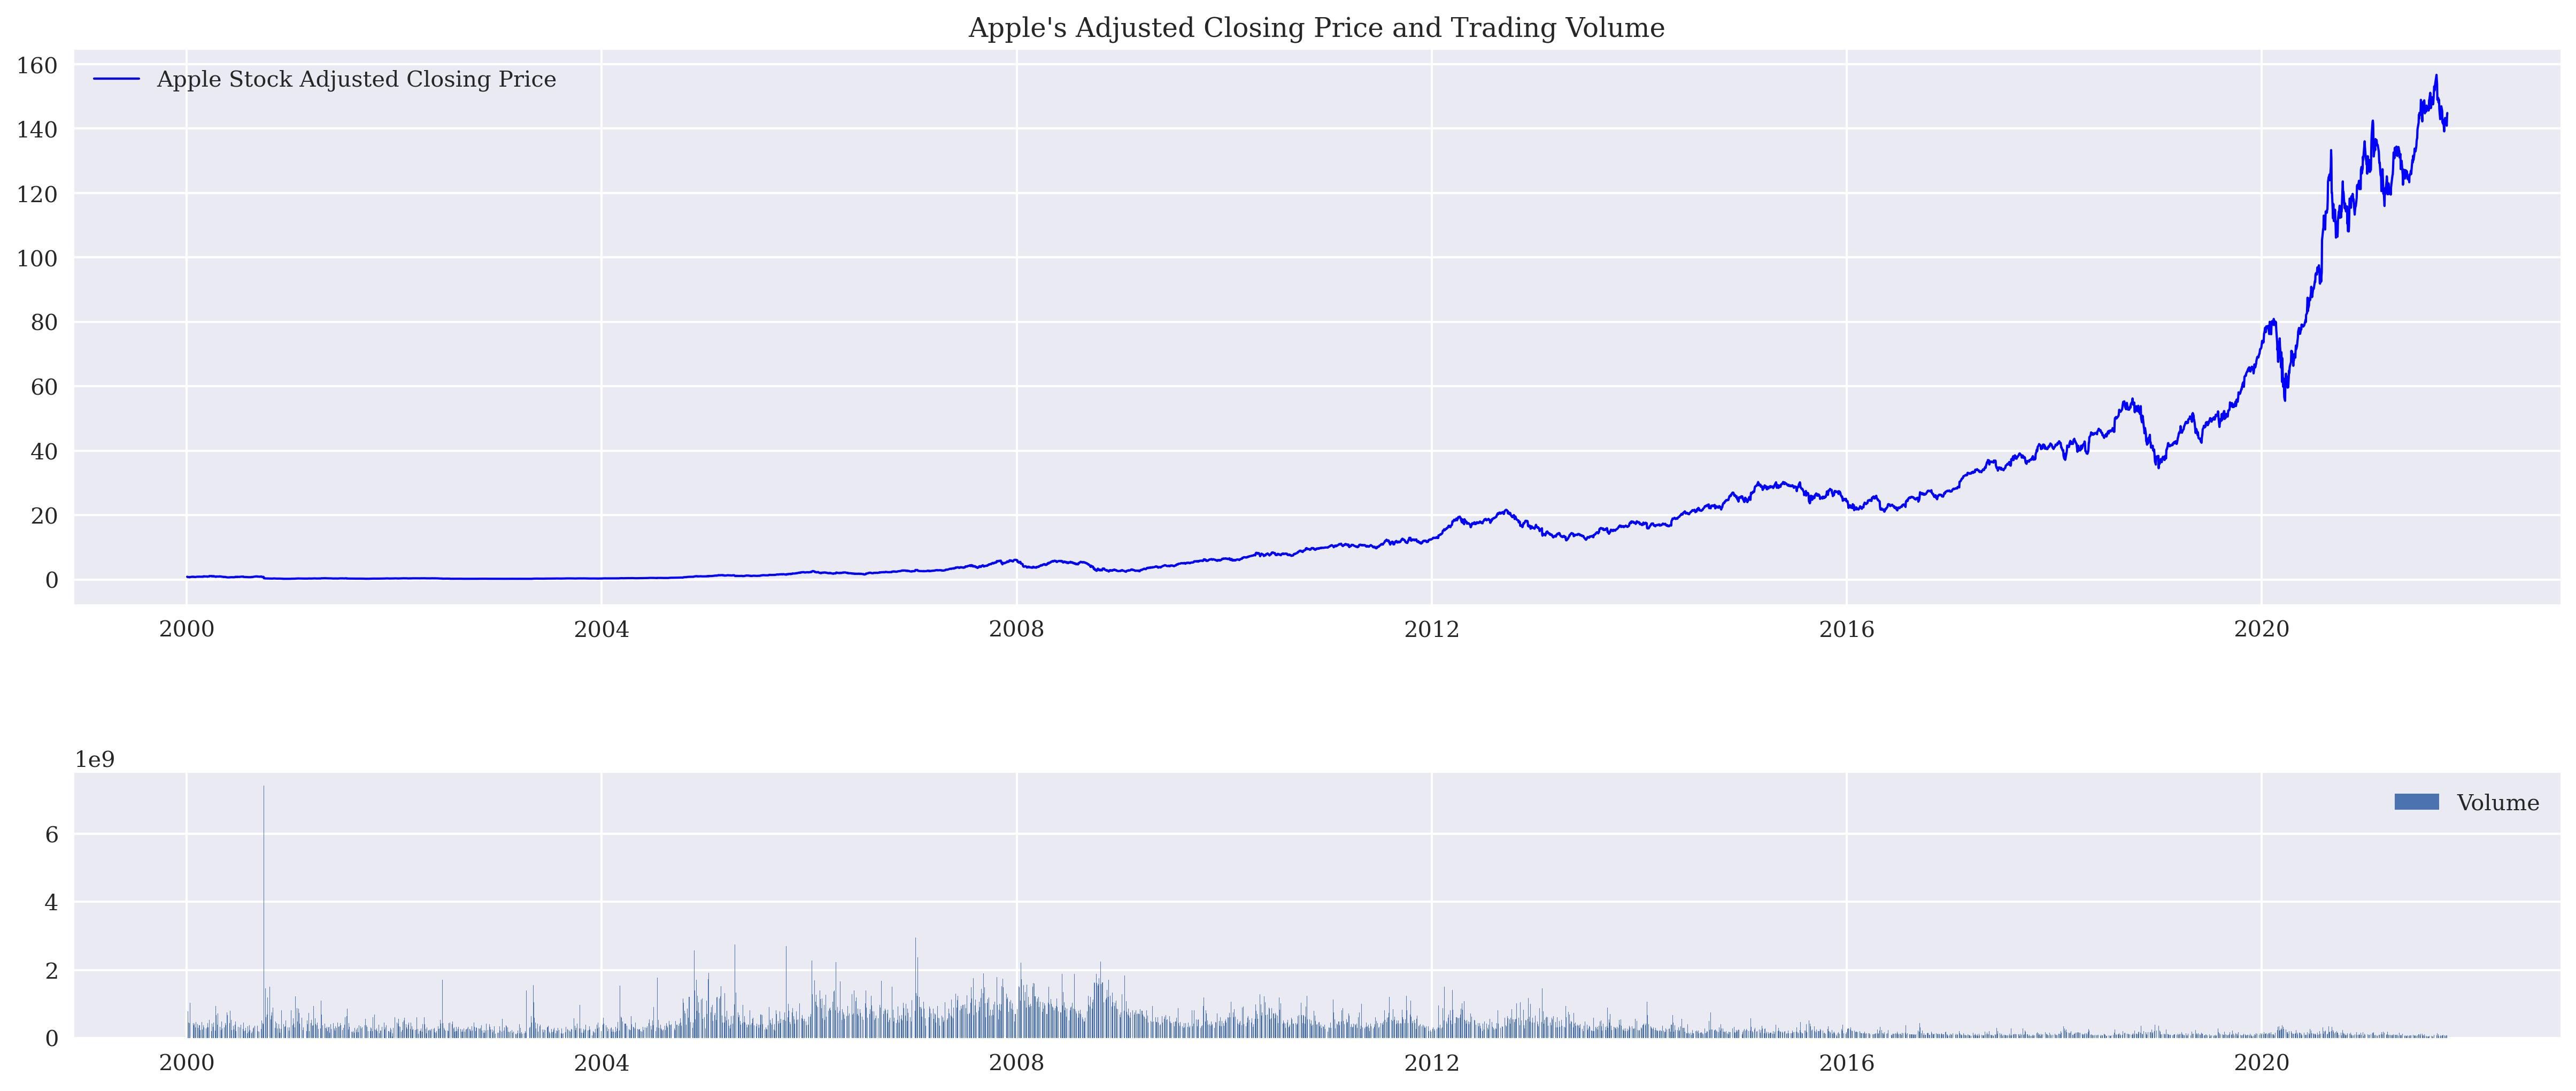

In [288]:
ax1 = plt.subplot2grid((7,1),(0,0),rowspan = 4,colspan = 1)
ax2 = plt.subplot2grid((7,1),(5,0),rowspan = 3,colspan = 1)

# Plot 1
ax1.plot(sp500.index,sp500['AAPL_adj_close'],color = 'blue',linewidth=1)
ax1.title.set_text("Apple's Adjusted Closing Price and Trading Volume")
ax1.legend(['Apple Stock Adjusted Closing Price'])

# Plot 2
ax2.bar(sp500.index,sp500['AAPL_volume'])
ax2.legend(['Volume'])

In [289]:
sp500.head(2)

MMM_high   MMM_low  MMM_open  MMM_volume  MMM_adj_close  \
2000-01-03  48.25000  47.03125  48.03125   2173400.0      27.179523   
2000-01-04  47.40625  45.31250  46.43750   2713800.0      26.099533   

             ABT_high    ABT_low   ABT_open  ABT_volume  ABT_adj_close  ...  \
2000-01-03  16.160433  15.599306  15.823756  10635087.0       9.418211  ...   
2000-01-04  15.599306  15.150405  15.459024  10734887.0       9.149117  ...   

            XEL_intraday_spread  XLNX_intraday_spread  XOM_intraday_spread  \
2000-01-03               0.6875                2.9375              1.43750   
2000-01-04               0.5000                3.1250              0.84375   

            XRAY_intraday_spread  XYL_intraday_spread  YUM_intraday_spread  \
2000-01-03              0.229167                  NaN             0.269590   
2000-01-04              0.125000                  NaN             0.269591   

            ZBH_intraday_spread  ZBRA_intraday_spread  ZION_intraday_spread  \
2000-01-03                  NaN              1.222221                5.6875   
2000-01-04                  NaN              2.166668                2.5000   

            ZTS_intraday_spread  
2000-01-03                  NaN  
2000-01-04                  NaN  

[2 rows x 3030 columns]

In [290]:
sp500.shape

(5483, 3030)

### Plotting the Autocorrelation and Partial Autocorrelation of 3 Stocks' Adjusted Closing Price

In [291]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

def tsplot(y,title,lags=None,figsize=(12,8)):
    """
    Examine the patterns of ACF and PACF as well as the time series plot and histogram of the variable
    """
    fig = plt.figure(figsize=figsize)
    layout = (2,2)
    
    ts_ax = plt.subplot2grid(layout, (0,0))
    hist_ax = plt.subplot2grid(layout, (0,1))
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title,fontsize=14,weight='bold')
    y.plot(ax=hist_ax,kind='hist',bins = 25,)
    hist_ax.set_title('Histogram')
    plot_acf(y,lags = lags, ax=acf_ax)
    plot_pacf(y,lags = lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax,pacf_ax]]
    sns.despine()
    plt.tight_layout()
    
    return ts_ax,acf_ax,pacf_ax
    

(<AxesSubplot:title={'center':'Apple Adjusted Closing Price'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

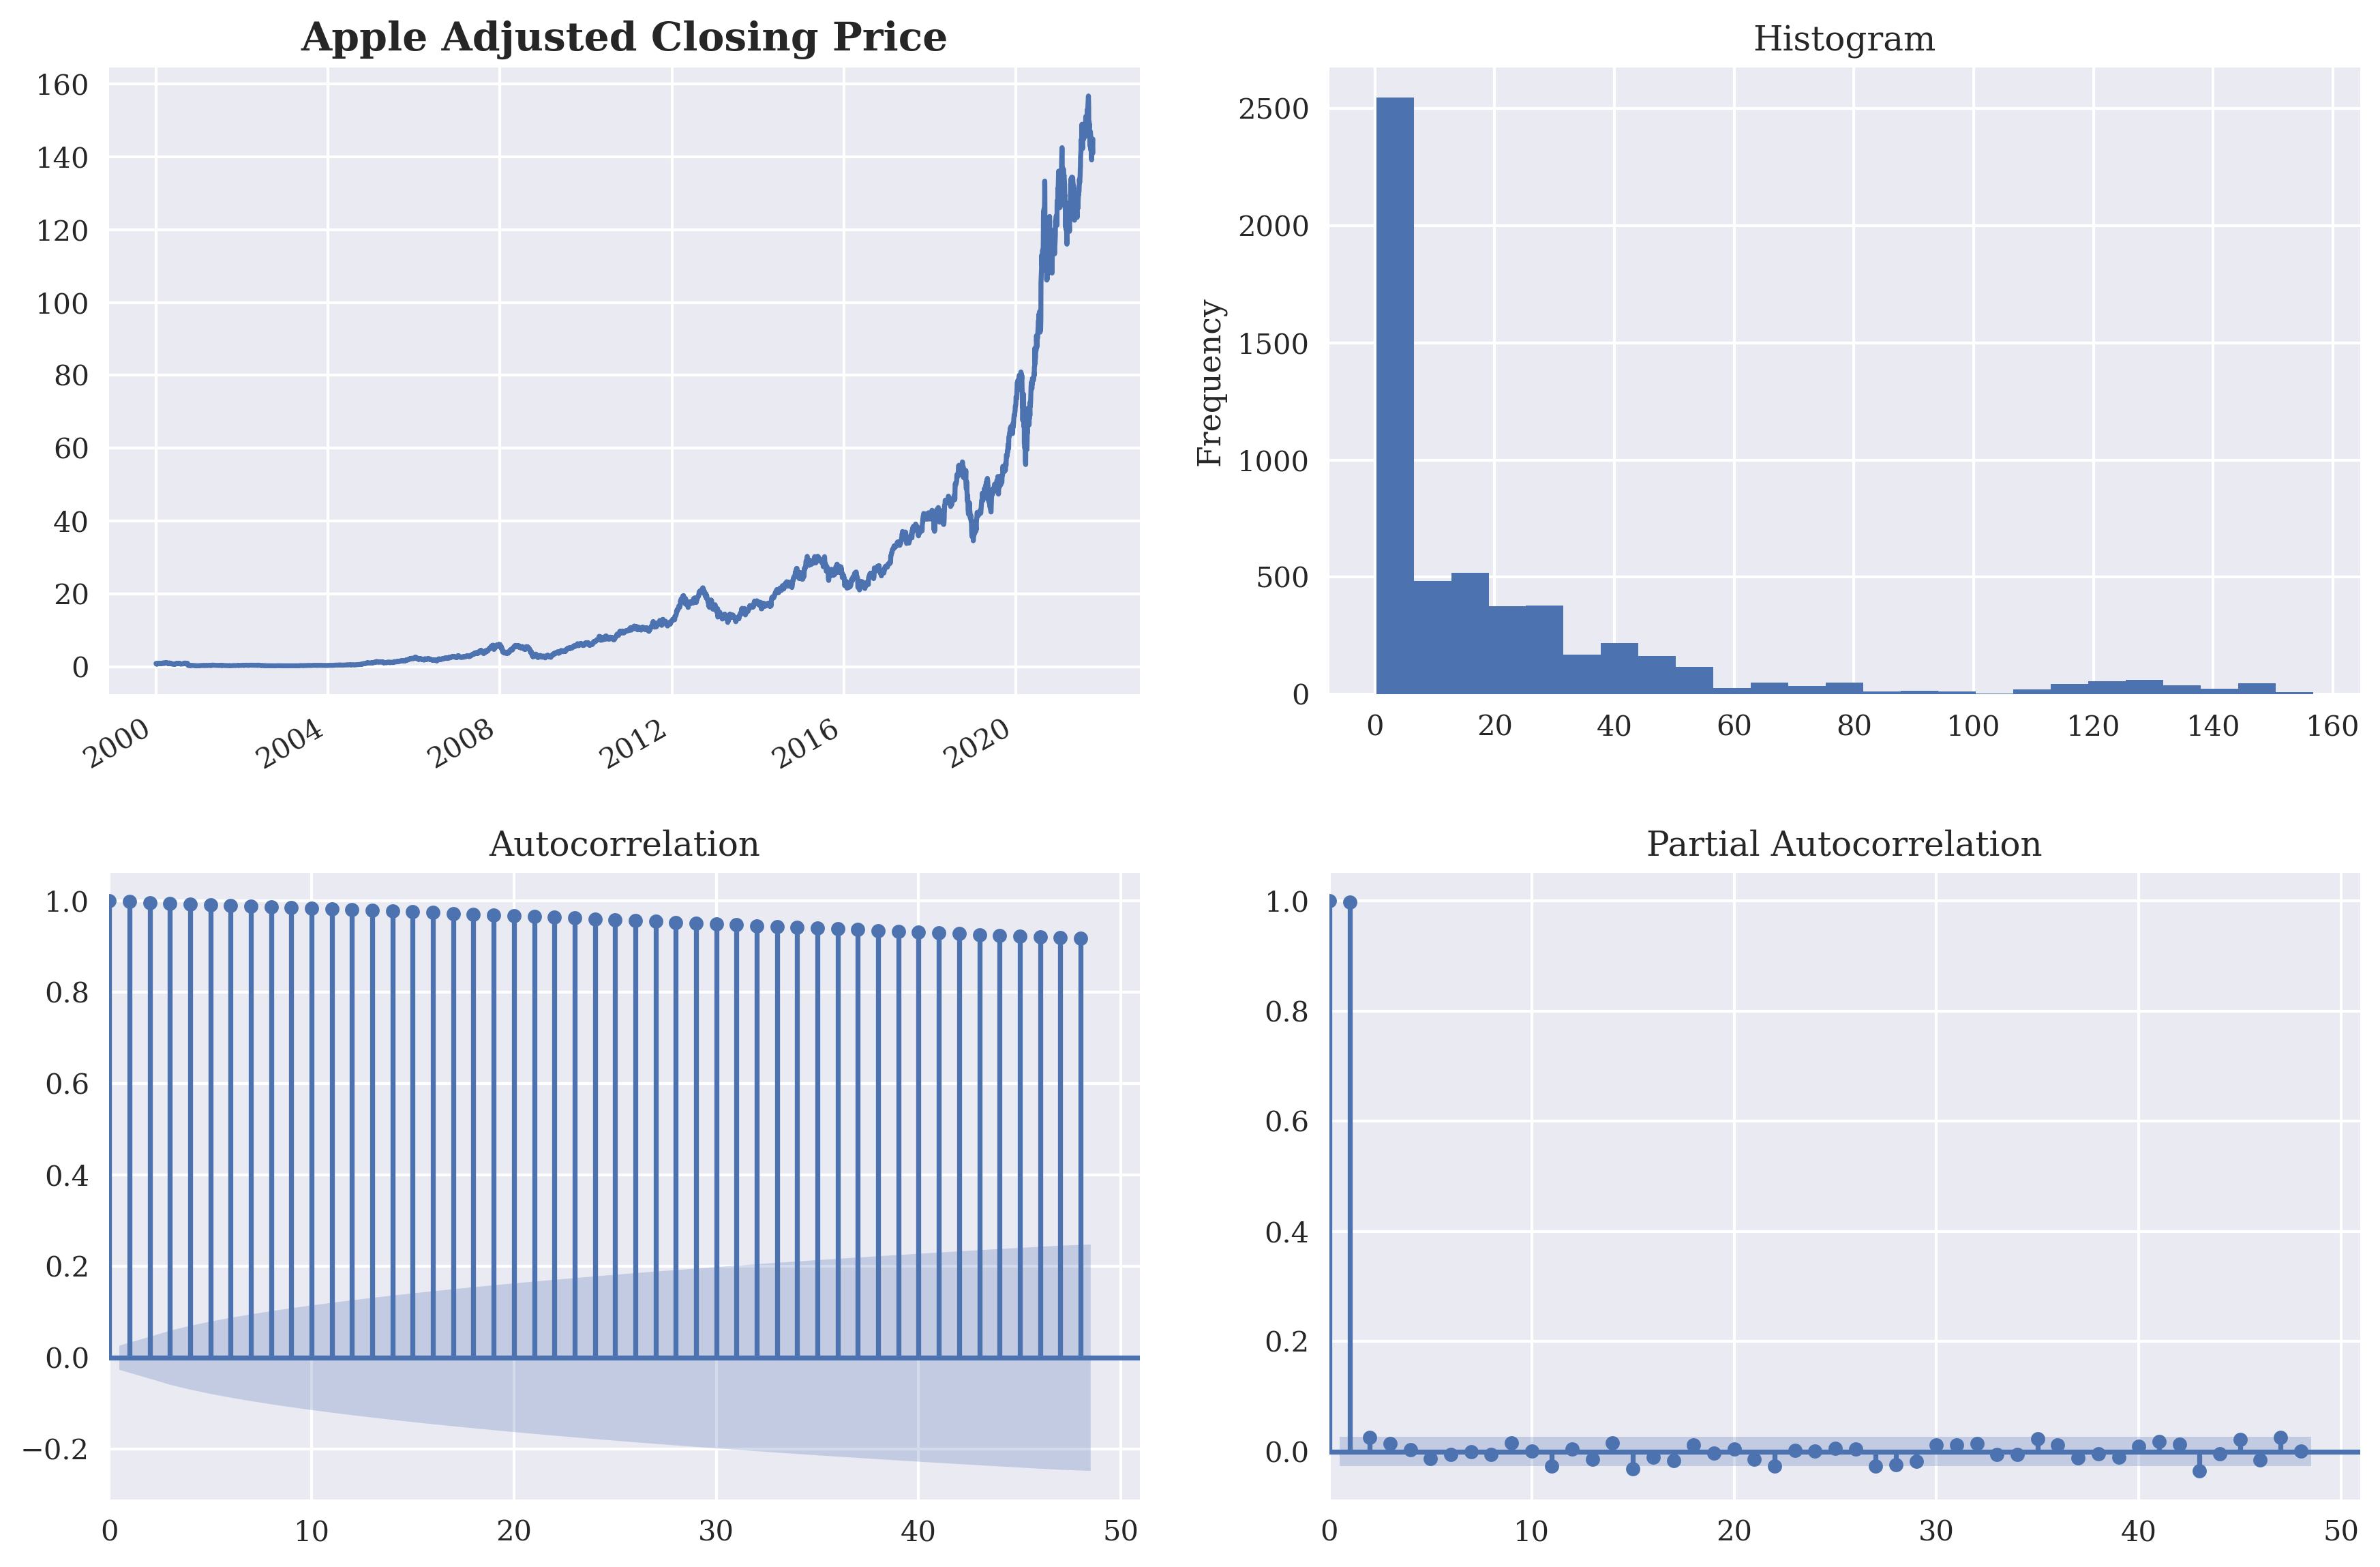

In [292]:
tsplot(sp500['AAPL_adj_close'].dropna(),title = 'Apple Adjusted Closing Price',lags = 48)

(<AxesSubplot:title={'center':'MMM Adjusted Closing Price'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

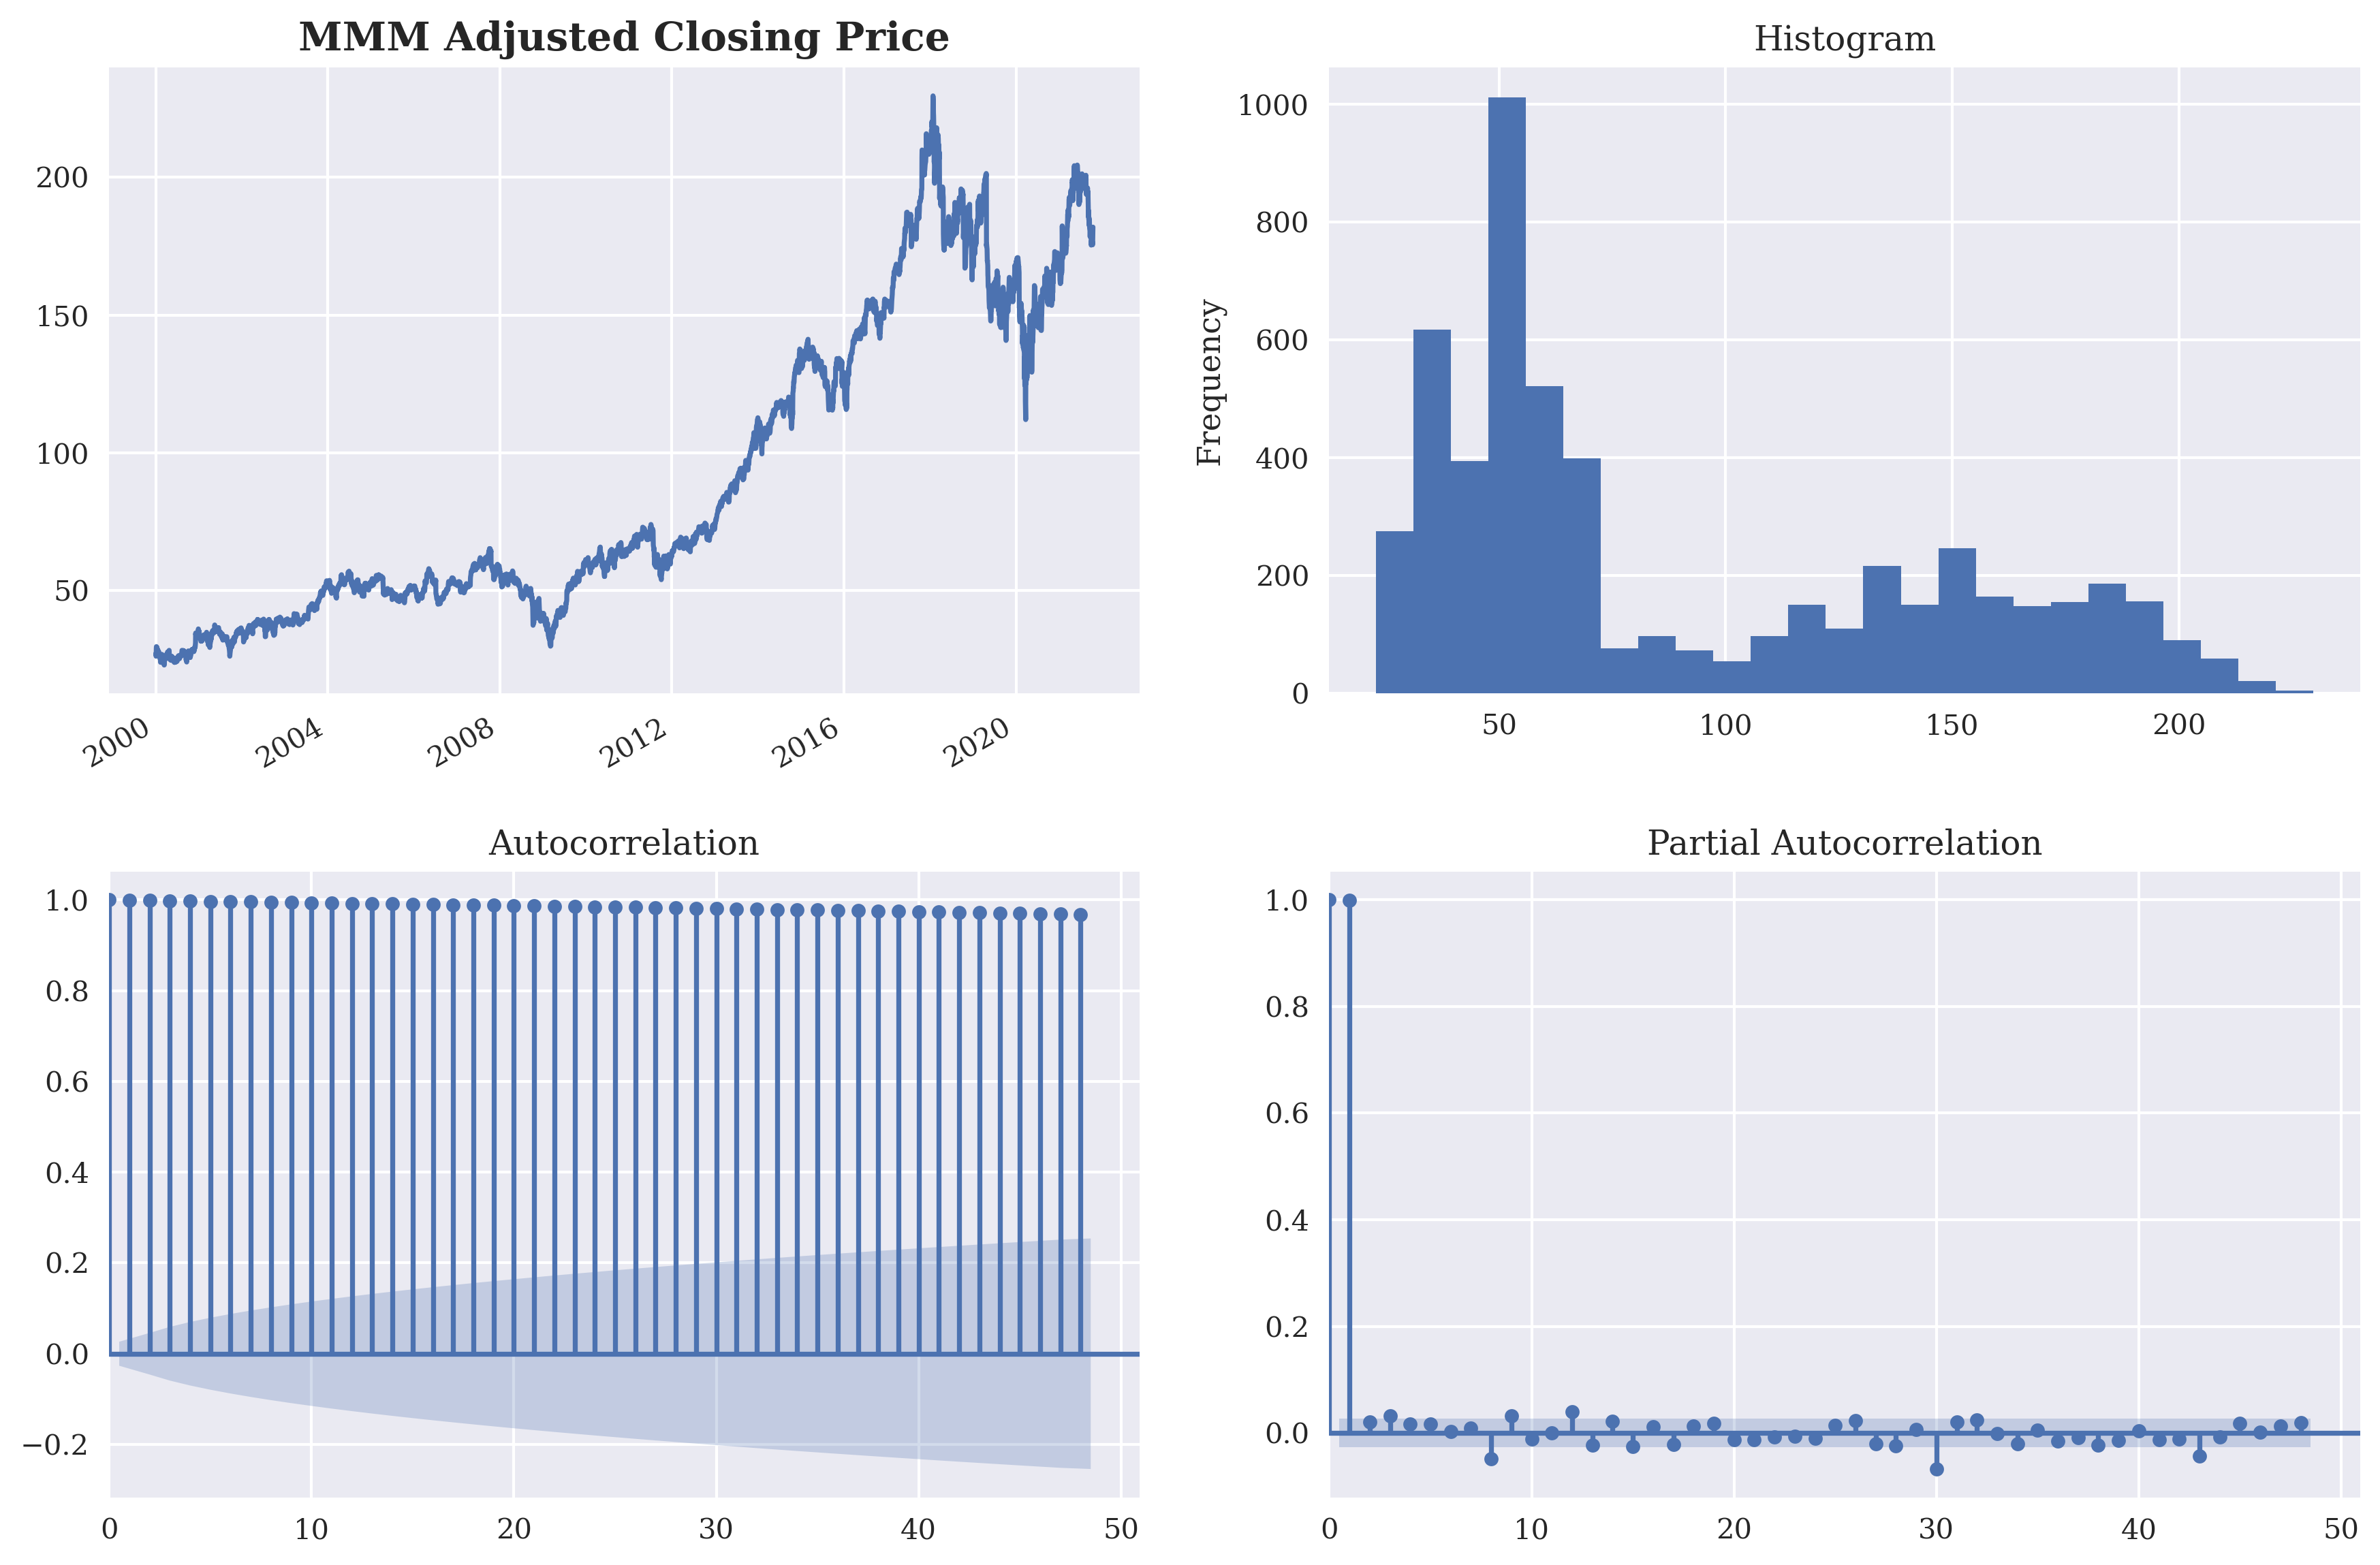

In [293]:
tsplot(sp500['MMM_adj_close'].dropna(),title = 'MMM Adjusted Closing Price',lags = 48)

(<AxesSubplot:title={'center':'Berkshire Hathaway Inc. Adjusted Closing Price'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

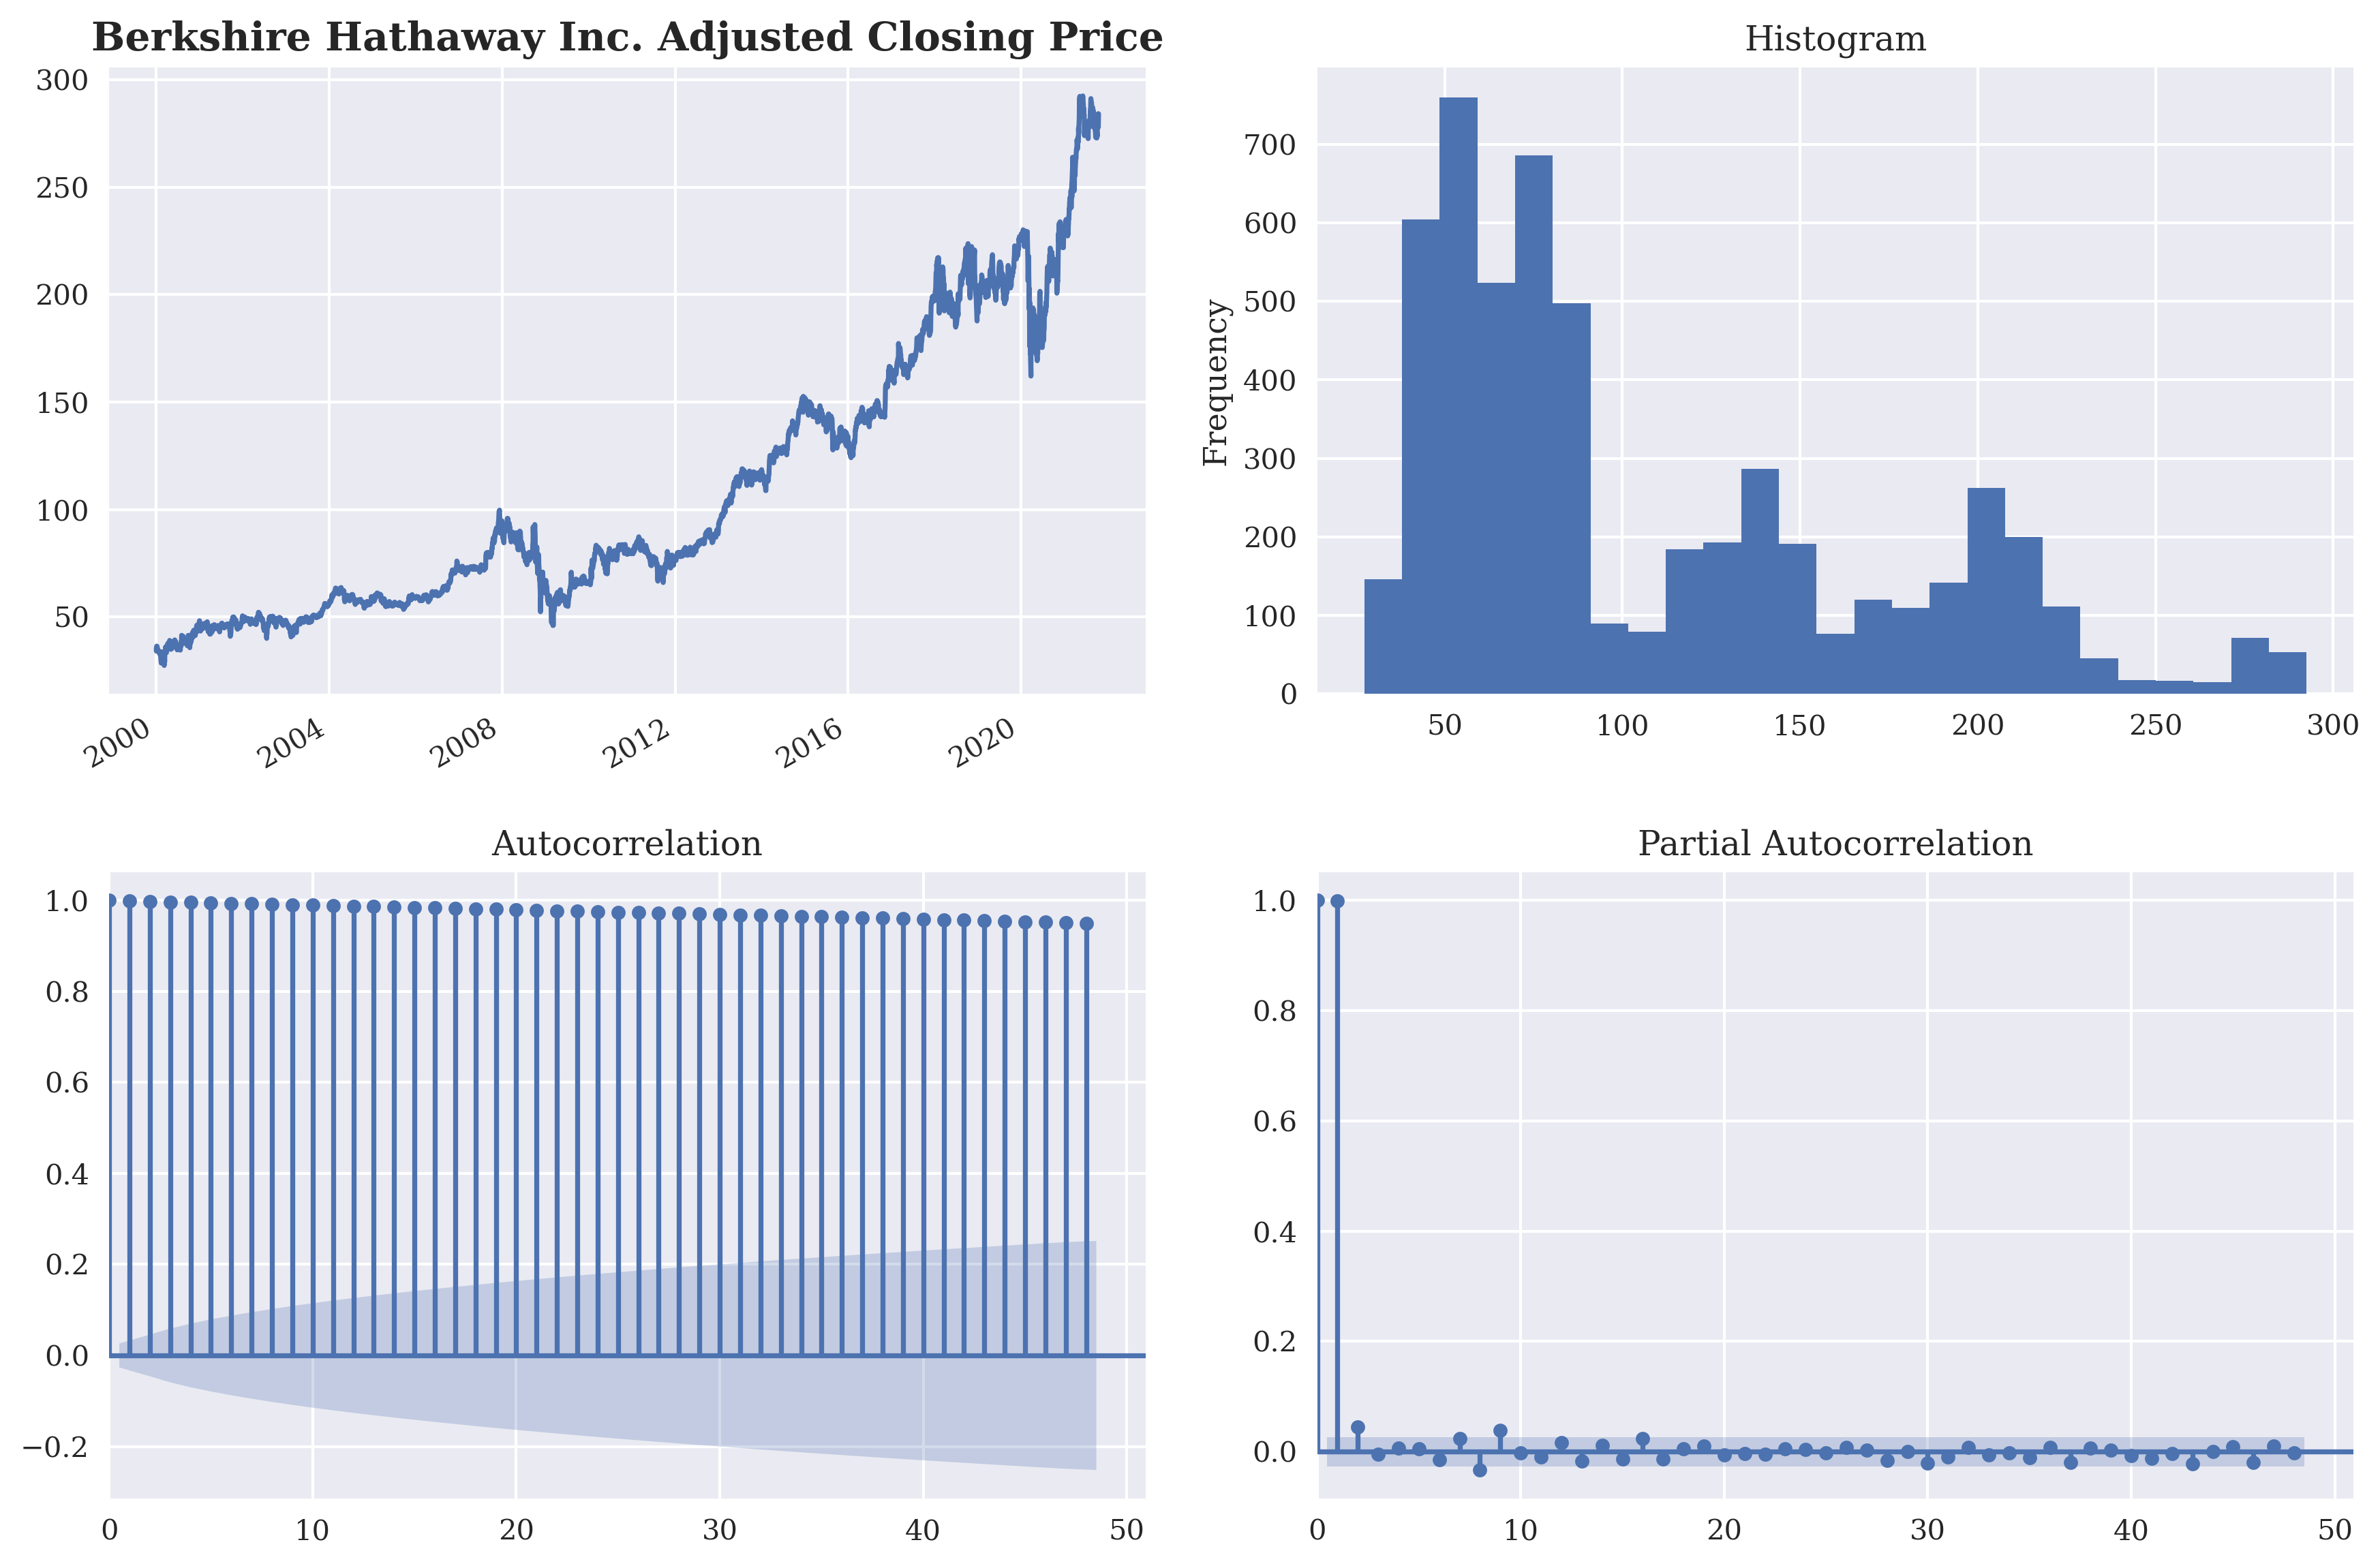

In [294]:
tsplot(sp500['BRK-B_adj_close'].dropna(),title = 'Berkshire Hathaway Inc. Adjusted Closing Price',lags = 48)

The adjusted closing prices of these stocks exhibit autocorrelation and they are non-stationary. To make this data stationary, we can compute the log returns of each company's adjusted close price.

Although stationarity is not required to properly train a LSTM network, it may make the model's predictions more accurate. Therefore, we'll add the returns data to our dataset. 

In addition to this motivation, we could compare the LSTM's performance on different datasets. More specifically, we may want to compare the LSTM's performance on 3 different datasets: 
1. one that includes the adjusted close data and no returns data 
2. one that includes the returns data and no adjusted close data

*For the purpose of this notebook, **stationarity** is defined in terms of its **weak definition**, which implies that a time series has a time independent mean and variance, and that the autocovariance between two observations depends only on the size of the time displacement between the two observations. In other words, for a stationary time series, the autocovariance between observations at time $t = 2$ and $t = 3$ should be the same as the autocovariance between the observations at time $t = 4$ and $t = 5$.*

### Making Adjusted Close Stationary: add each stock's log returns to our data
- Log returns computed as: $log(P_{t+1} / P_{t})$
    - $P_t$ = adjusted close price at time $t$

In [295]:
# add returns columns for all the stocks
for col in sp500.columns:
    if 'adj_close' in col:
        sp500[f"{col.split('_')[0]}_returns"] = np.log(sp500[col].div(sp500[col].shift(1)))

### Plotting the Autocorrelation and Partial Autocorrelation of 3 Stocks' Returns

(<AxesSubplot:title={'center':'Apple Stock Returns'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

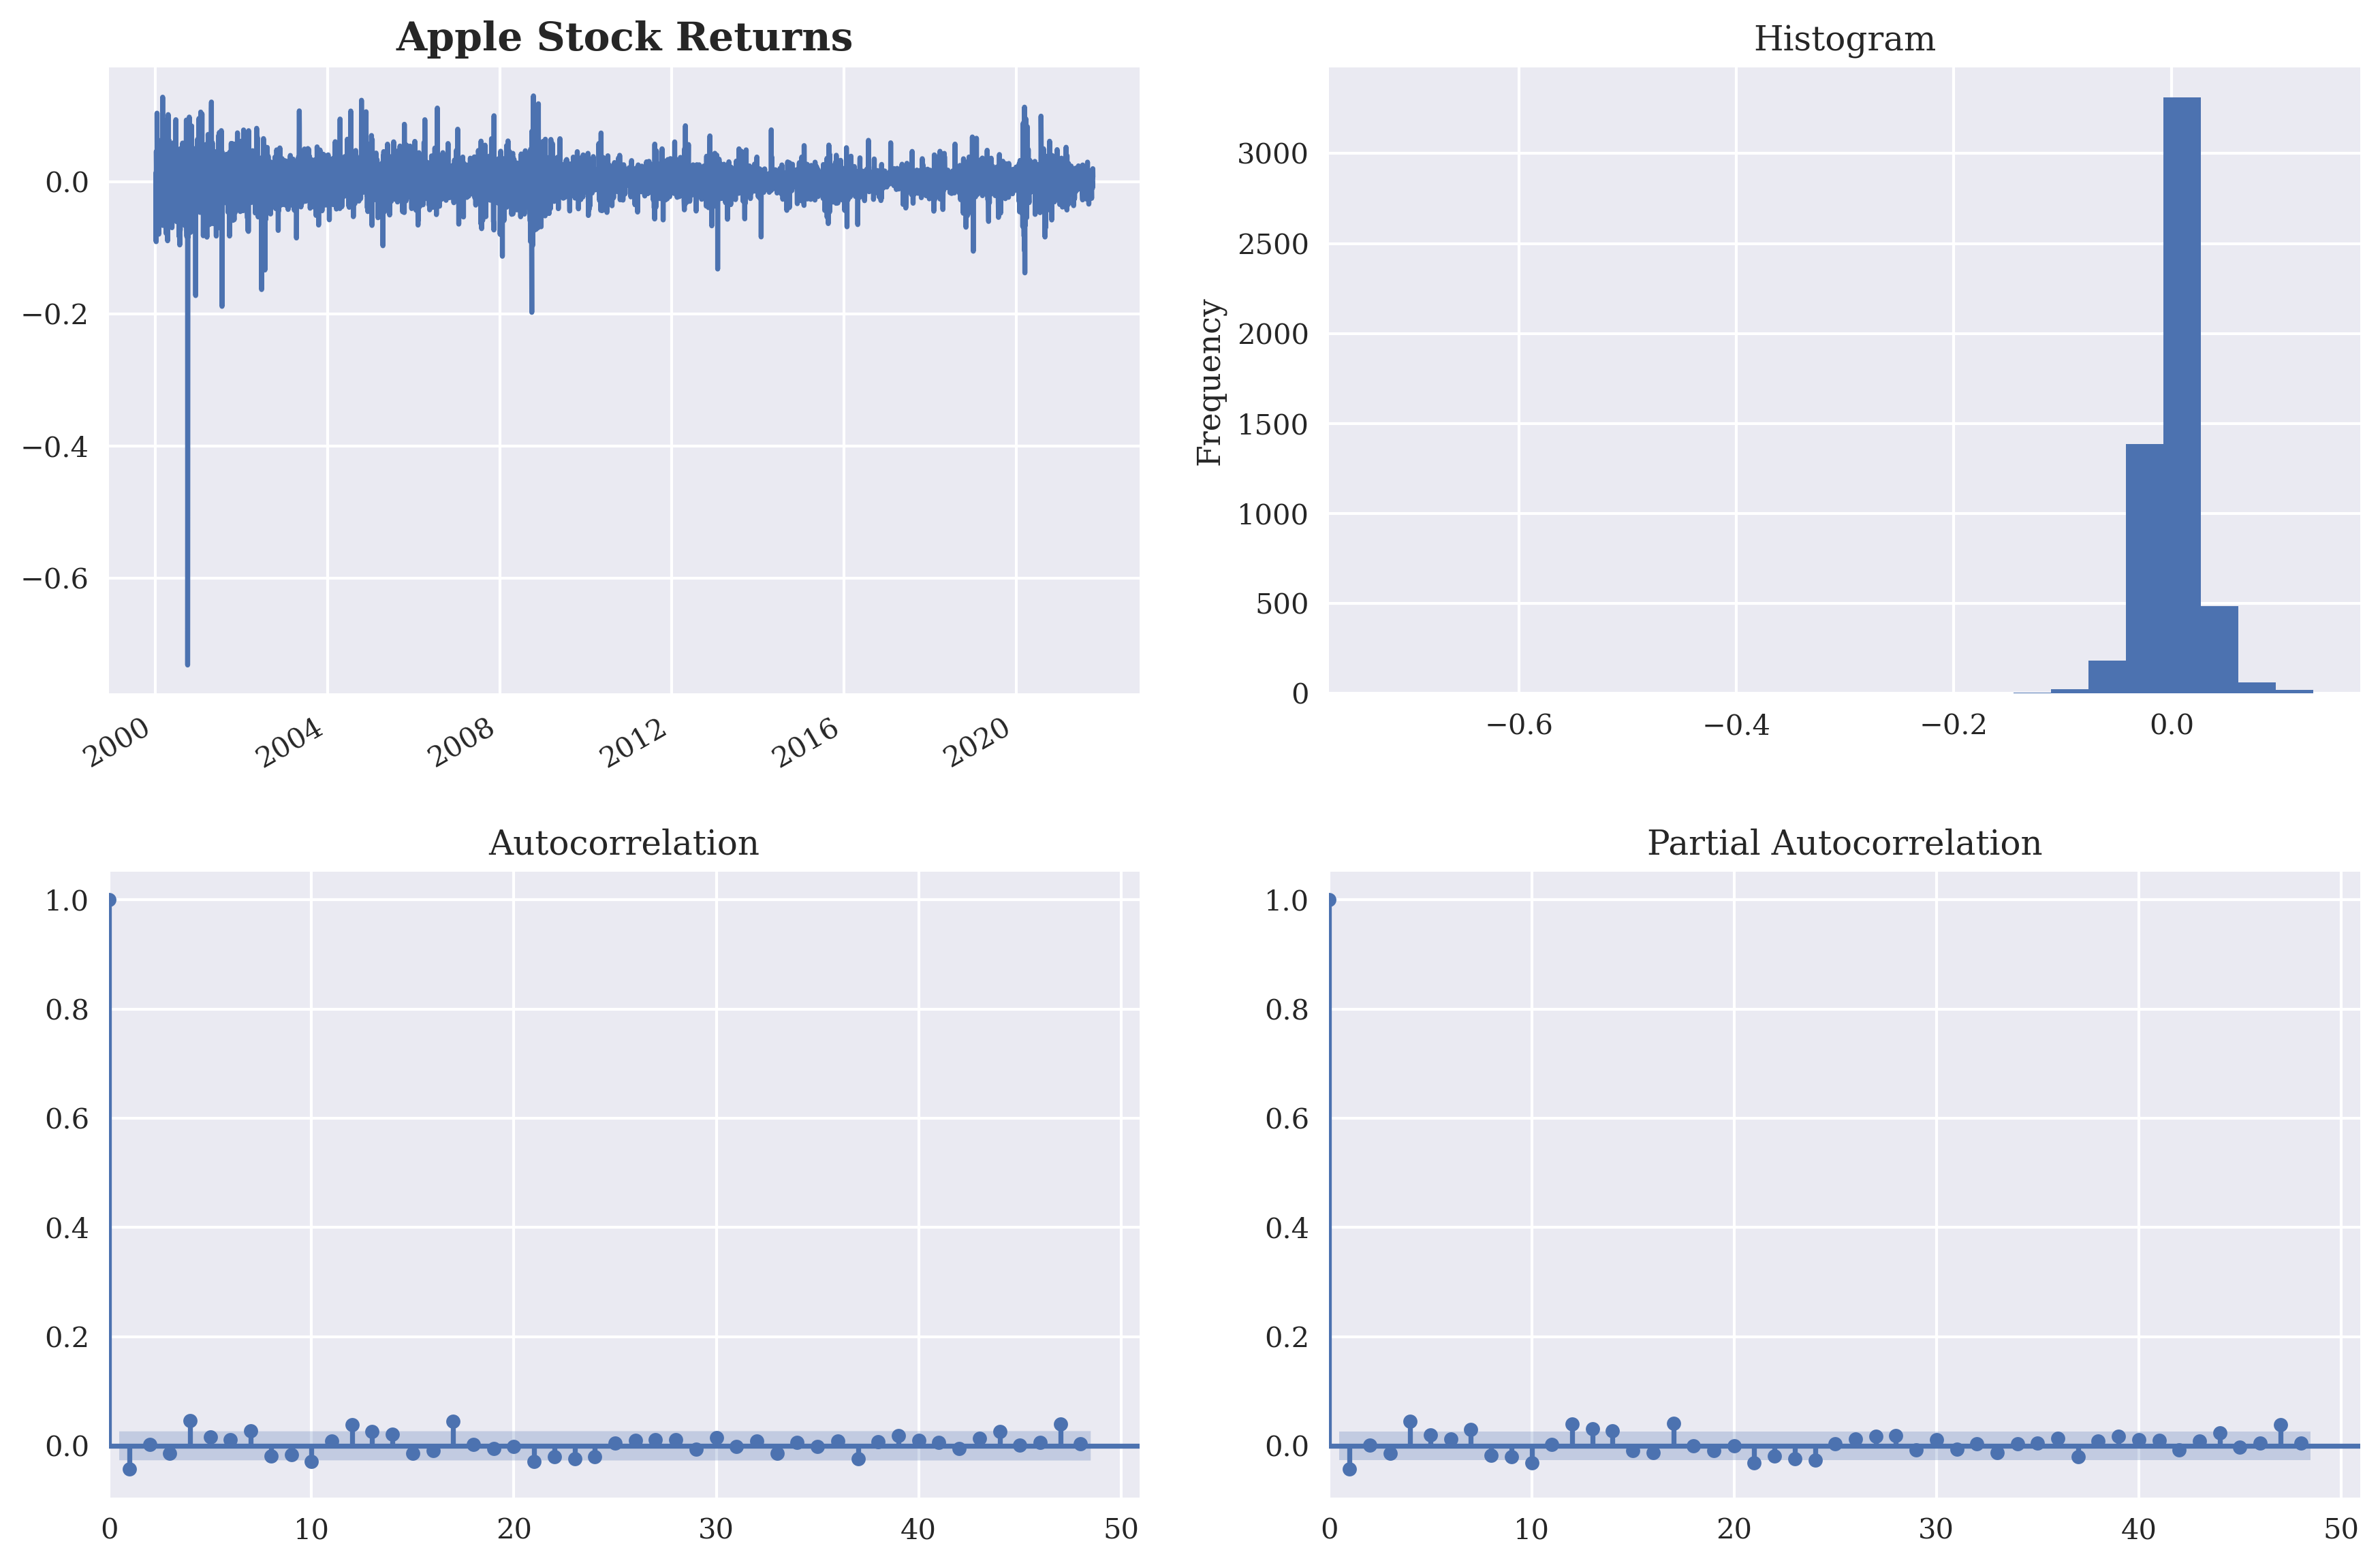

In [296]:
# outlier in the returns between 2000 and 2002 due to internet bubble bursting
tsplot(sp500['AAPL_returns'].dropna(),title = "Apple Stock Returns",lags = 48)

(<AxesSubplot:title={'center':'3M Stock Returns'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

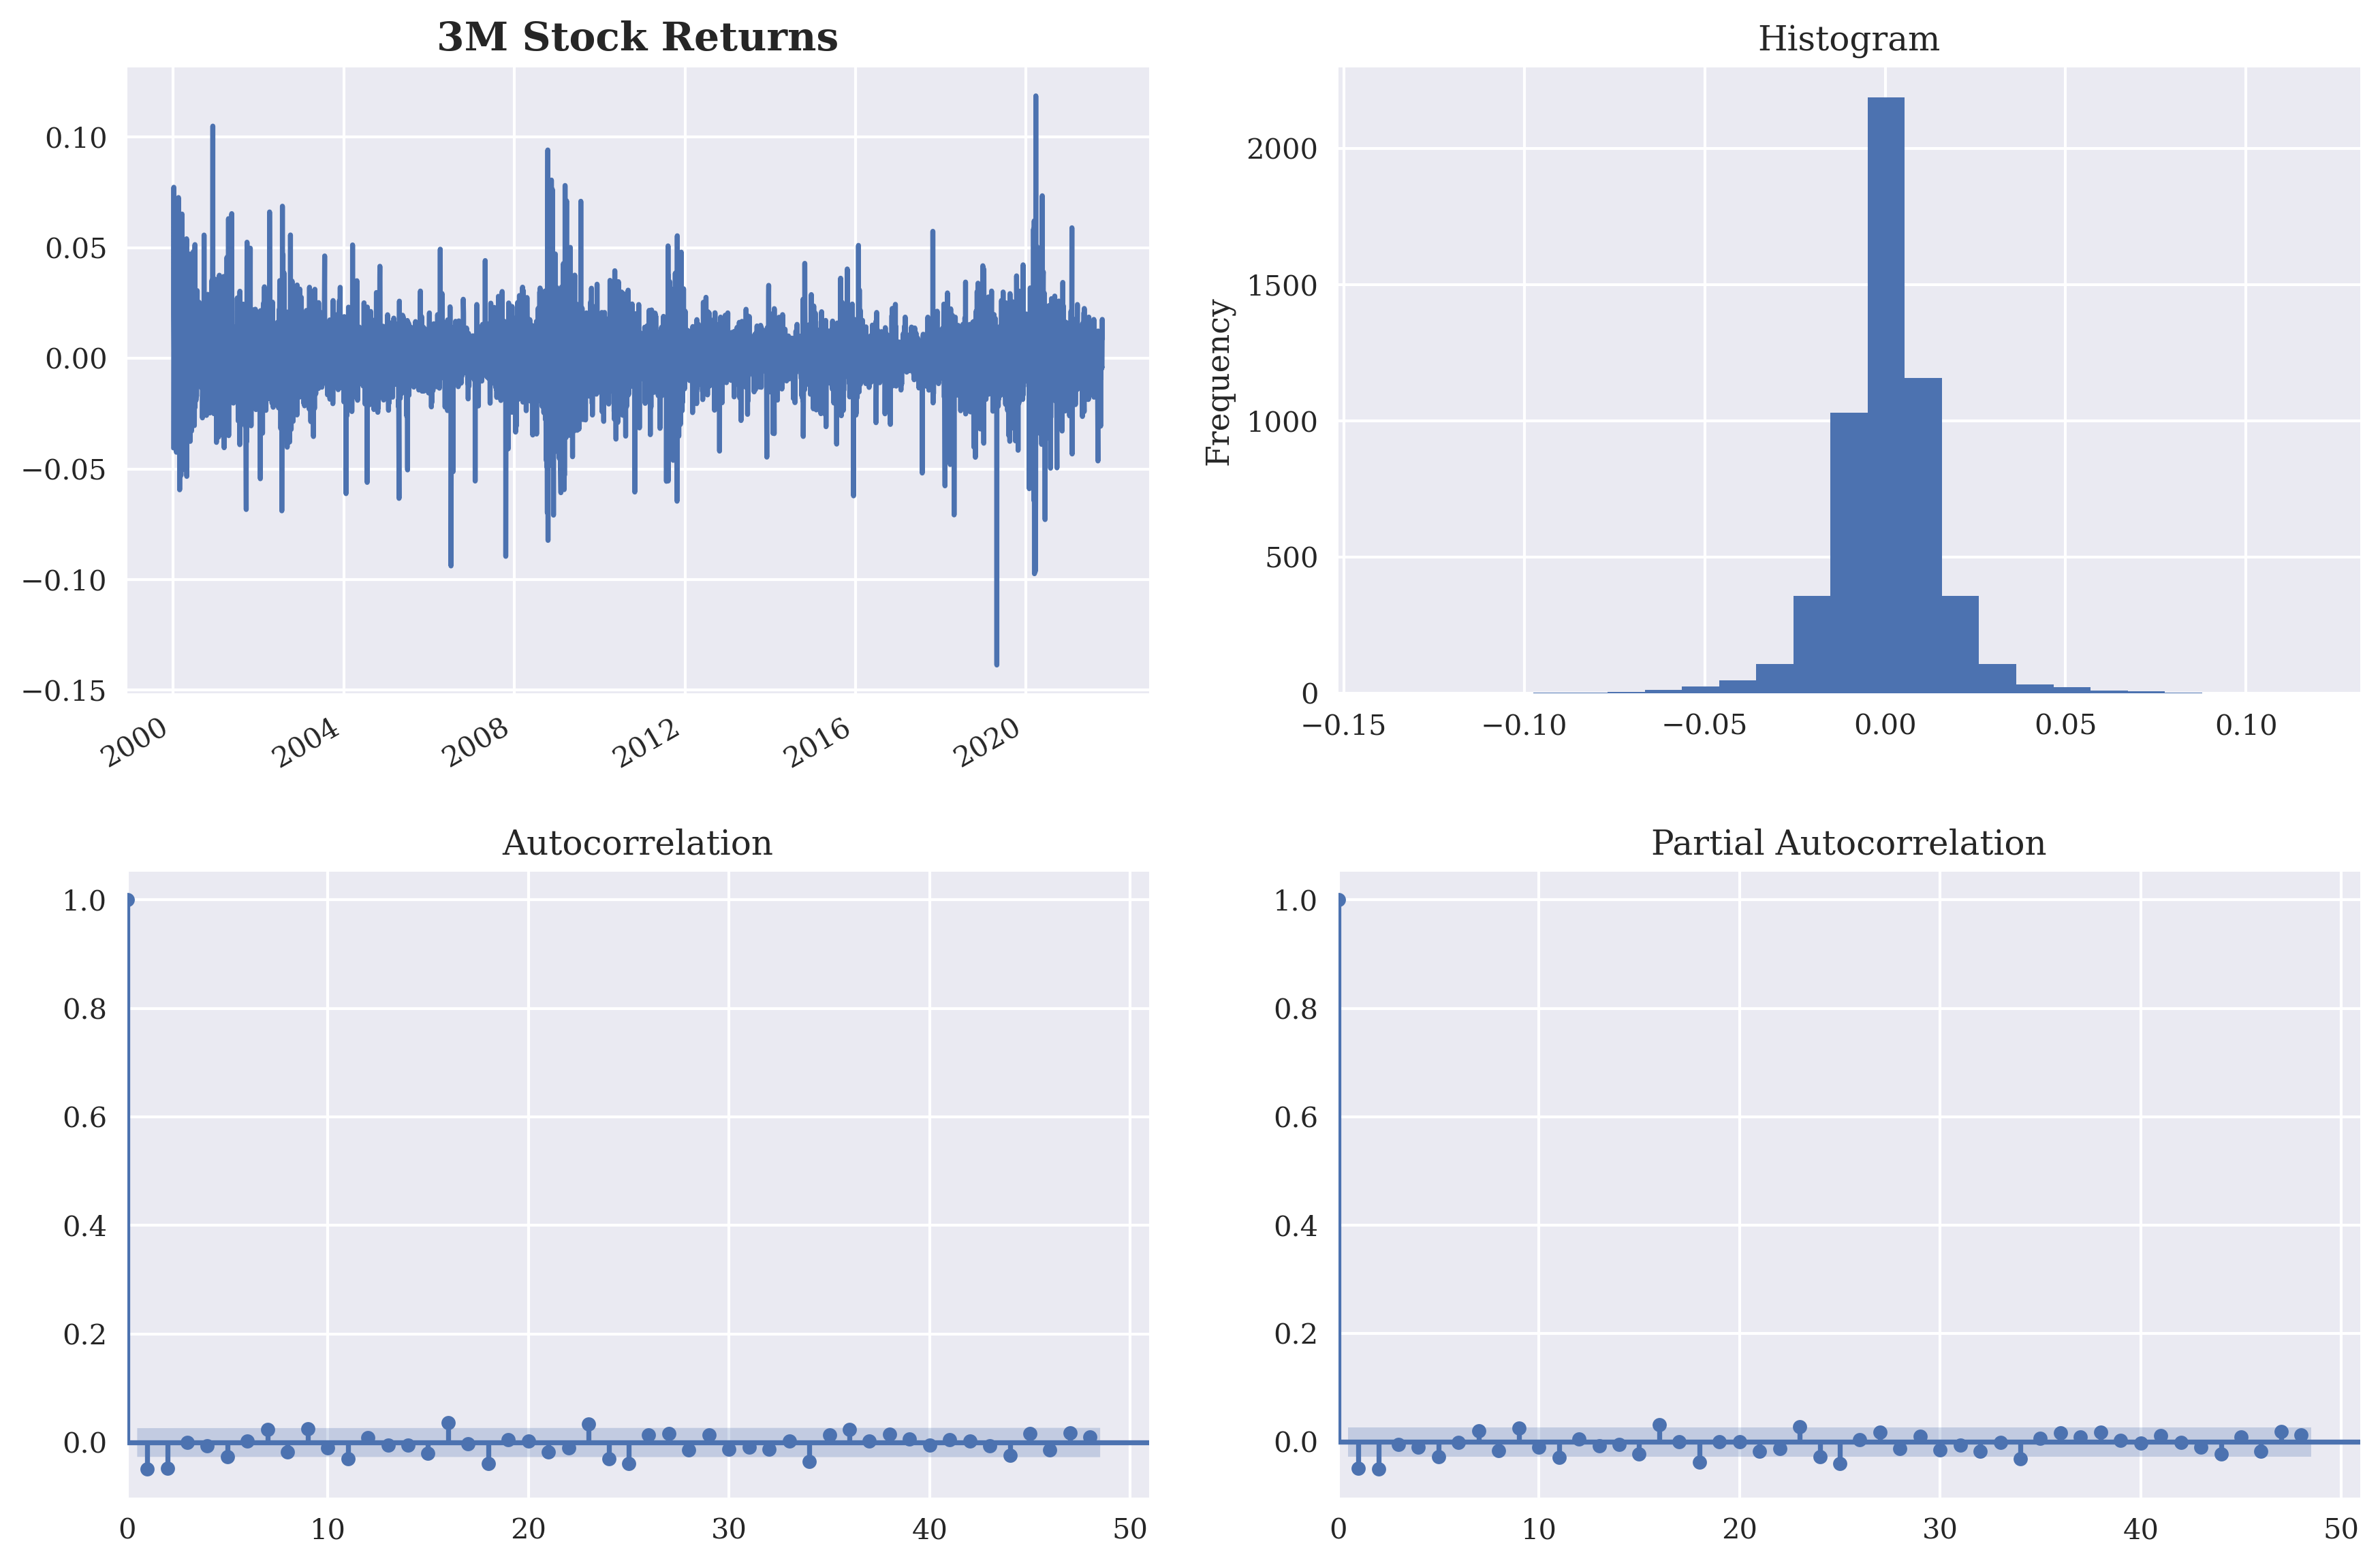

In [297]:
# returns look stationary and have a normal distribution
tsplot(sp500['MMM_returns'].dropna(),title = "3M Stock Returns",lags = 48)

(<AxesSubplot:title={'center':'Berkshire Hathaway Inc. Stock Returns'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

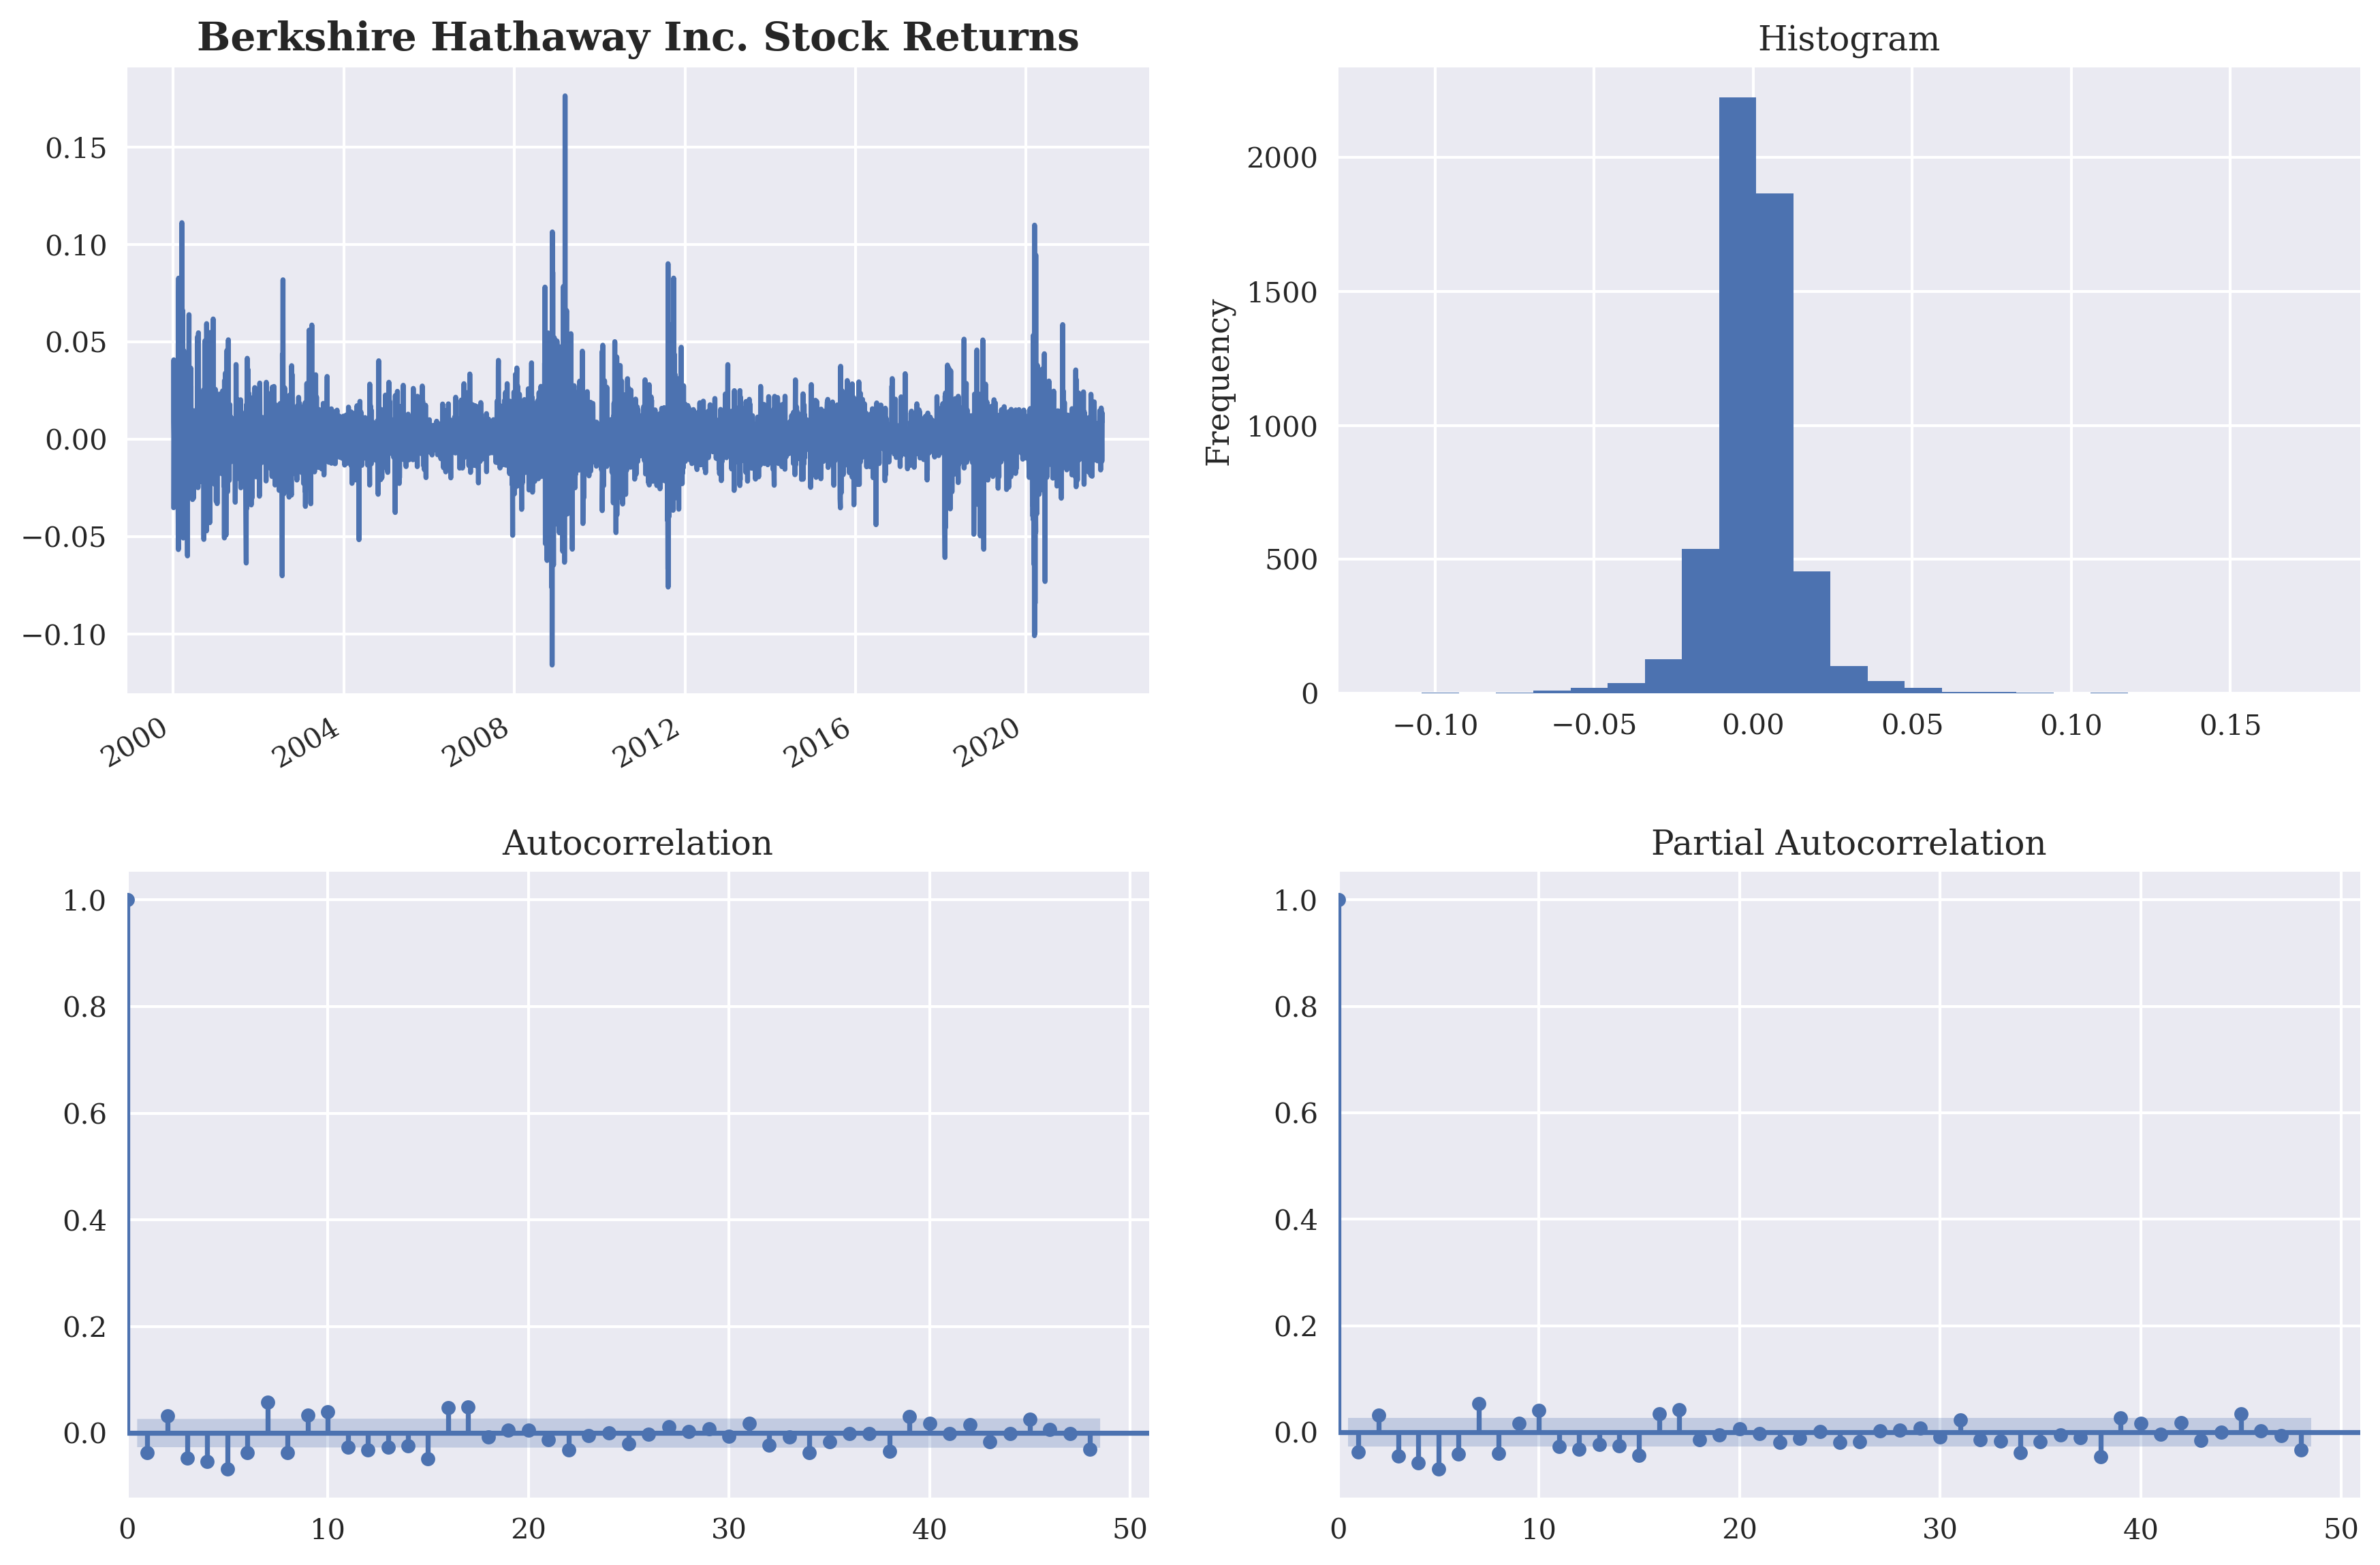

In [298]:
# returns look stationary and have a normal distribution
tsplot(sp500['BRK-B_returns'].dropna(),title = "Berkshire Hathaway Inc. Stock Returns",lags = 48)

### Plotting Other Variables
It's likely that other variables such as a stock's high price, low price, open price, and volume do not exhibit stationarity. If the variables are non-staionary, we can attempt to make them stationary by taking their log differences as well.
#### Time Series of Apple Stock's High Price,  Low Price, Open Price, Intraday Spread, and Volume 

(<AxesSubplot:title={'center':'Apple Stock Highs'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

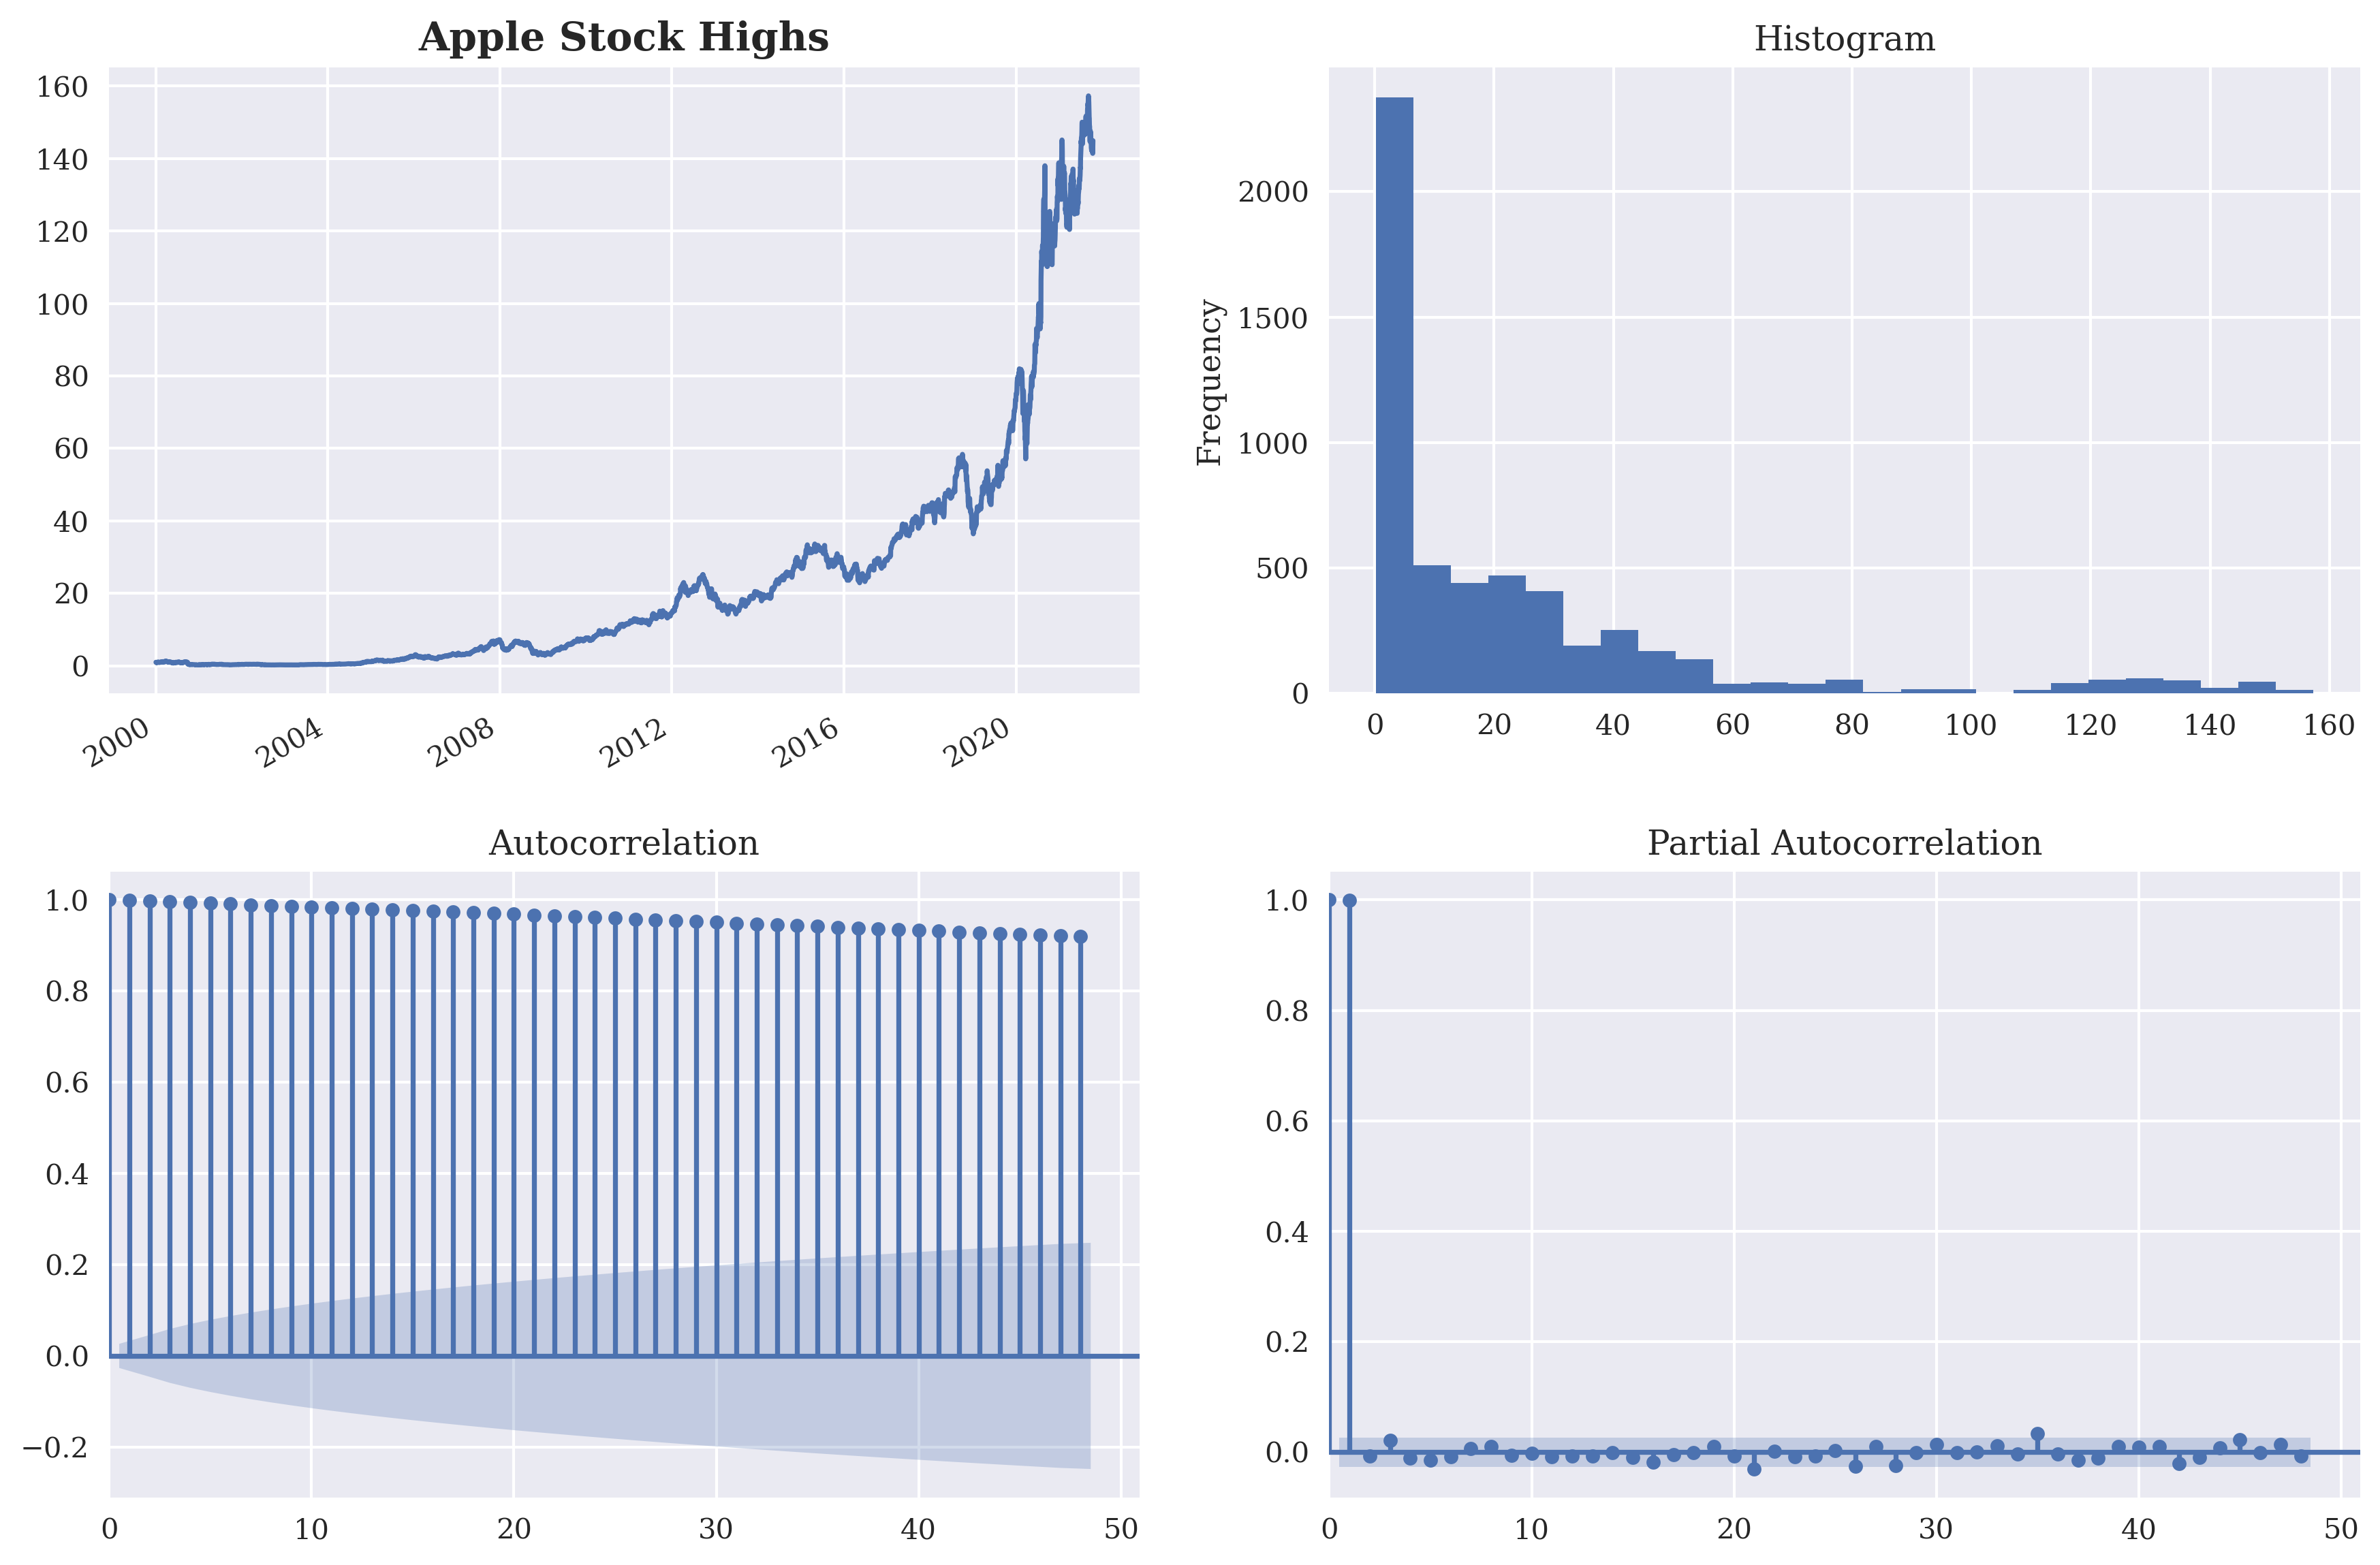

In [299]:
# High price
tsplot(sp500['AAPL_high'].dropna(),title = "Apple Stock Highs",lags = 48)

(<AxesSubplot:title={'center':'Apple Stock Lows'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

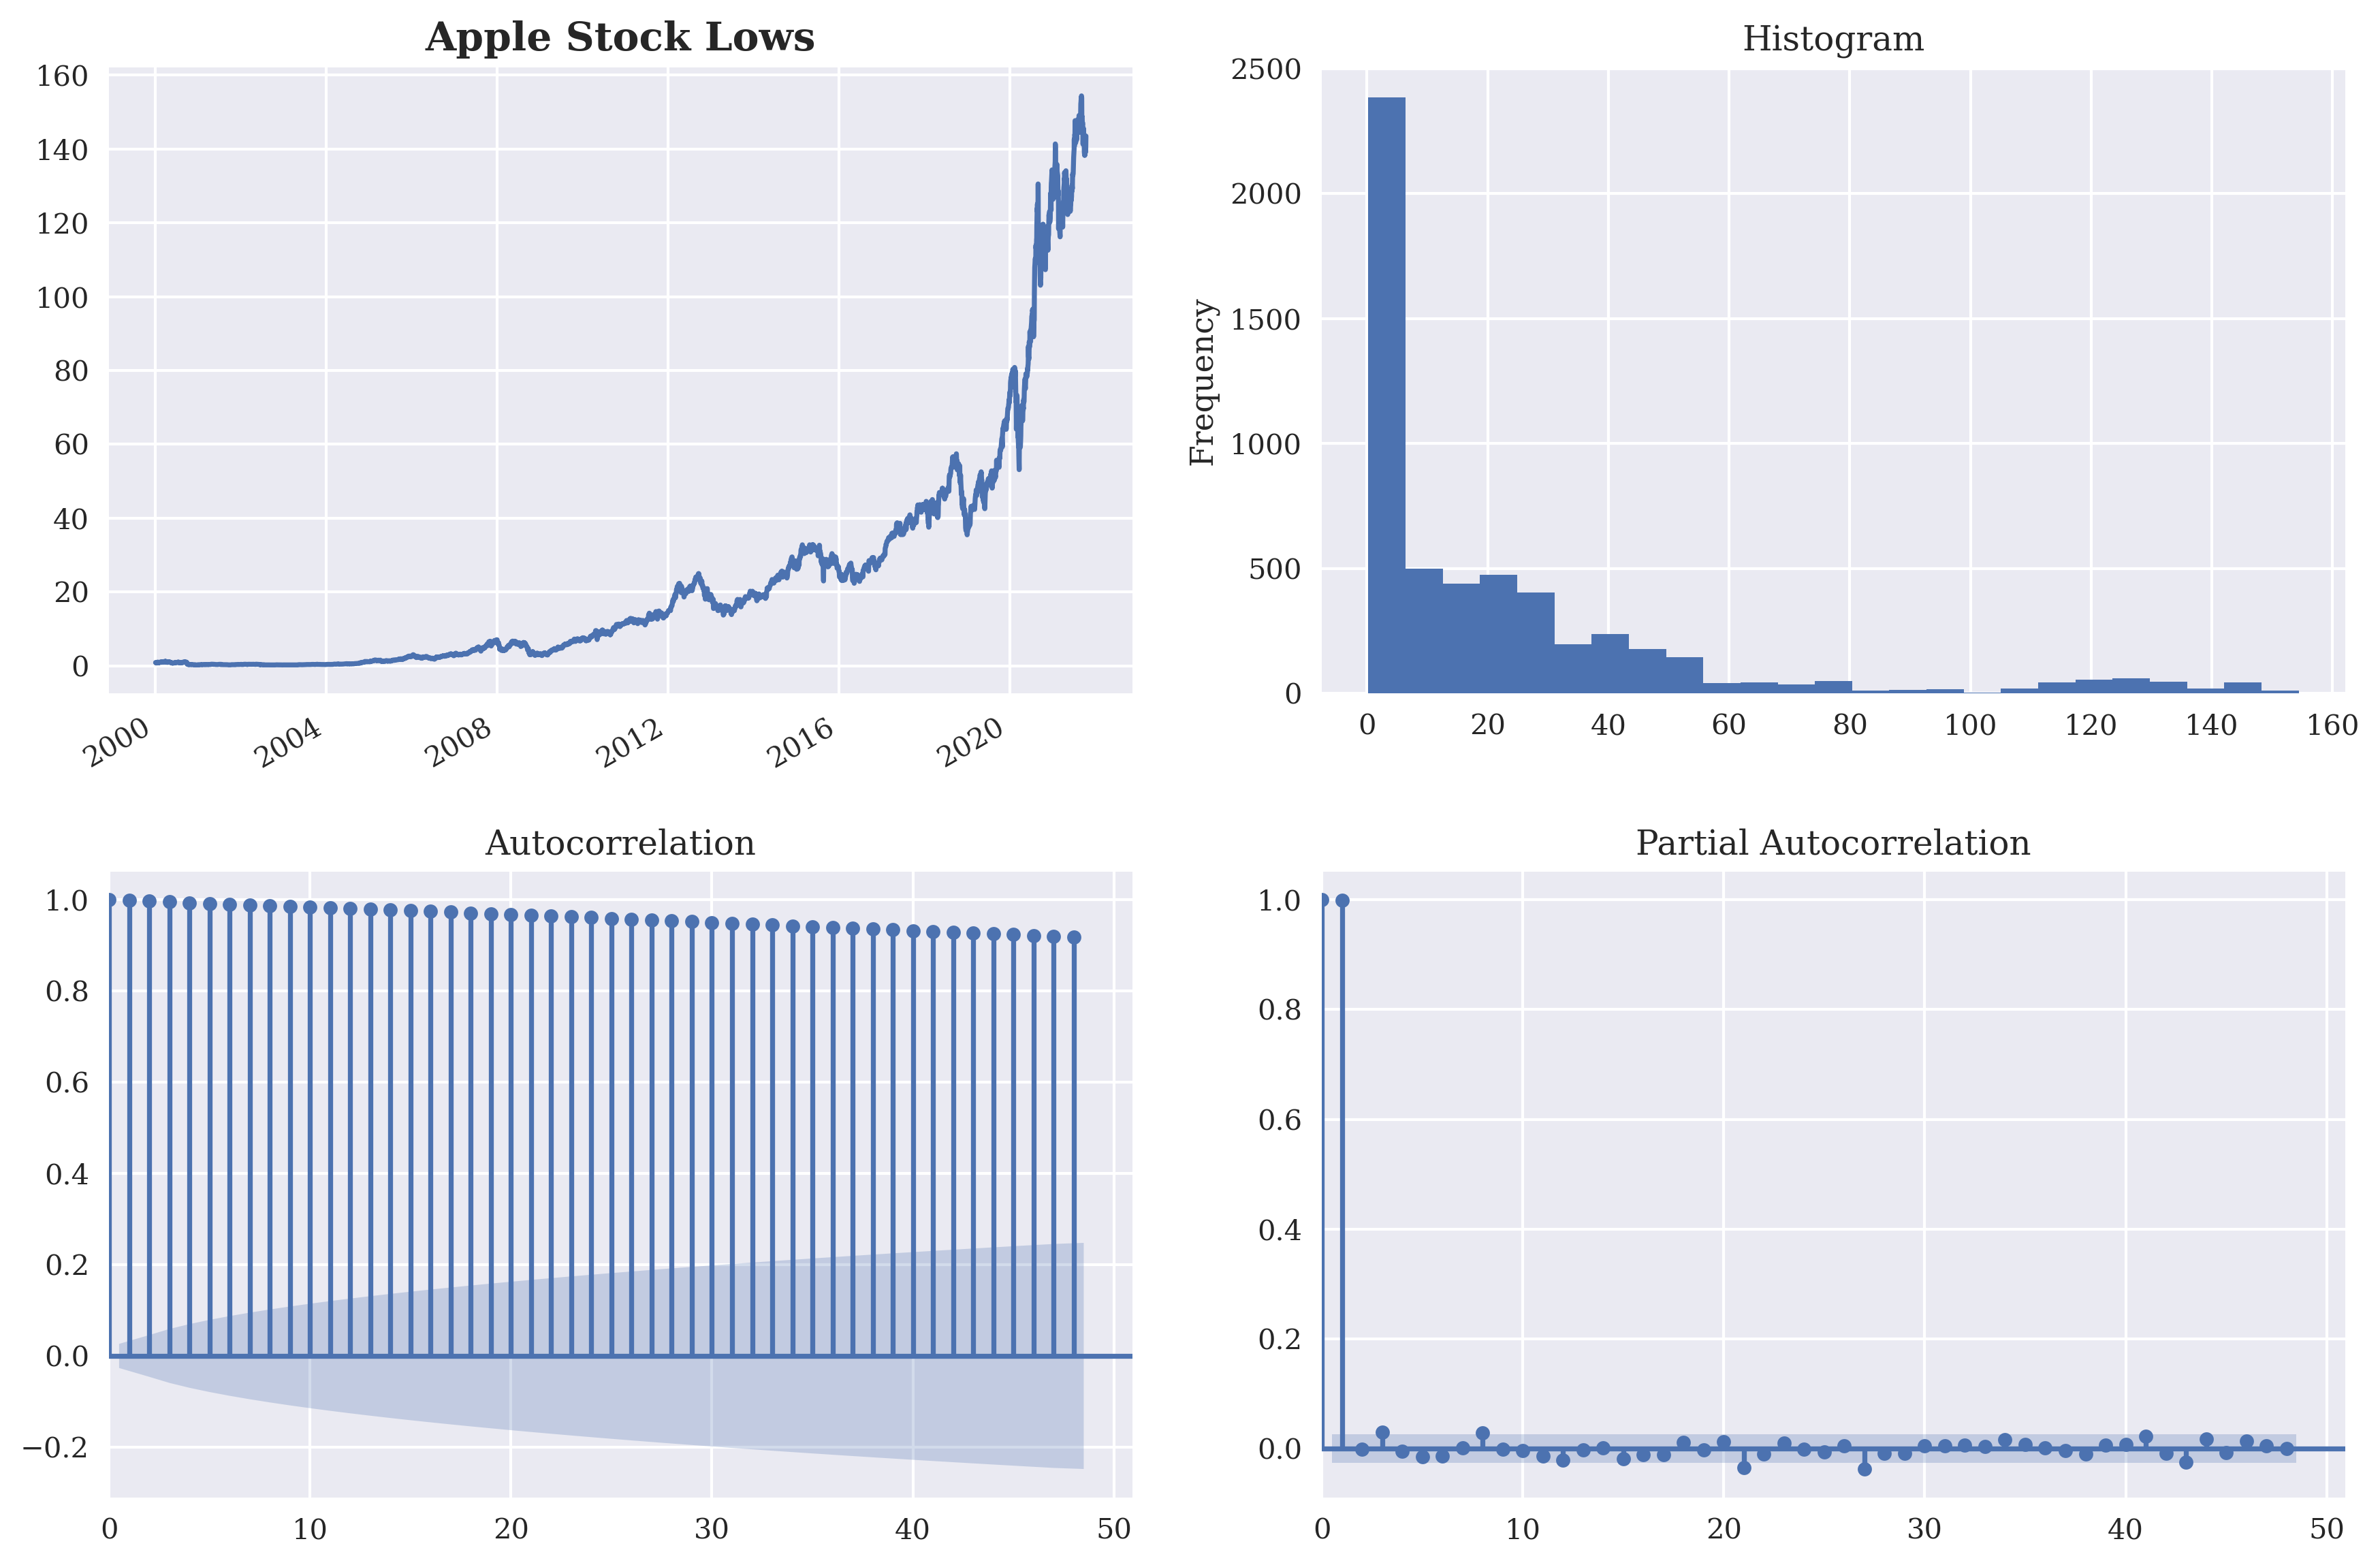

In [300]:
# Low price
tsplot(sp500['AAPL_low'].dropna(),title = "Apple Stock Lows",lags = 48)

(<AxesSubplot:title={'center':'Apple Stock Opens'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

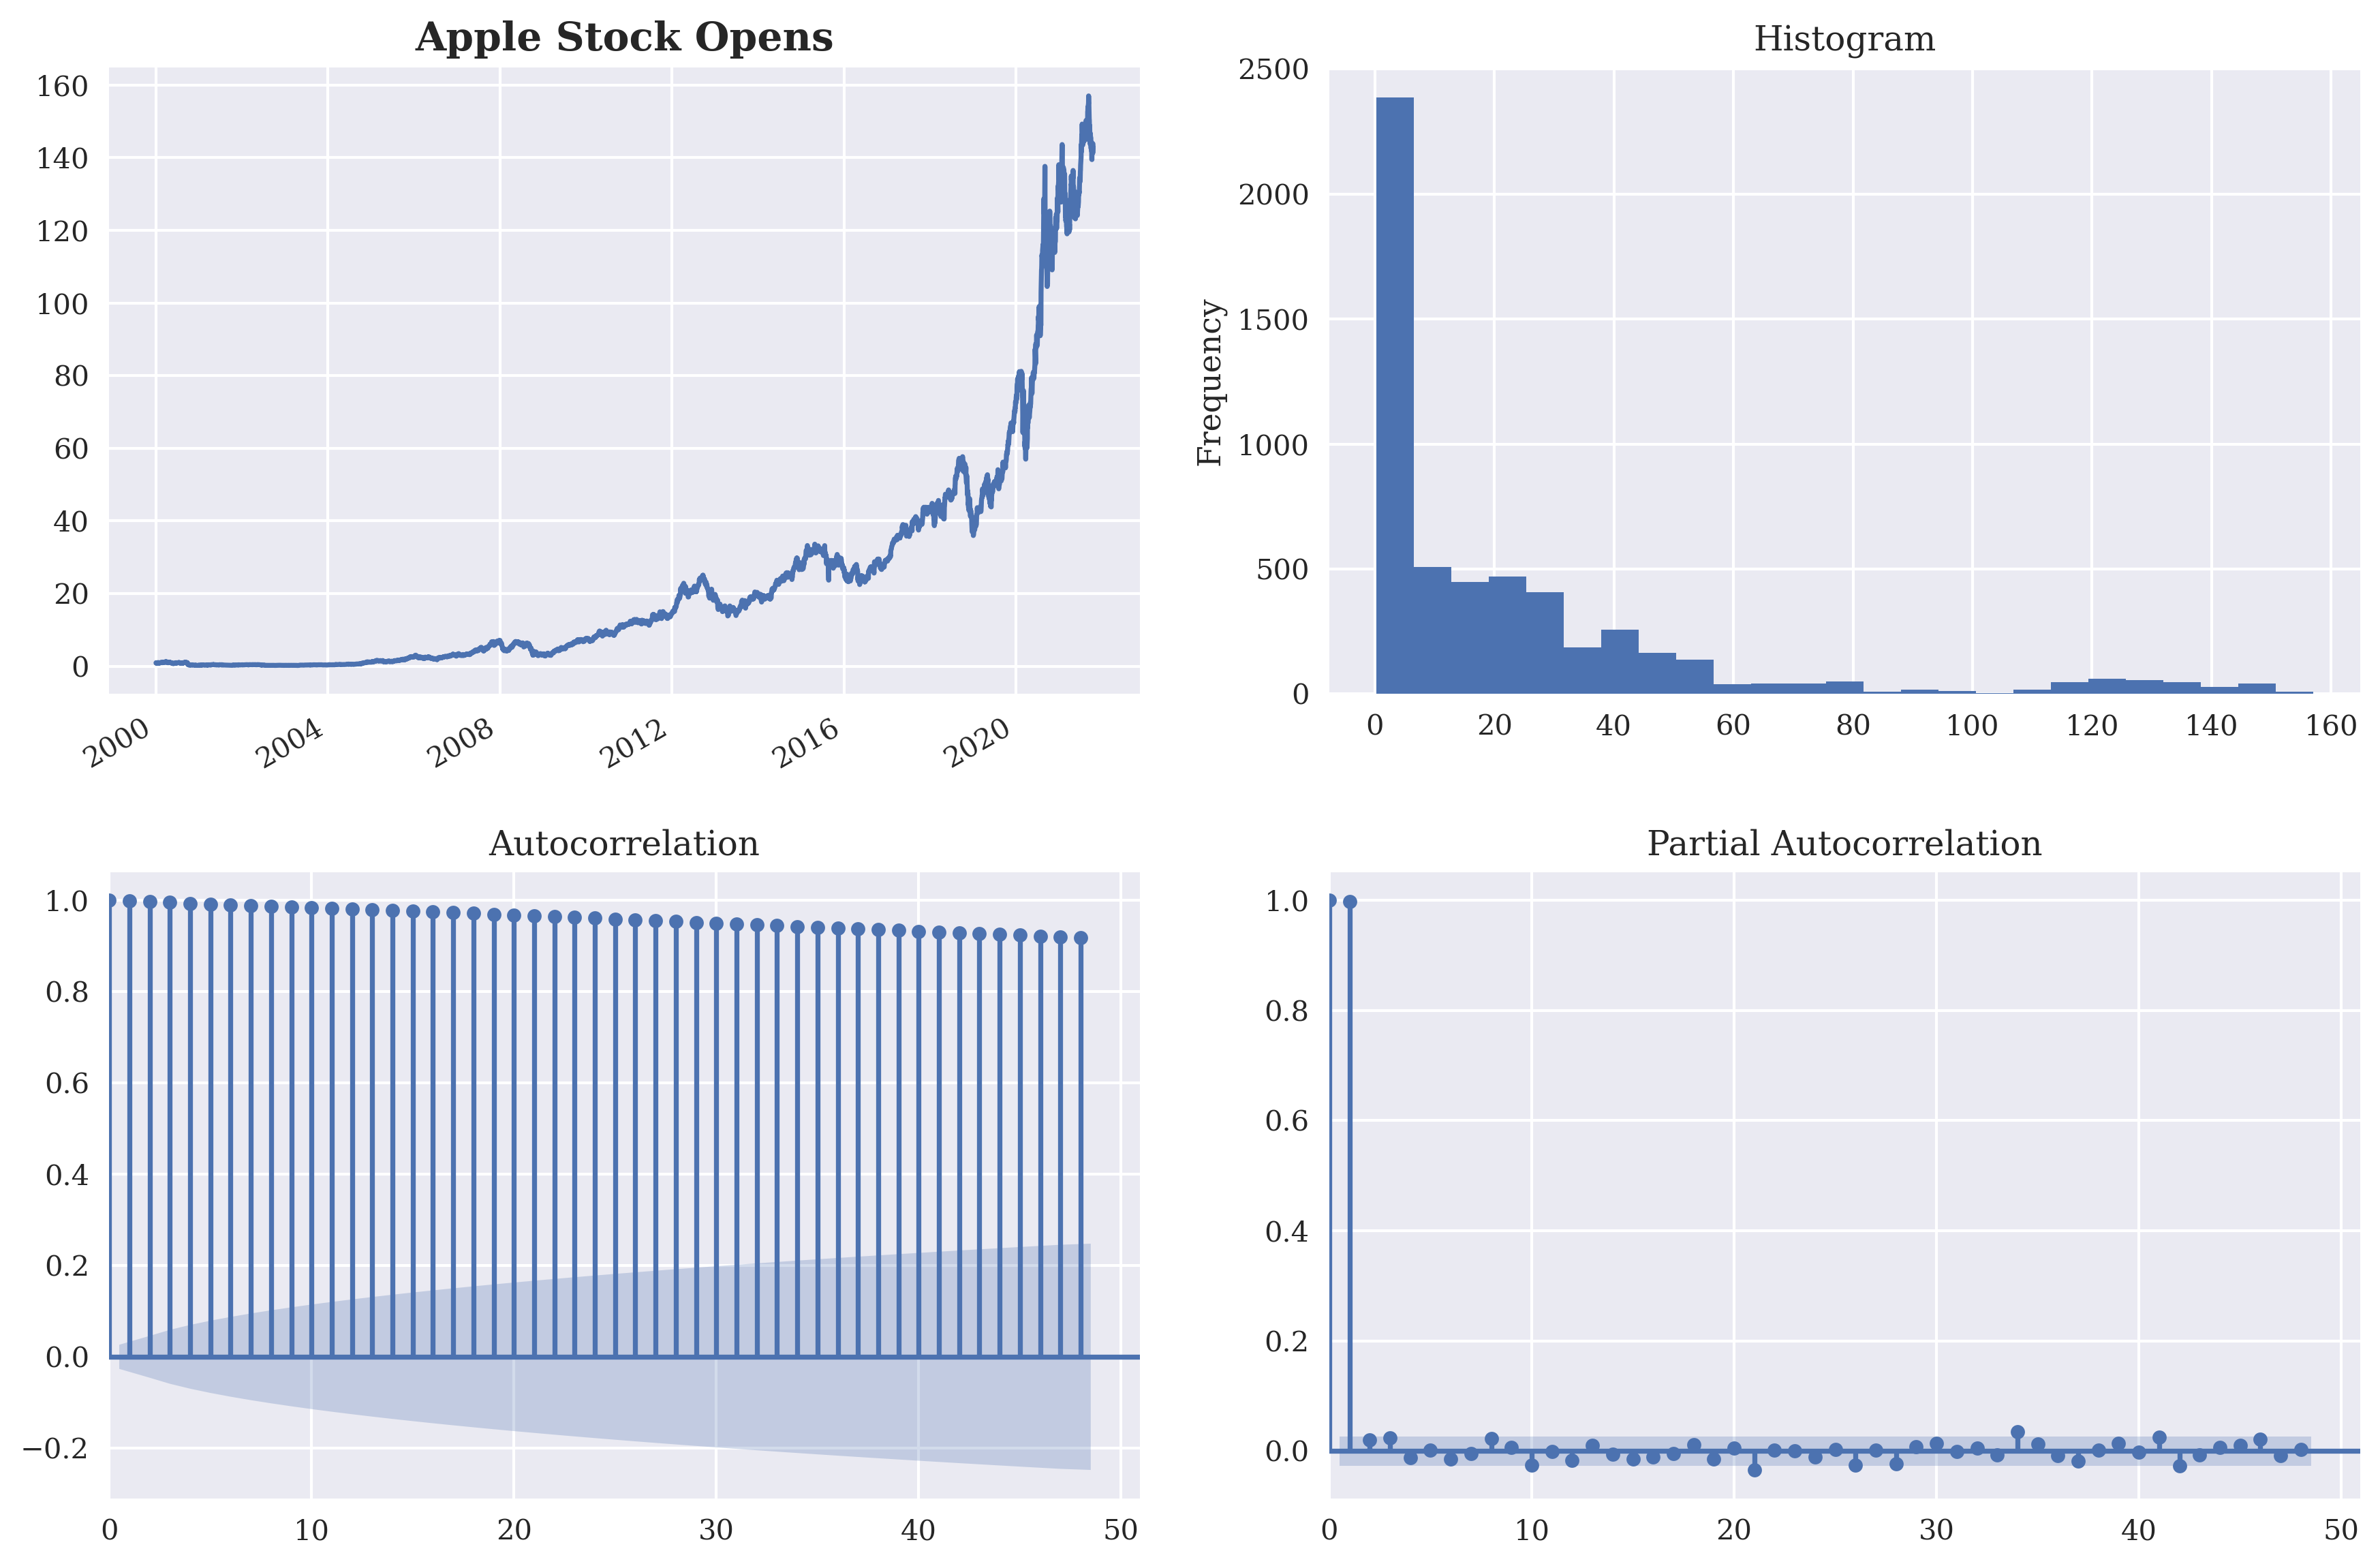

In [301]:
# Open price
tsplot(sp500['AAPL_open'].dropna(),title = "Apple Stock Opens",lags = 48)

(<AxesSubplot:title={'center':'Apple Stock Intraday Spreads'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

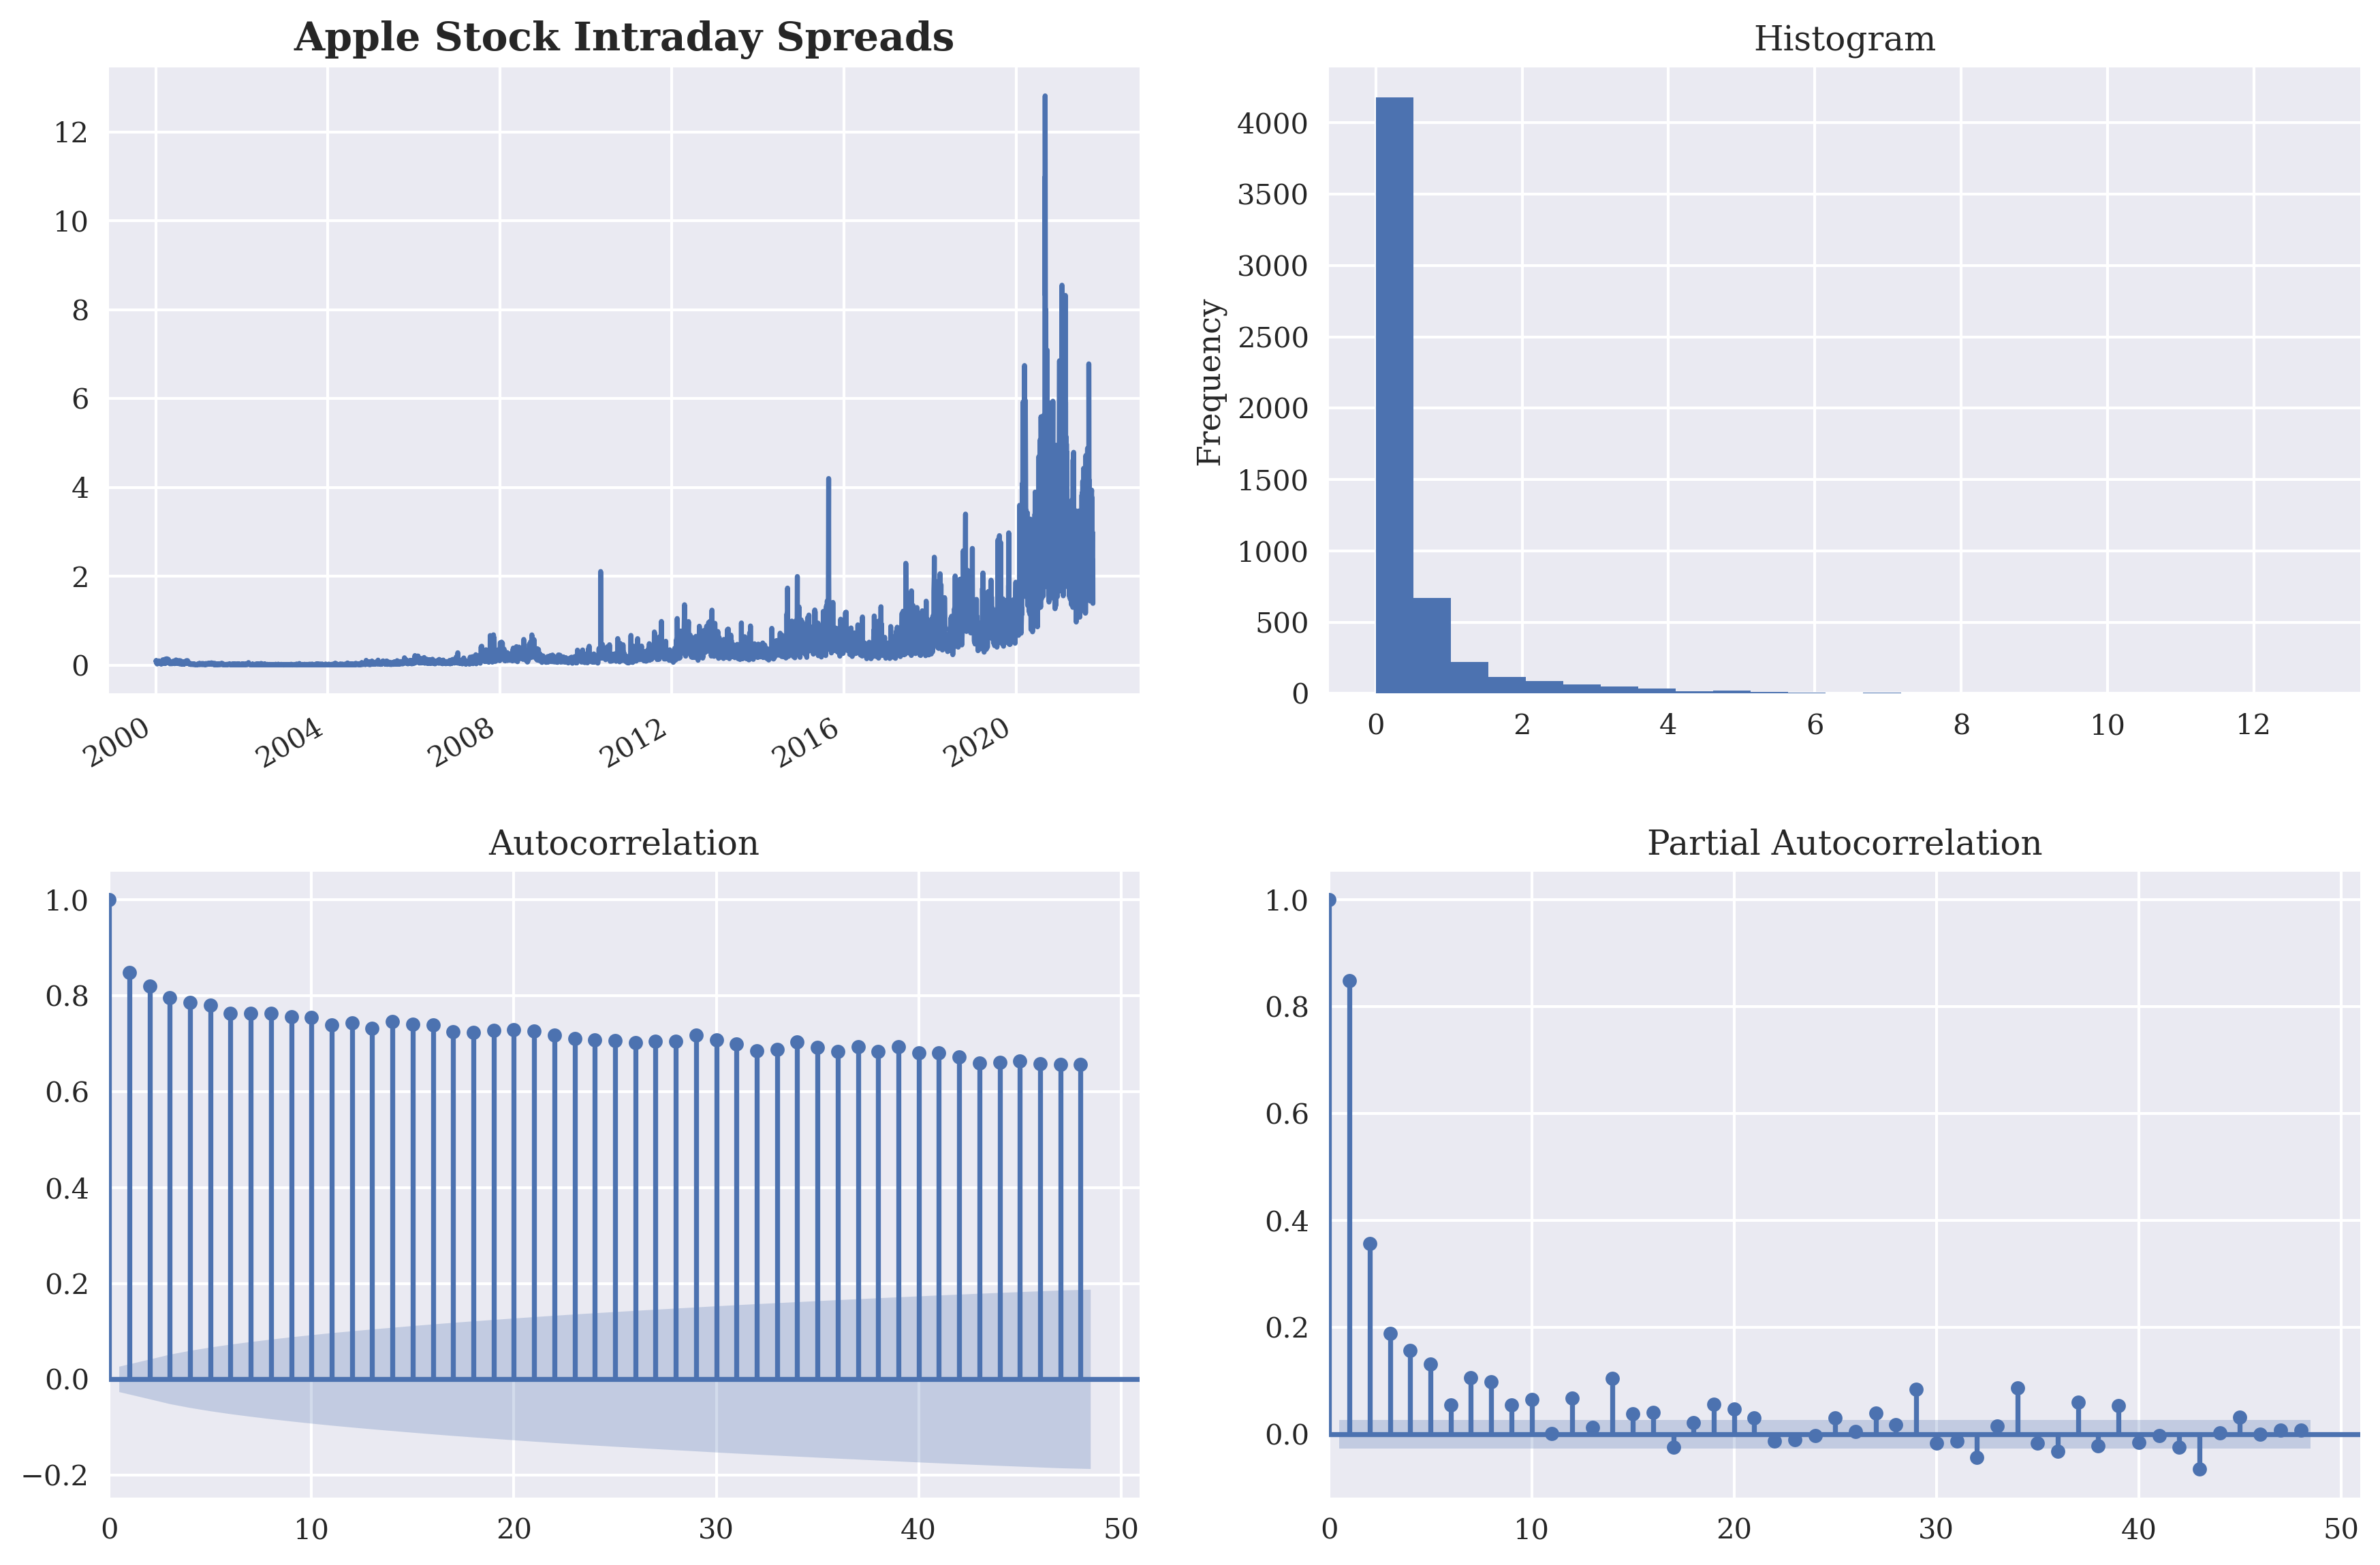

In [302]:
tsplot(sp500['AAPL_intraday_spread'].dropna(),title = "Apple Stock Intraday Spreads",lags = 48)

(<AxesSubplot:title={'center':'Apple Stock Volume Traded'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

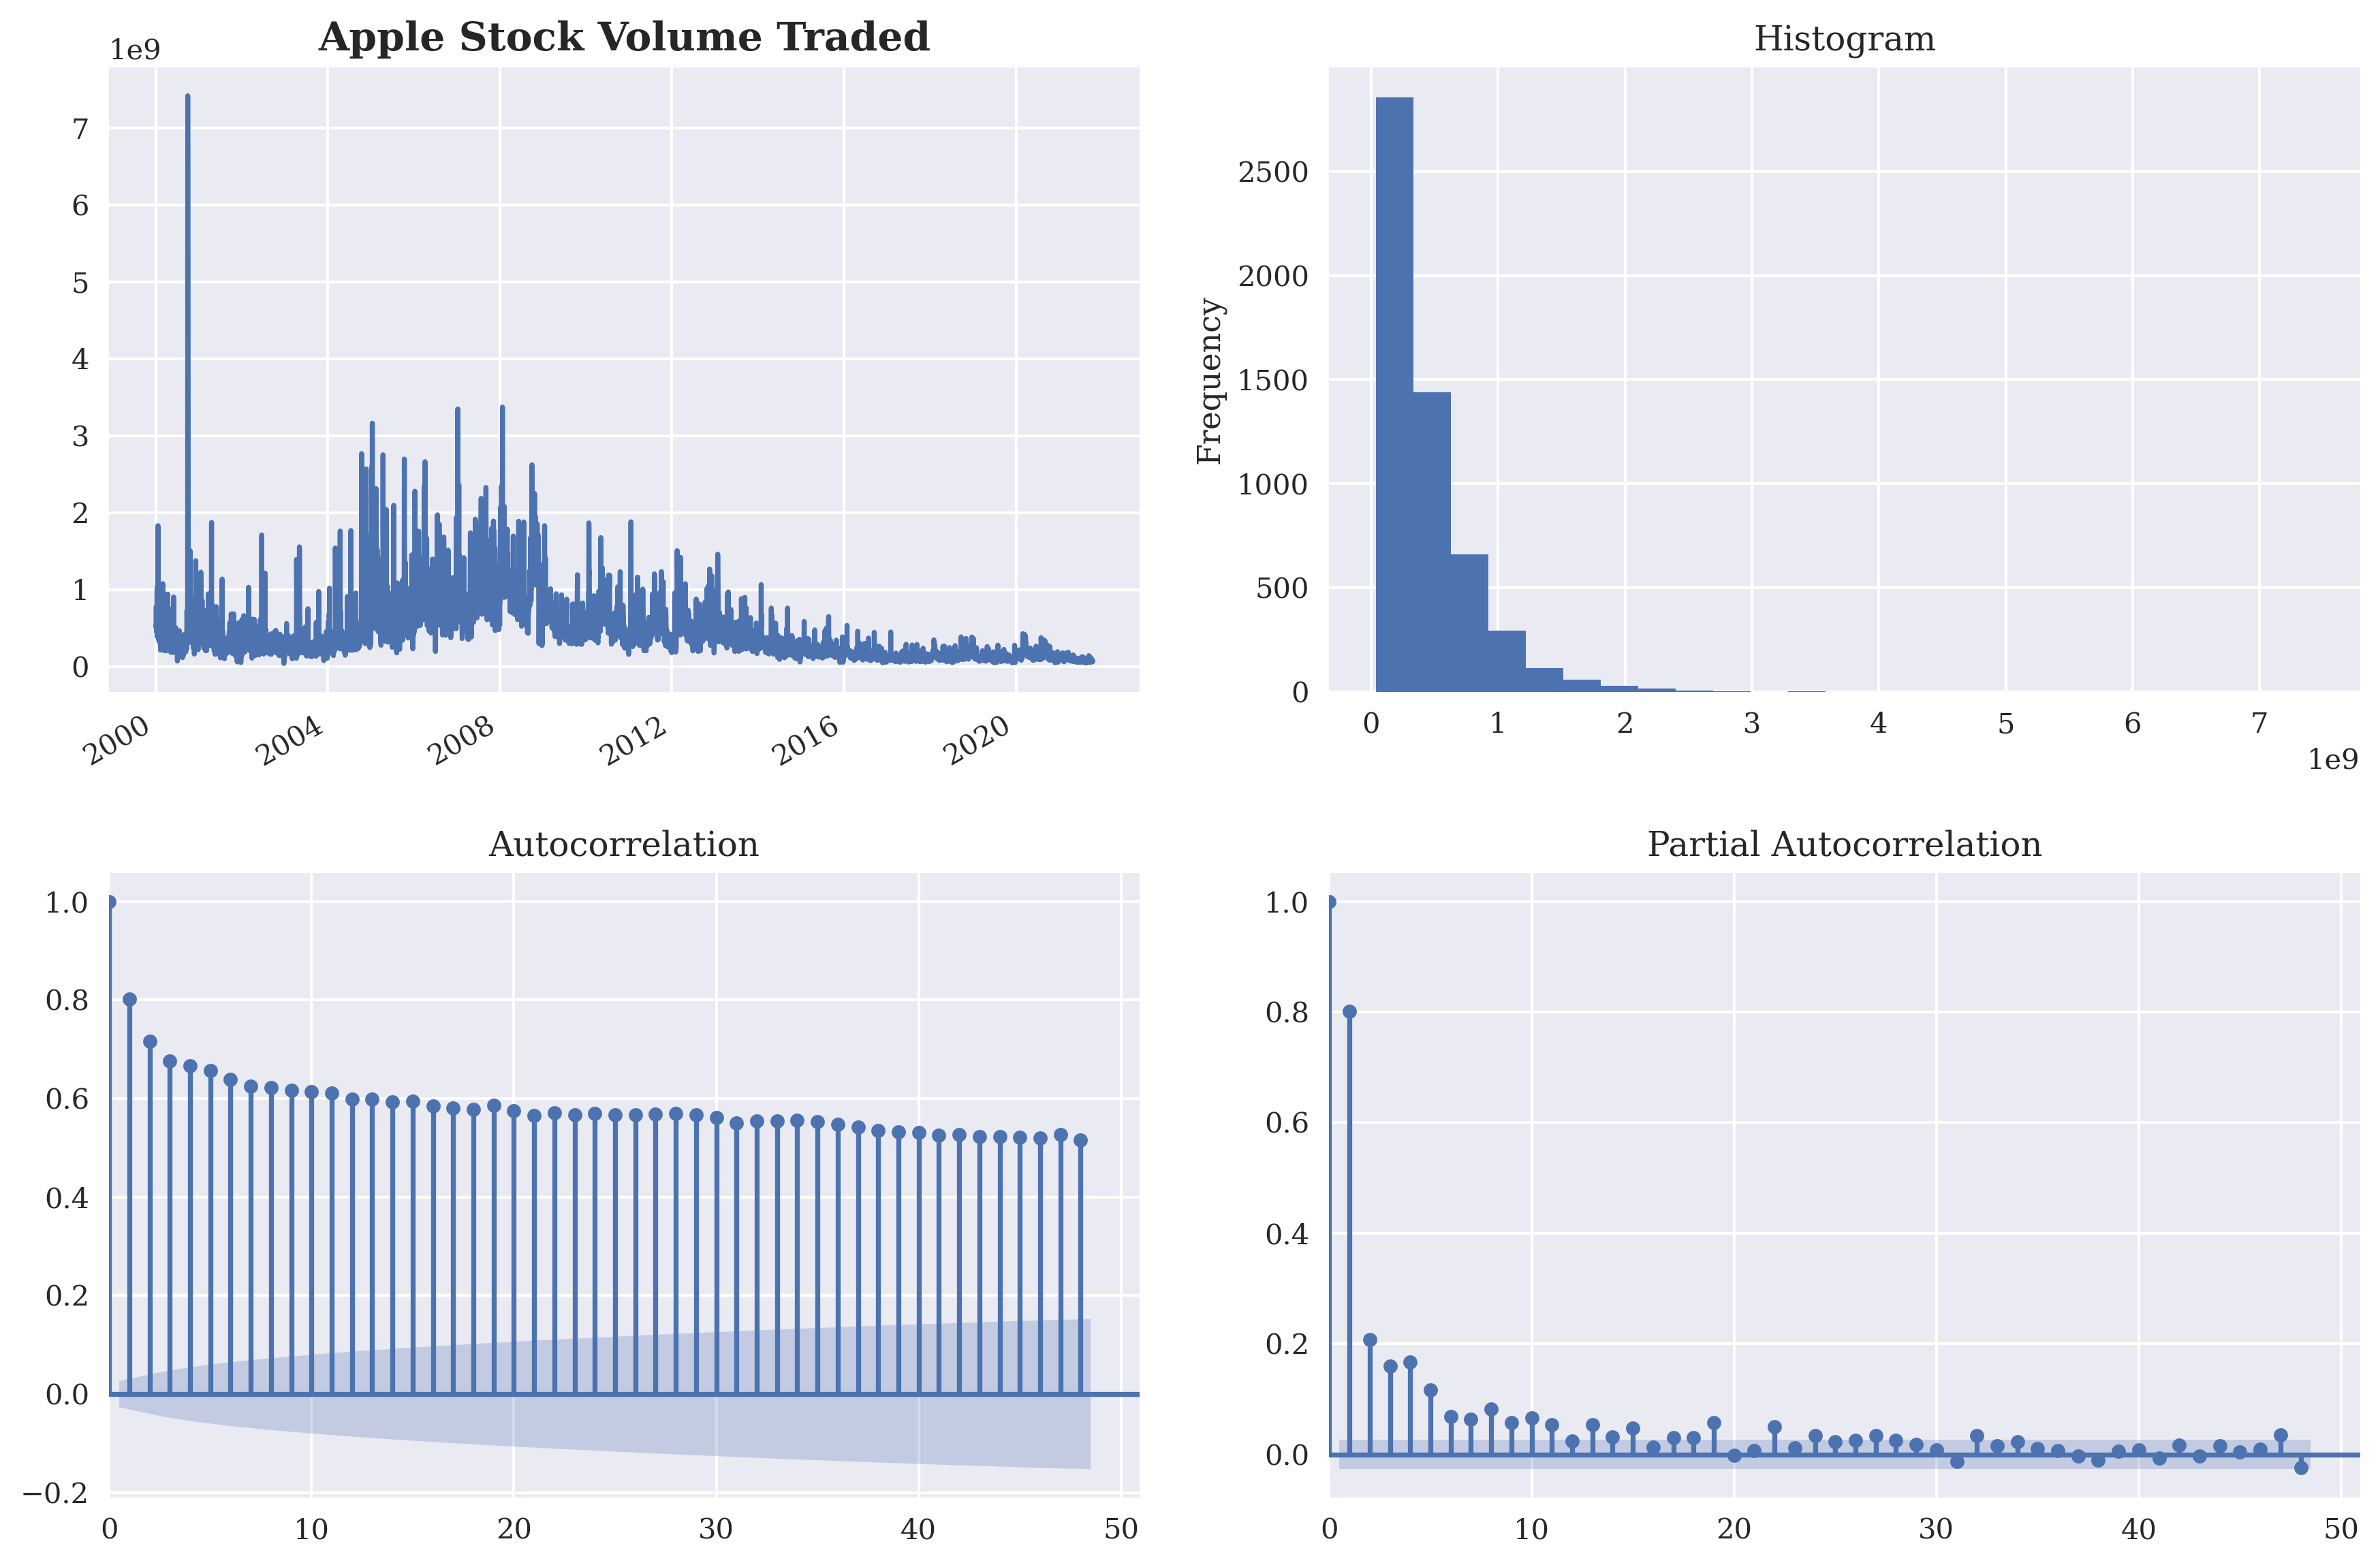

In [303]:
# Volume
tsplot(sp500['AAPL_volume'].dropna(),title = "Apple Stock Volume Traded",lags = 48)

### Making those Variables Stationary

(<AxesSubplot:title={'center':'Apple Stock Highs'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

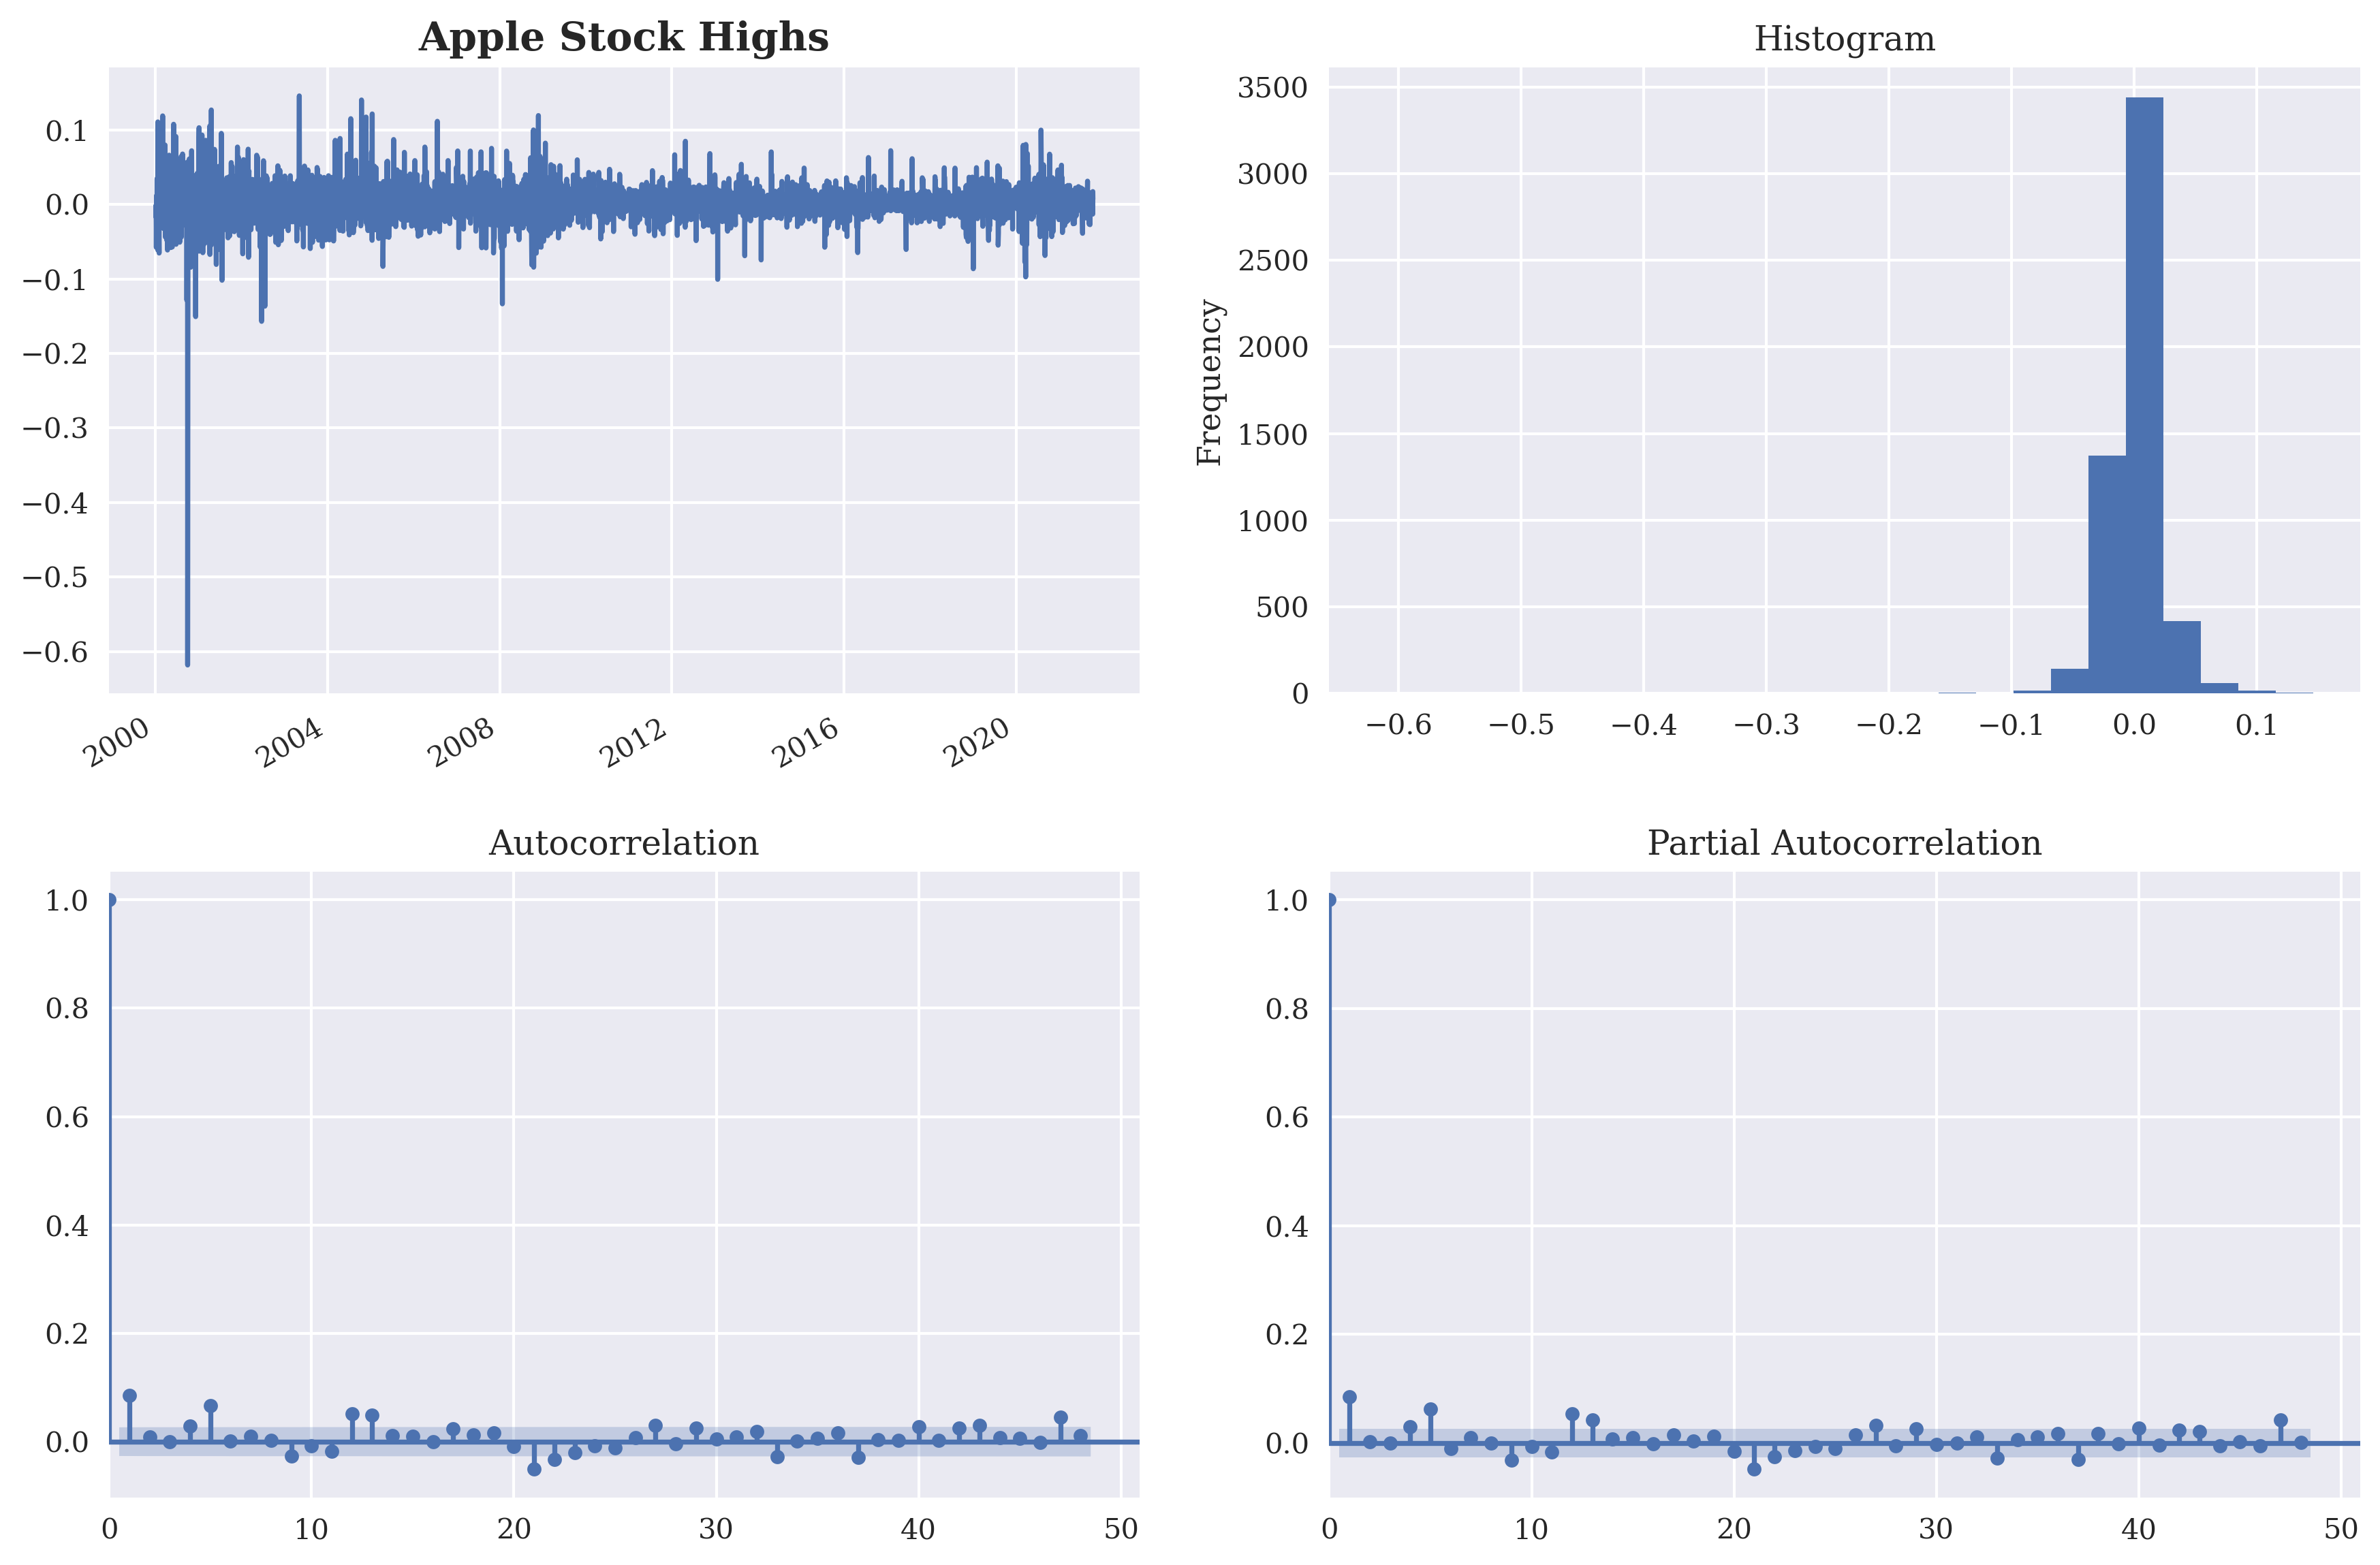

In [304]:
tsplot(np.log(sp500['AAPL_high'].div(sp500['AAPL_high'].shift(1))).dropna(),title = "Apple Stock Highs",lags = 48)

(<AxesSubplot:title={'center':'Apple Stock Lows'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

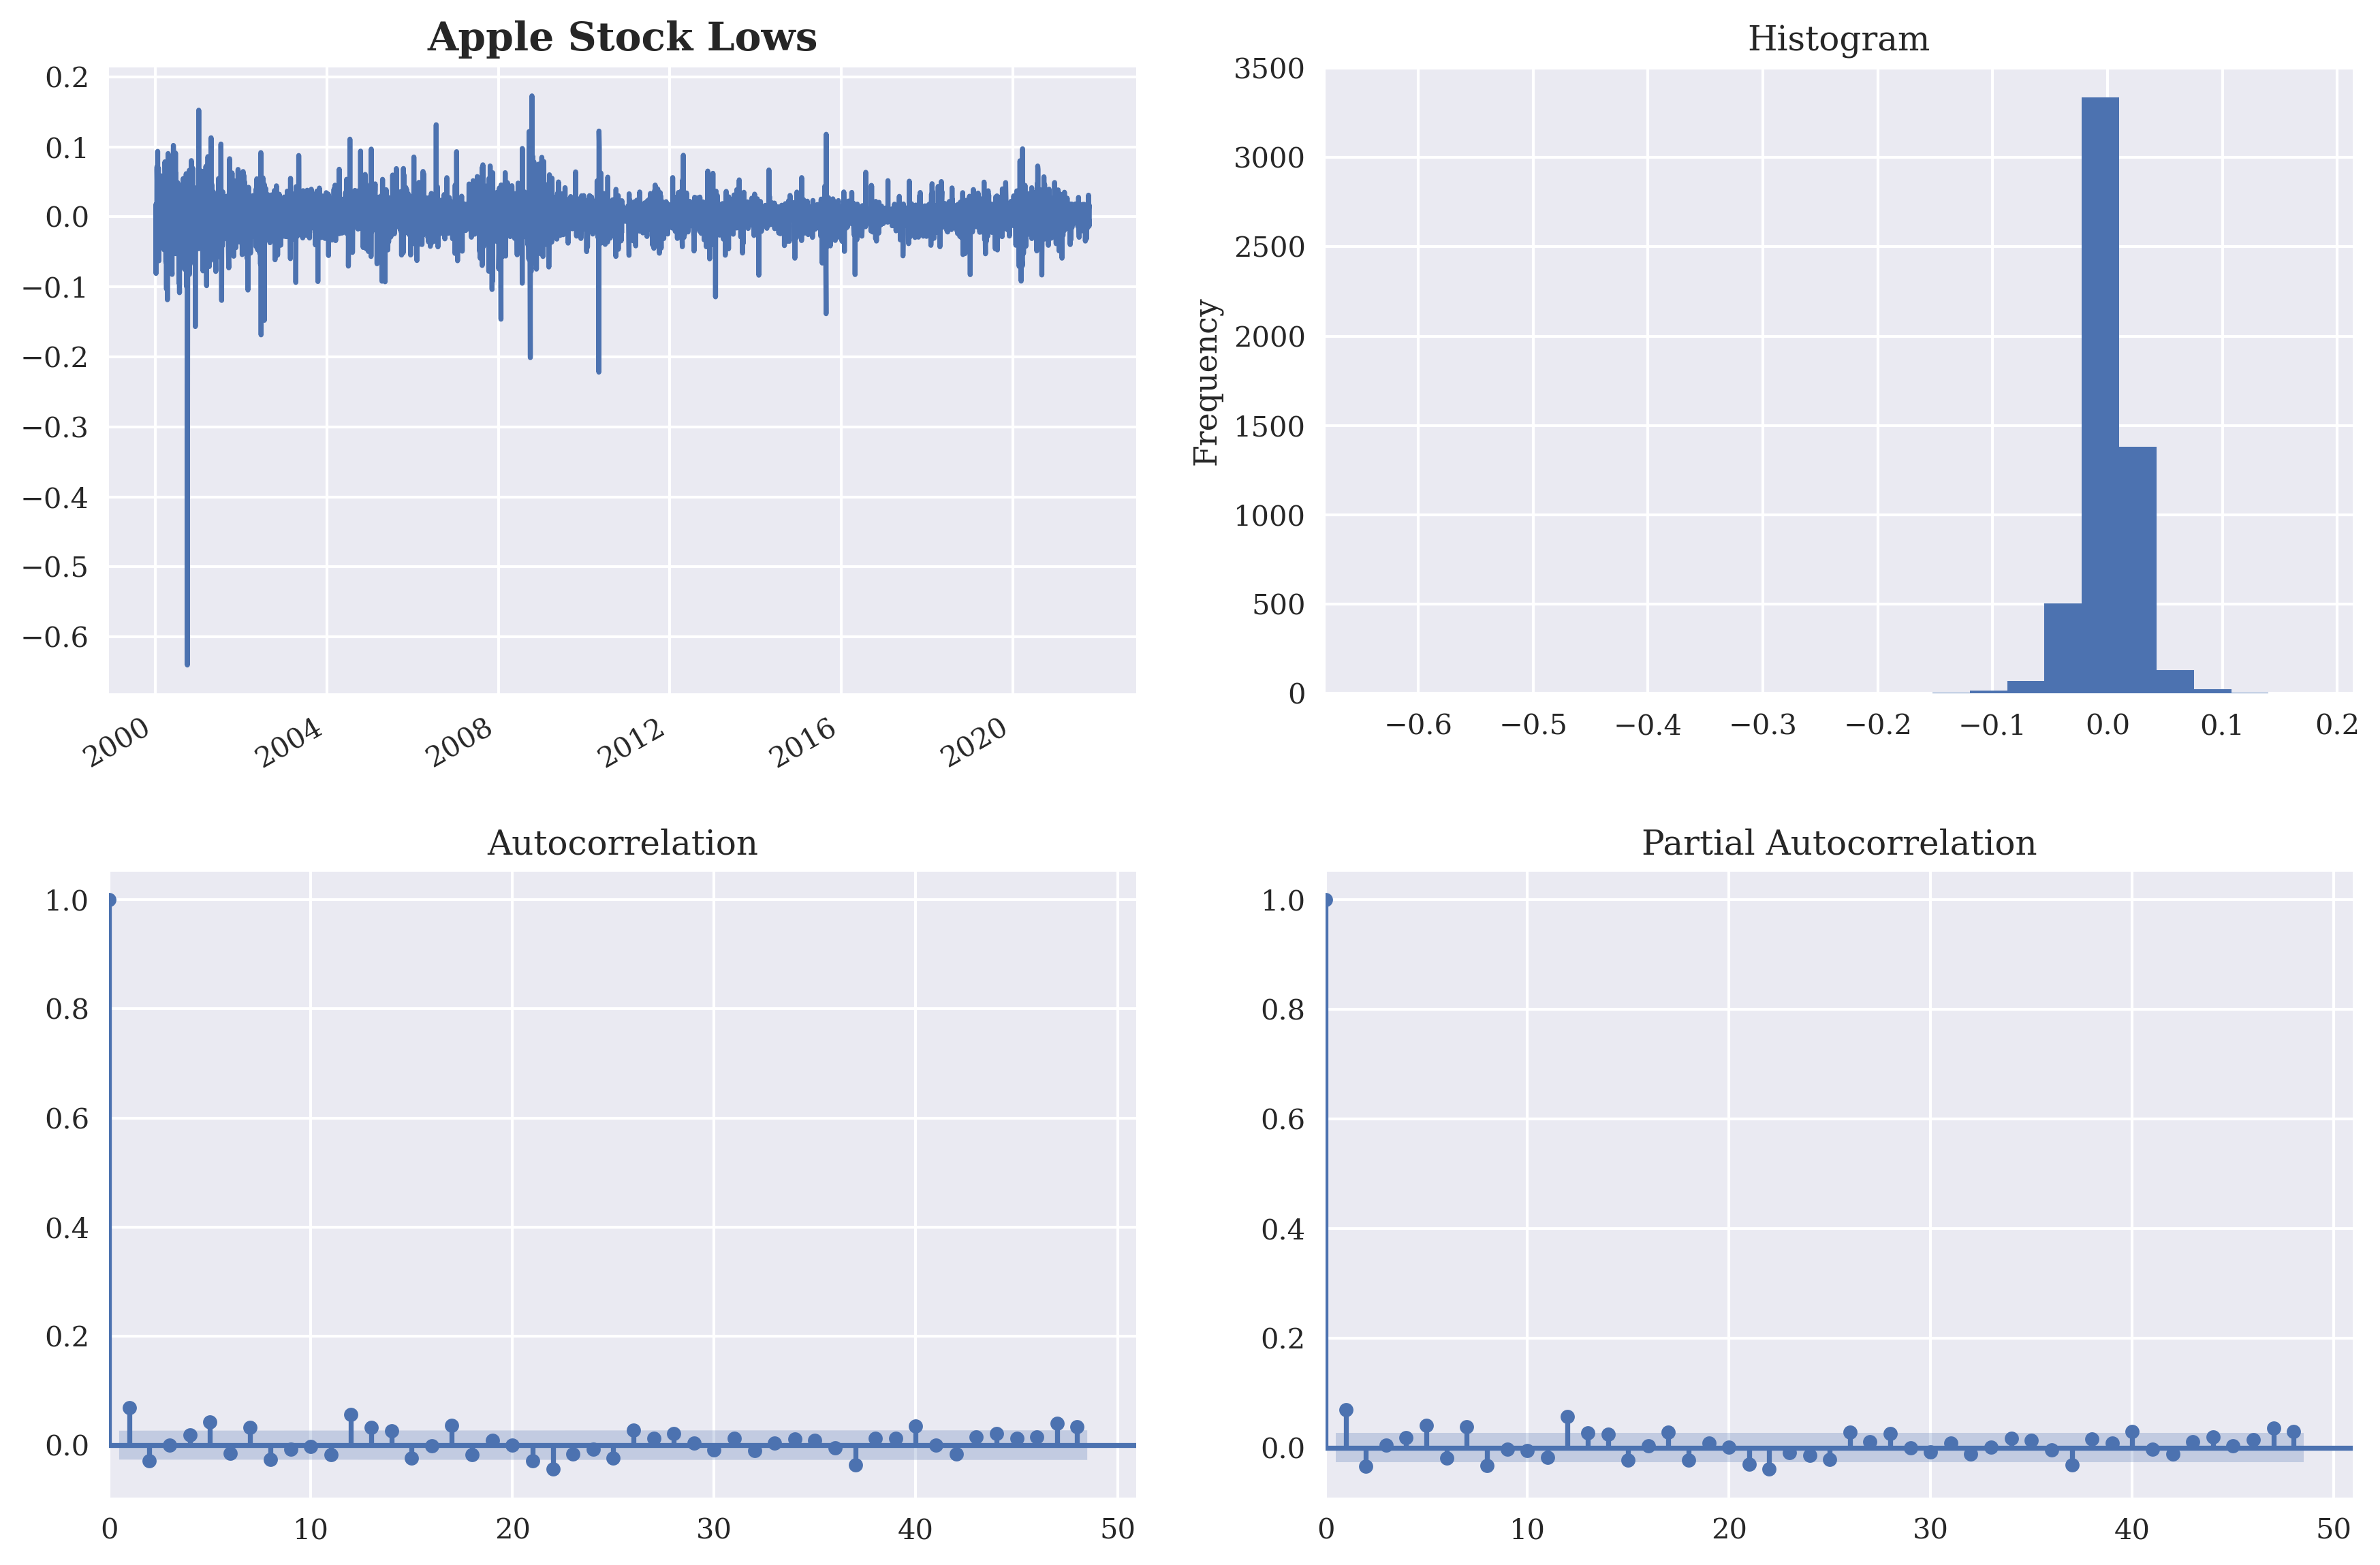

In [305]:
tsplot(np.log(sp500['AAPL_low'].div(sp500['AAPL_low'].shift(1))).dropna(),title = "Apple Stock Lows",lags = 48)

(<AxesSubplot:title={'center':'Apple Stock Opens'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

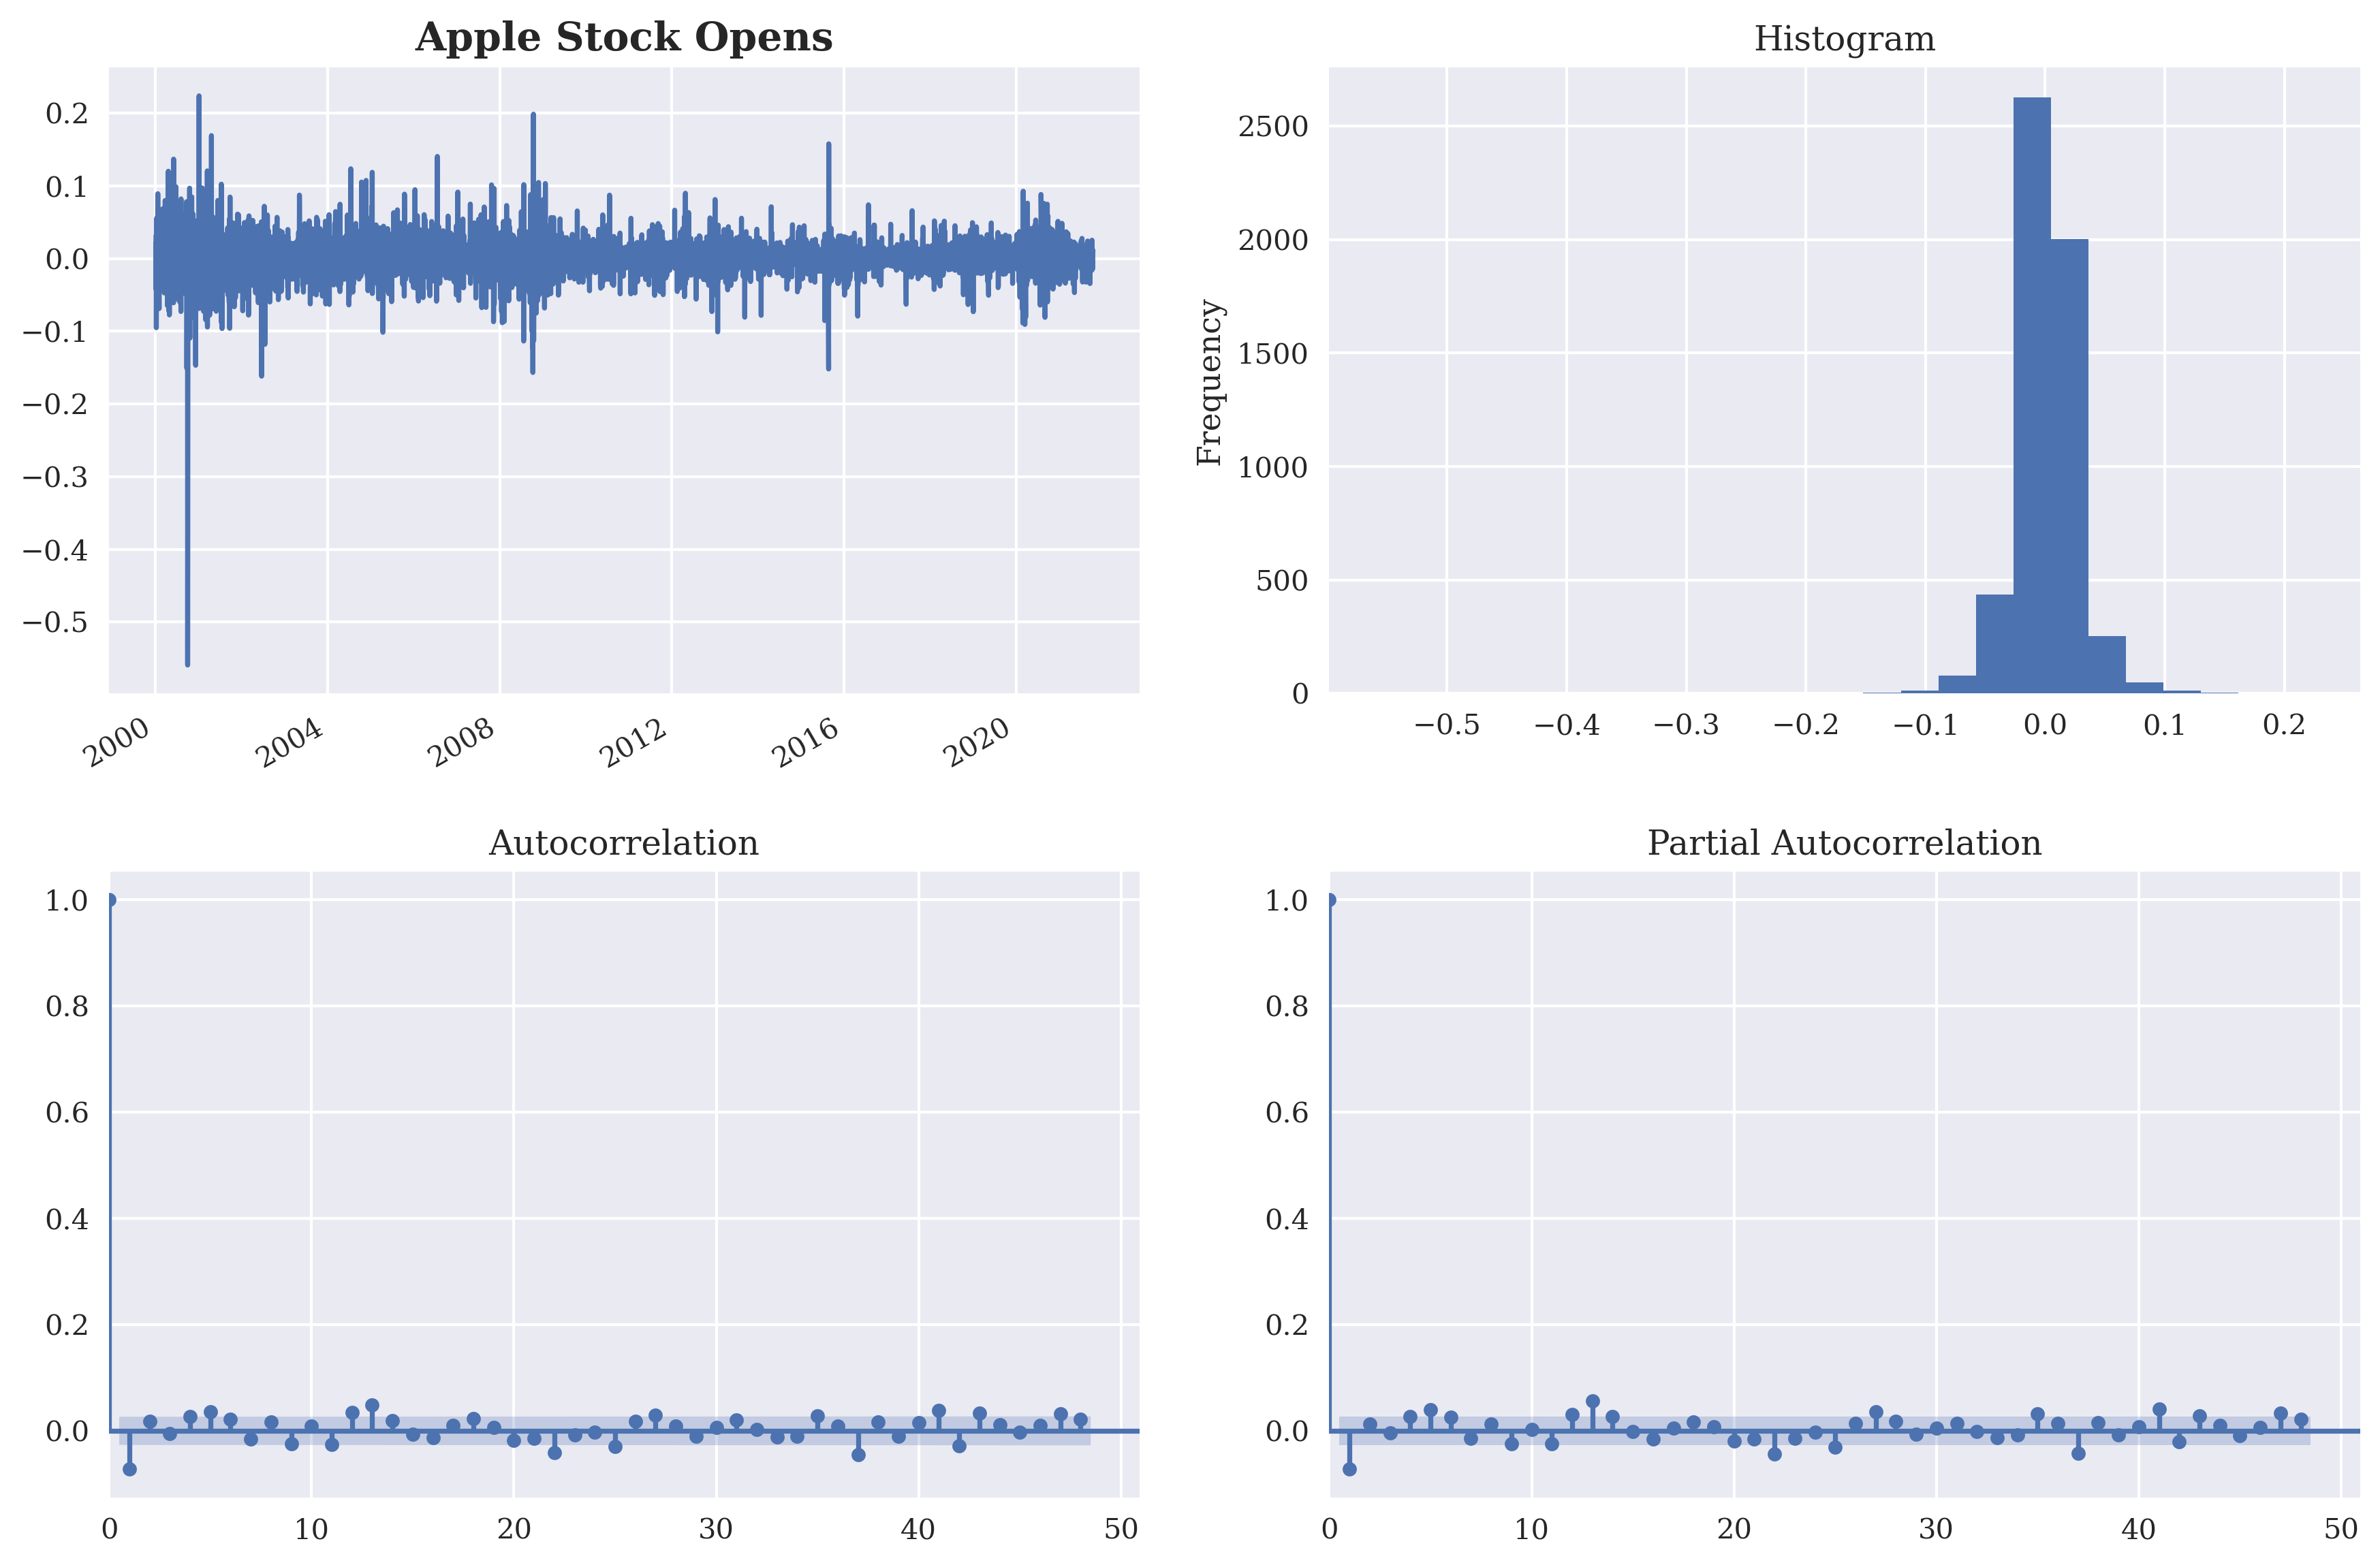

In [306]:
tsplot(np.log(sp500['AAPL_open'].div(sp500['AAPL_open'].shift(1))).dropna(),title = "Apple Stock Opens",lags = 48)

(<AxesSubplot:title={'center':'Apple Stock Intraday Spread'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

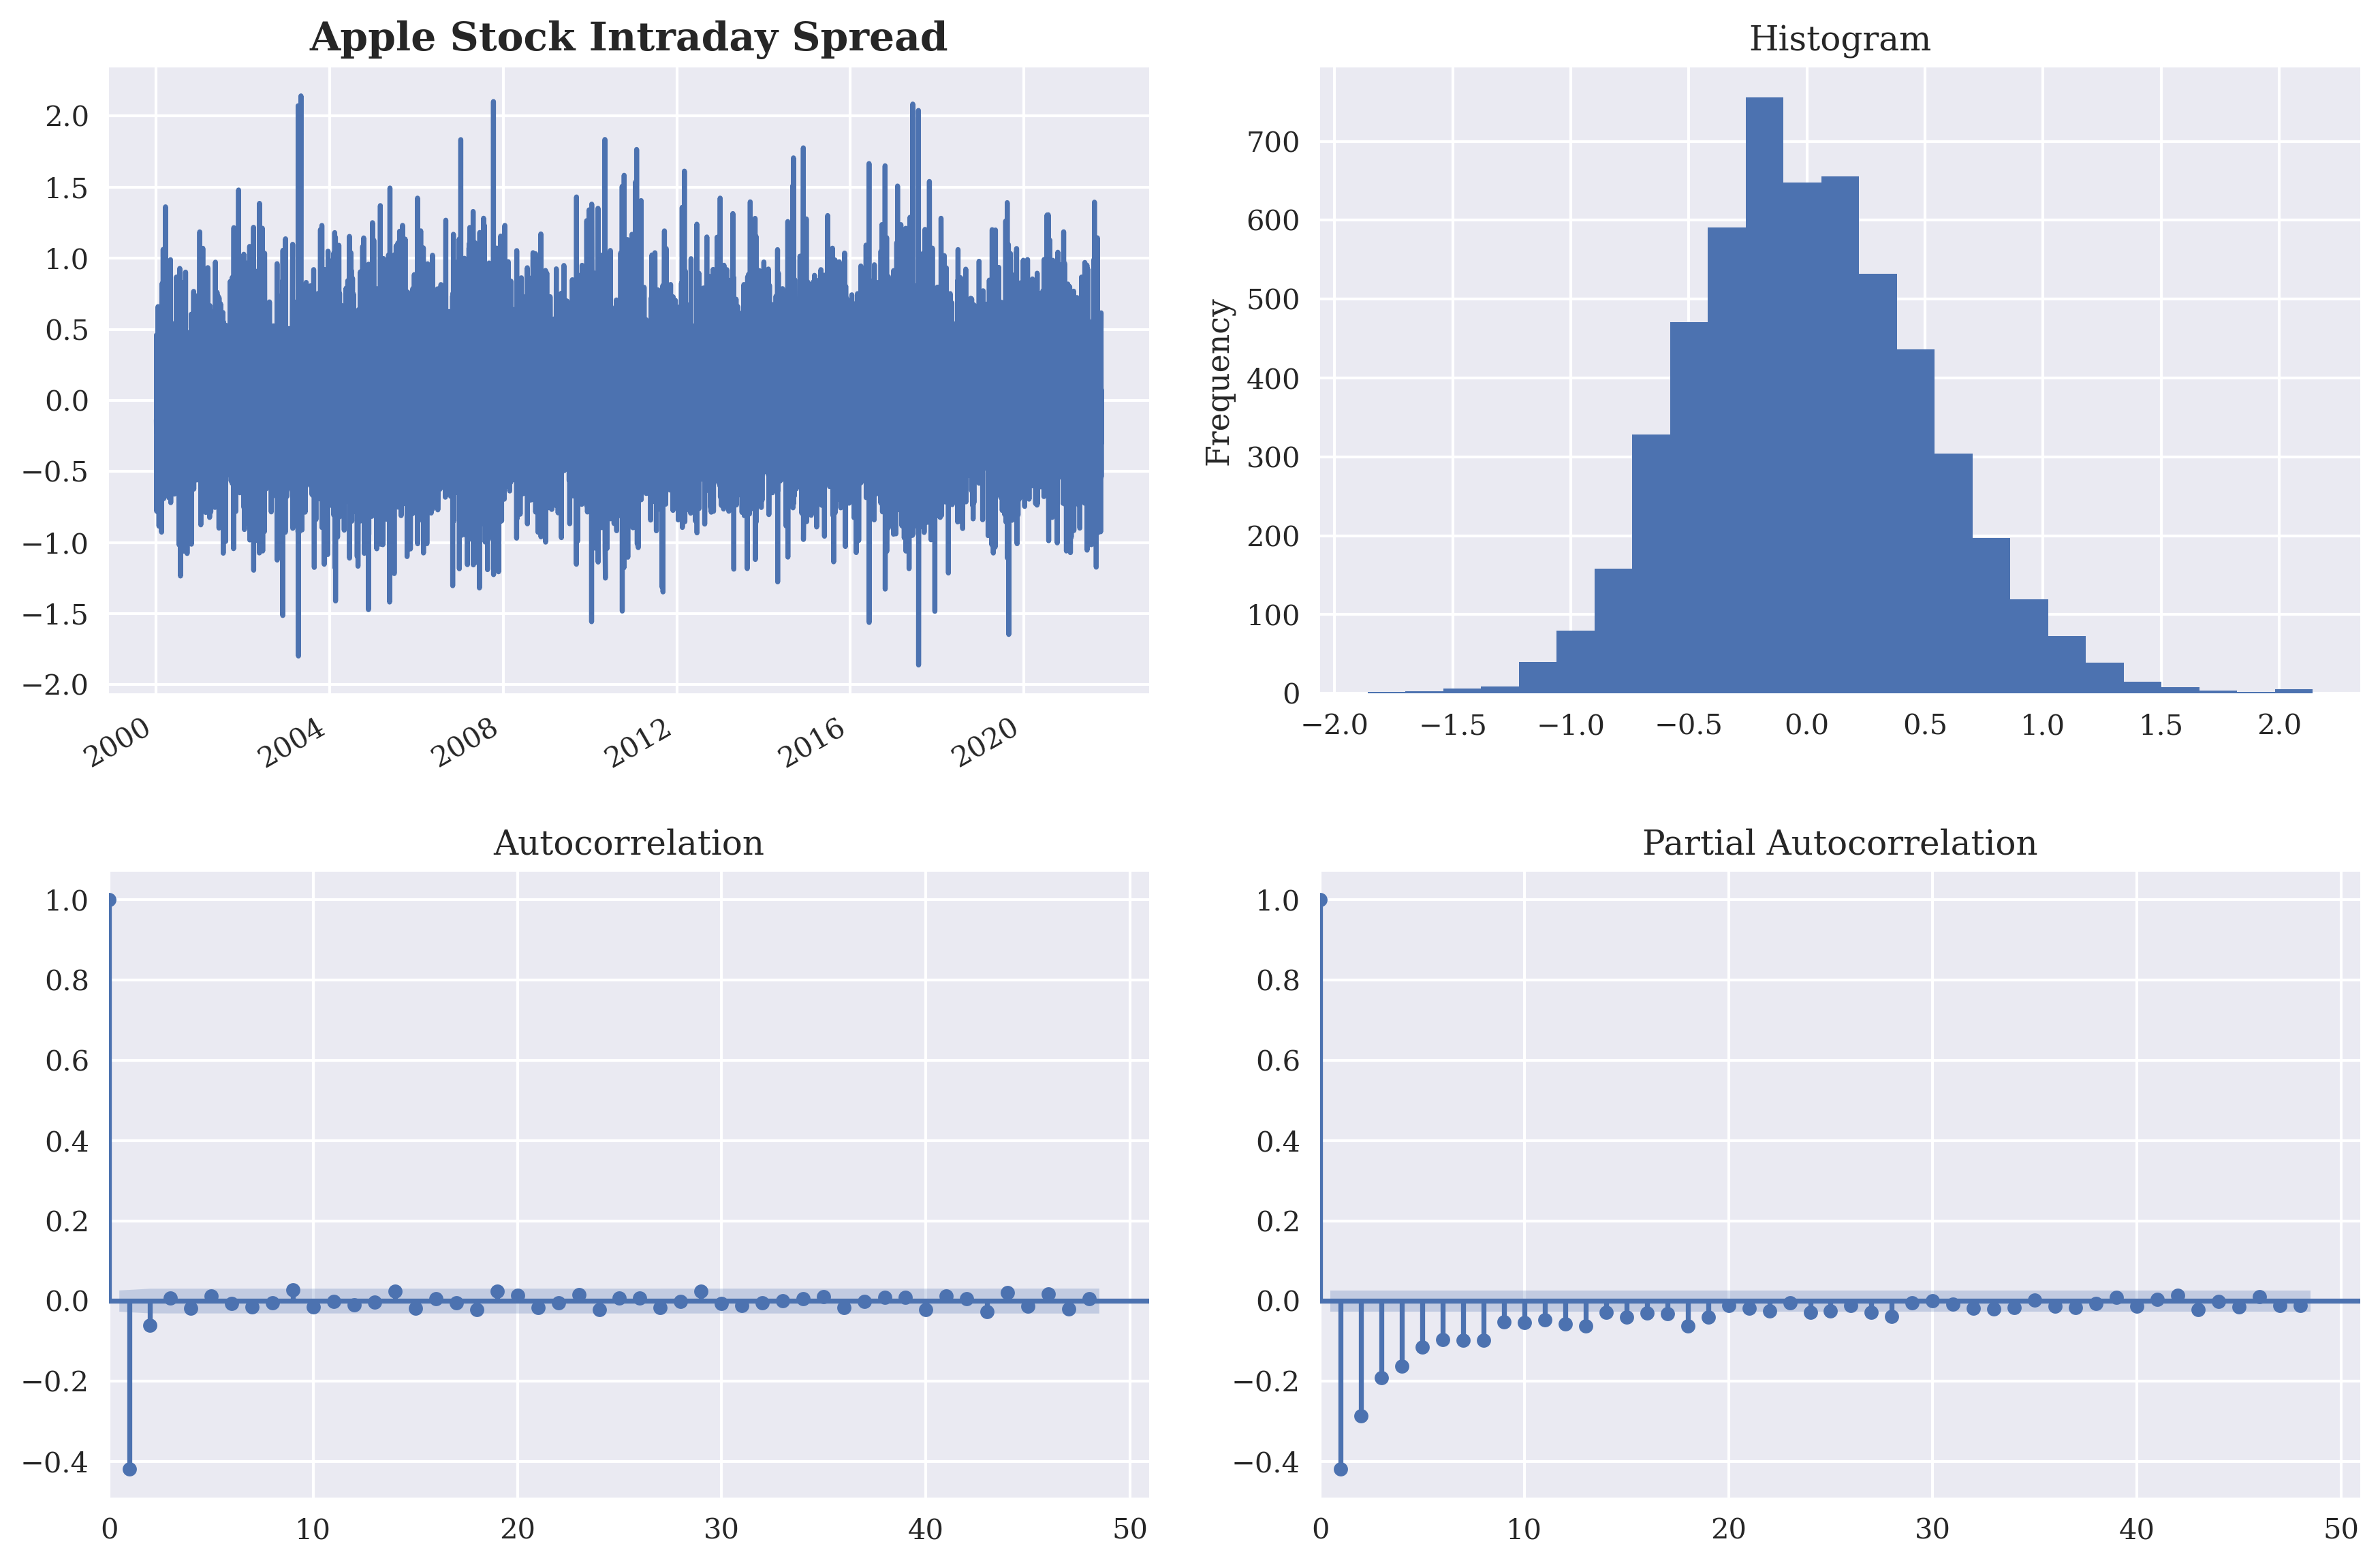

In [307]:
tsplot(np.log(sp500['AAPL_intraday_spread'].div(sp500['AAPL_intraday_spread'].shift(1))).dropna(),
       title = "Apple Stock Intraday Spread",lags = 48)



(<AxesSubplot:title={'center':'Apple Stock Volume Traded'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

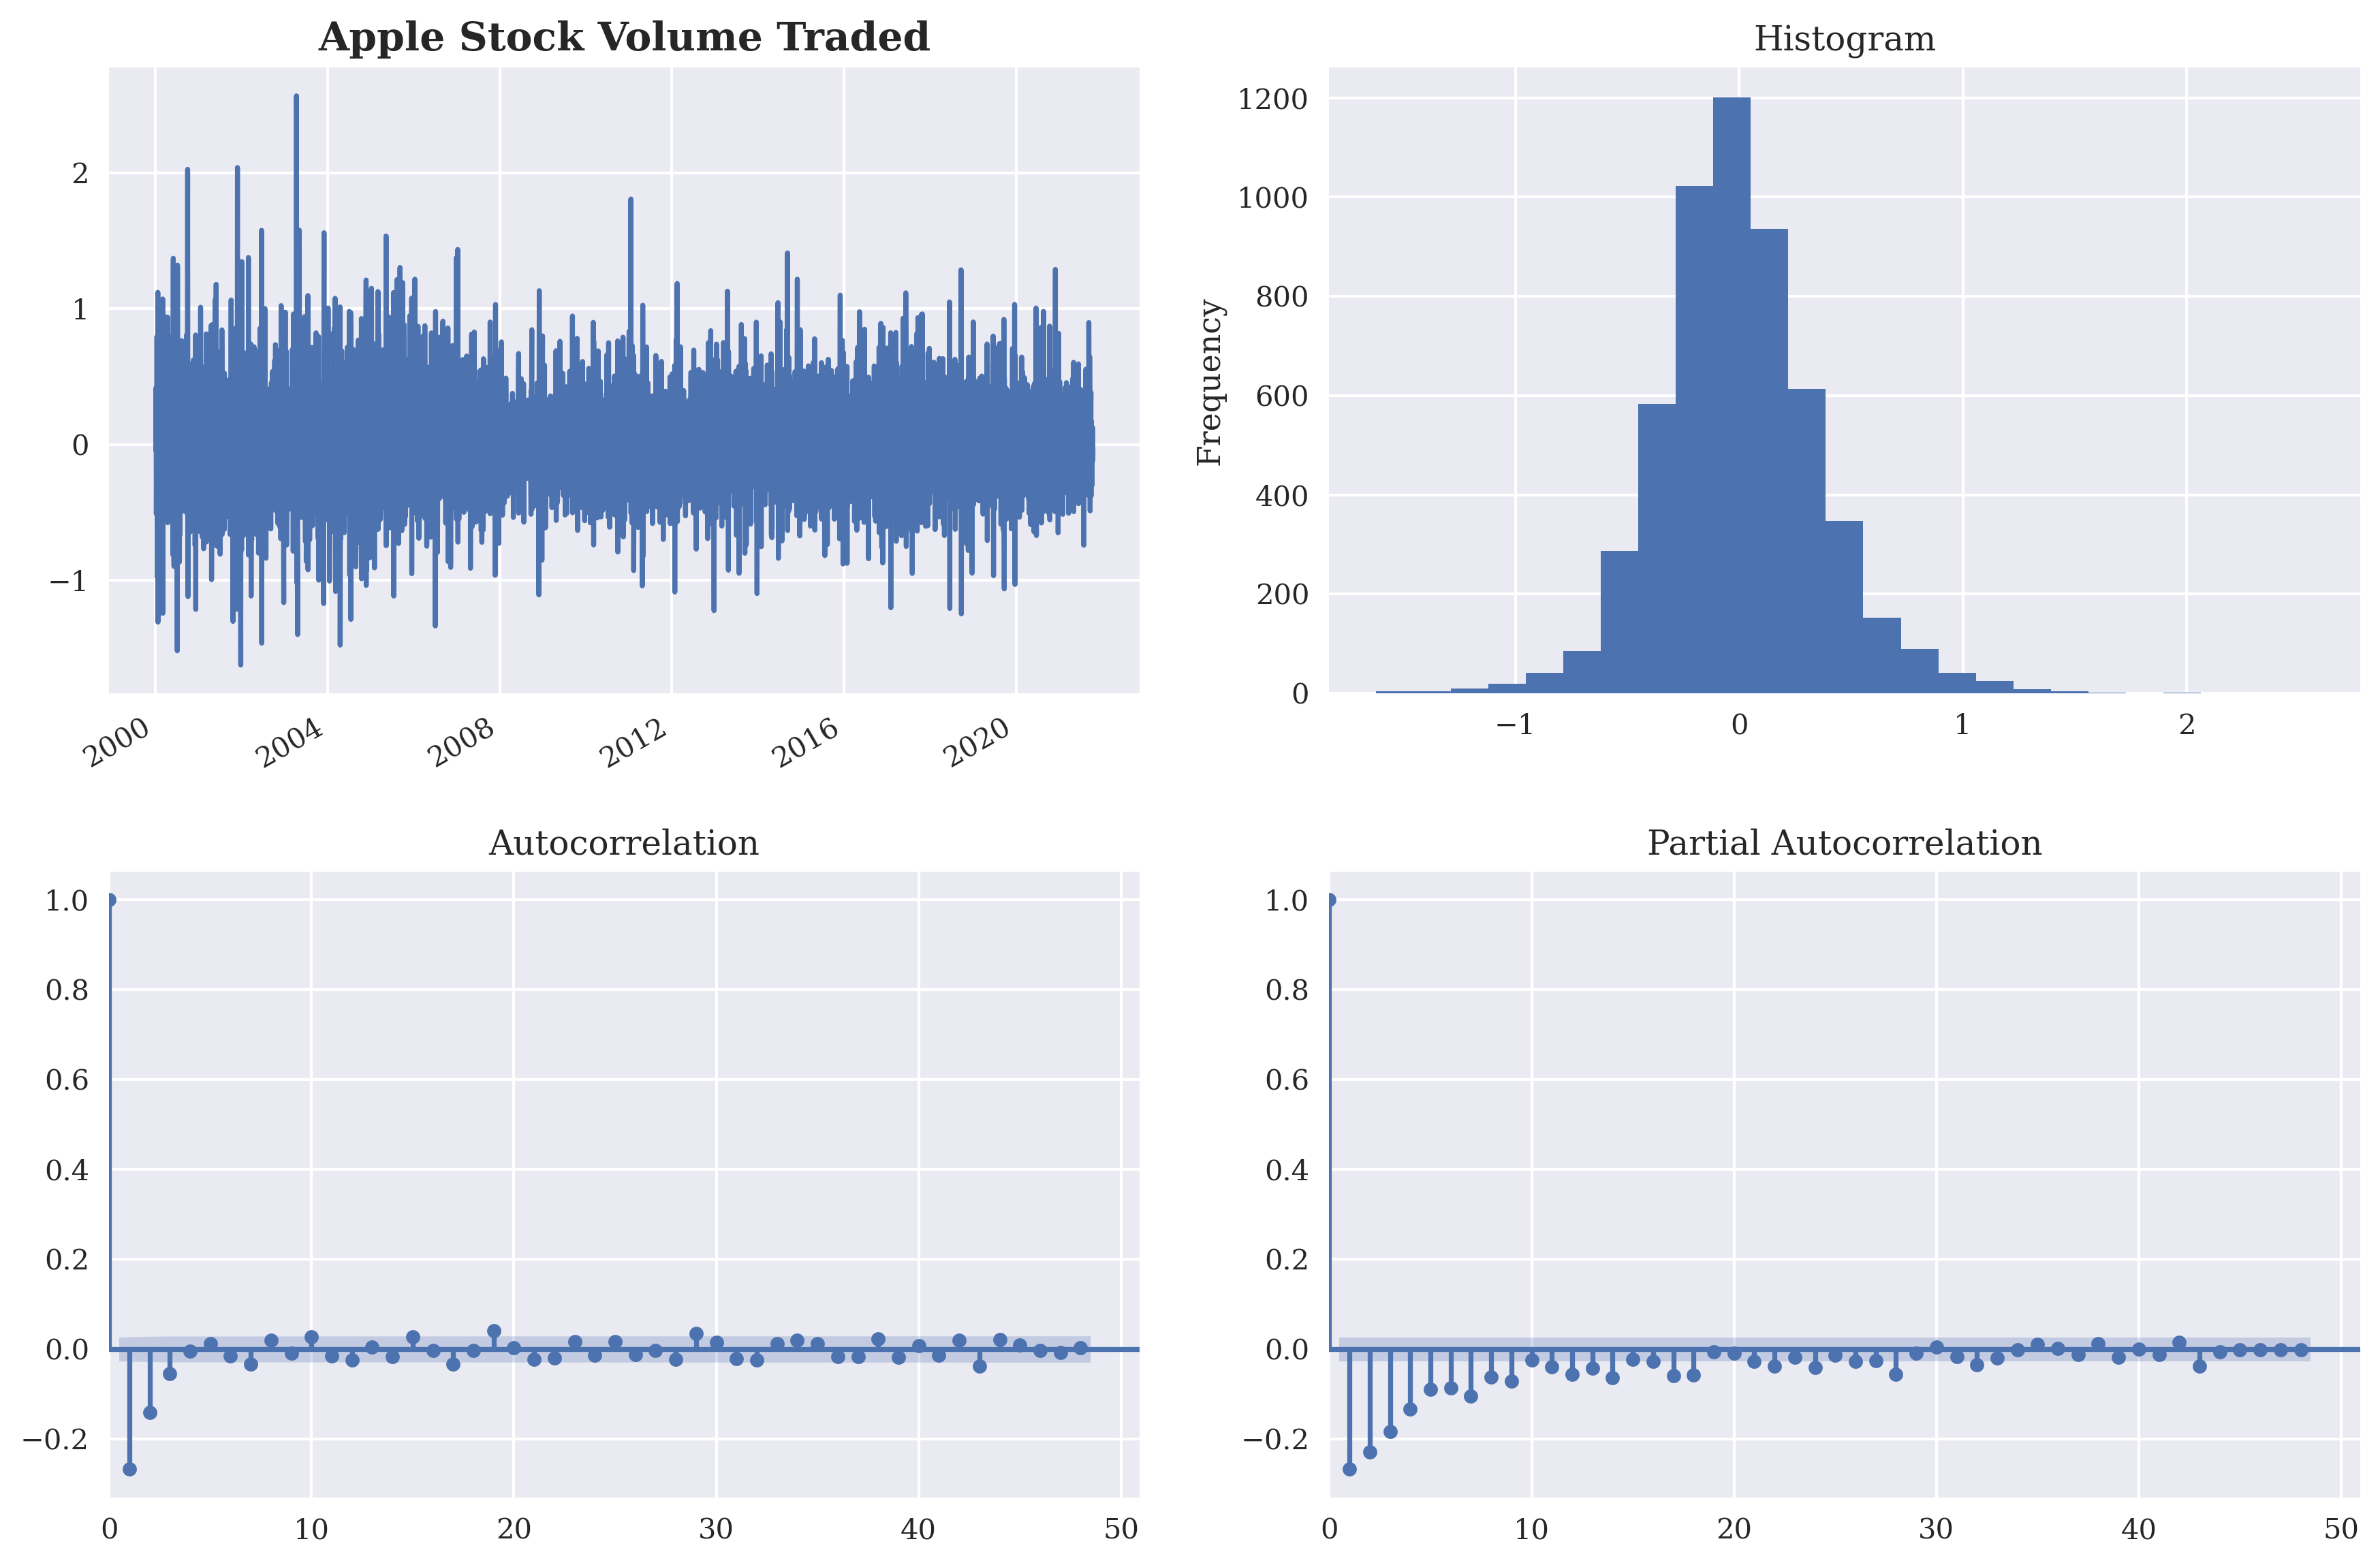

In [308]:
tsplot(np.log(sp500['AAPL_volume'].div(sp500['AAPL_volume'].shift(1))).dropna(),title = "Apple Stock Volume Traded",lags = 48)

In [309]:
# add transformed stationary columns for all the stocks
for col in sp500.columns:
    if 'open' in col or 'volume' in col or 'high' in col or 'low' in col or 'intraday_spread' in col:
        sp500[f"{col}_transformed"] = np.log(sp500[col].div(sp500[col].shift(1)))

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [310]:
sp500.shape

(5483, 6060)

In [311]:
sp500.head()

MMM_high   MMM_low  MMM_open  MMM_volume  MMM_adj_close  \
2000-01-03  48.25000  47.03125  48.03125   2173400.0      27.179523   
2000-01-04  47.40625  45.31250  46.43750   2713800.0      26.099533   
2000-01-05  48.12500  45.56250  45.56250   3699400.0      26.855530   
2000-01-06  51.25000  47.15625  47.15625   5975800.0      29.015484   
2000-01-07  51.90625  49.96875  50.56250   4101200.0      29.591490   

             ABT_high    ABT_low   ABT_open  ABT_volume  ABT_adj_close  ...  \
2000-01-03  16.160433  15.599306  15.823756  10635087.0       9.418211  ...   
2000-01-04  15.599306  15.150405  15.459024  10734887.0       9.149117  ...   
2000-01-05  15.402911  15.066236  15.066236  11722632.0       9.132297  ...   
2000-01-06  15.823756  15.178461  15.262630  17479583.0       9.451843  ...   
2000-01-07  16.272657  15.487080  15.487080  15756040.0       9.552754  ...   

            XEL_intraday_spread_transformed  XLNX_intraday_spread_transformed  \
2000-01-03                              NaN                               NaN   
2000-01-04                        -0.318454                          0.061875   
2000-01-05                         0.405465                          0.095310   
2000-01-06                        -0.875469                          0.018019   
2000-01-07                        -0.916291                          0.292136   

            XOM_intraday_spread_transformed  XRAY_intraday_spread_transformed  \
2000-01-03                              NaN                               NaN   
2000-01-04                        -0.532805                         -0.606137   
2000-01-05                         0.847298                          0.510829   
2000-01-06                         0.356675                         -0.105364   
2000-01-07                        -0.916291                          0.510826   

            XYL_intraday_spread_transformed  YUM_intraday_spread_transformed  \
2000-01-03                              NaN                              NaN   
2000-01-04                              NaN                         0.000005   
2000-01-05                              NaN                        -1.386305   
2000-01-06                              NaN                         0.154151   
2000-01-07                              NaN                         0.944471   

            ZBH_intraday_spread_transformed  ZBRA_intraday_spread_transformed  \
2000-01-03                              NaN                               NaN   
2000-01-04                              NaN                          0.572520   
2000-01-05                              NaN                         -0.262365   
2000-01-06                              NaN                         -0.418043   
2000-01-07                              NaN                         -0.149941   

            ZION_intraday_spread_transformed  ZTS_intraday_spread_transformed  
2000-01-03                               NaN                              NaN  
2000-01-04                         -0.821980                              NaN  
2000-01-05                         -0.133531                              NaN  
2000-01-06                          0.158224                              NaN  
2000-01-07                         -1.005522                              NaN  

[5 rows x 6060 columns]

### Another Variable to Consider: Stock returns 10 day rolling volatility

(<AxesSubplot:title={'center':'Apple Stock Volatility'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

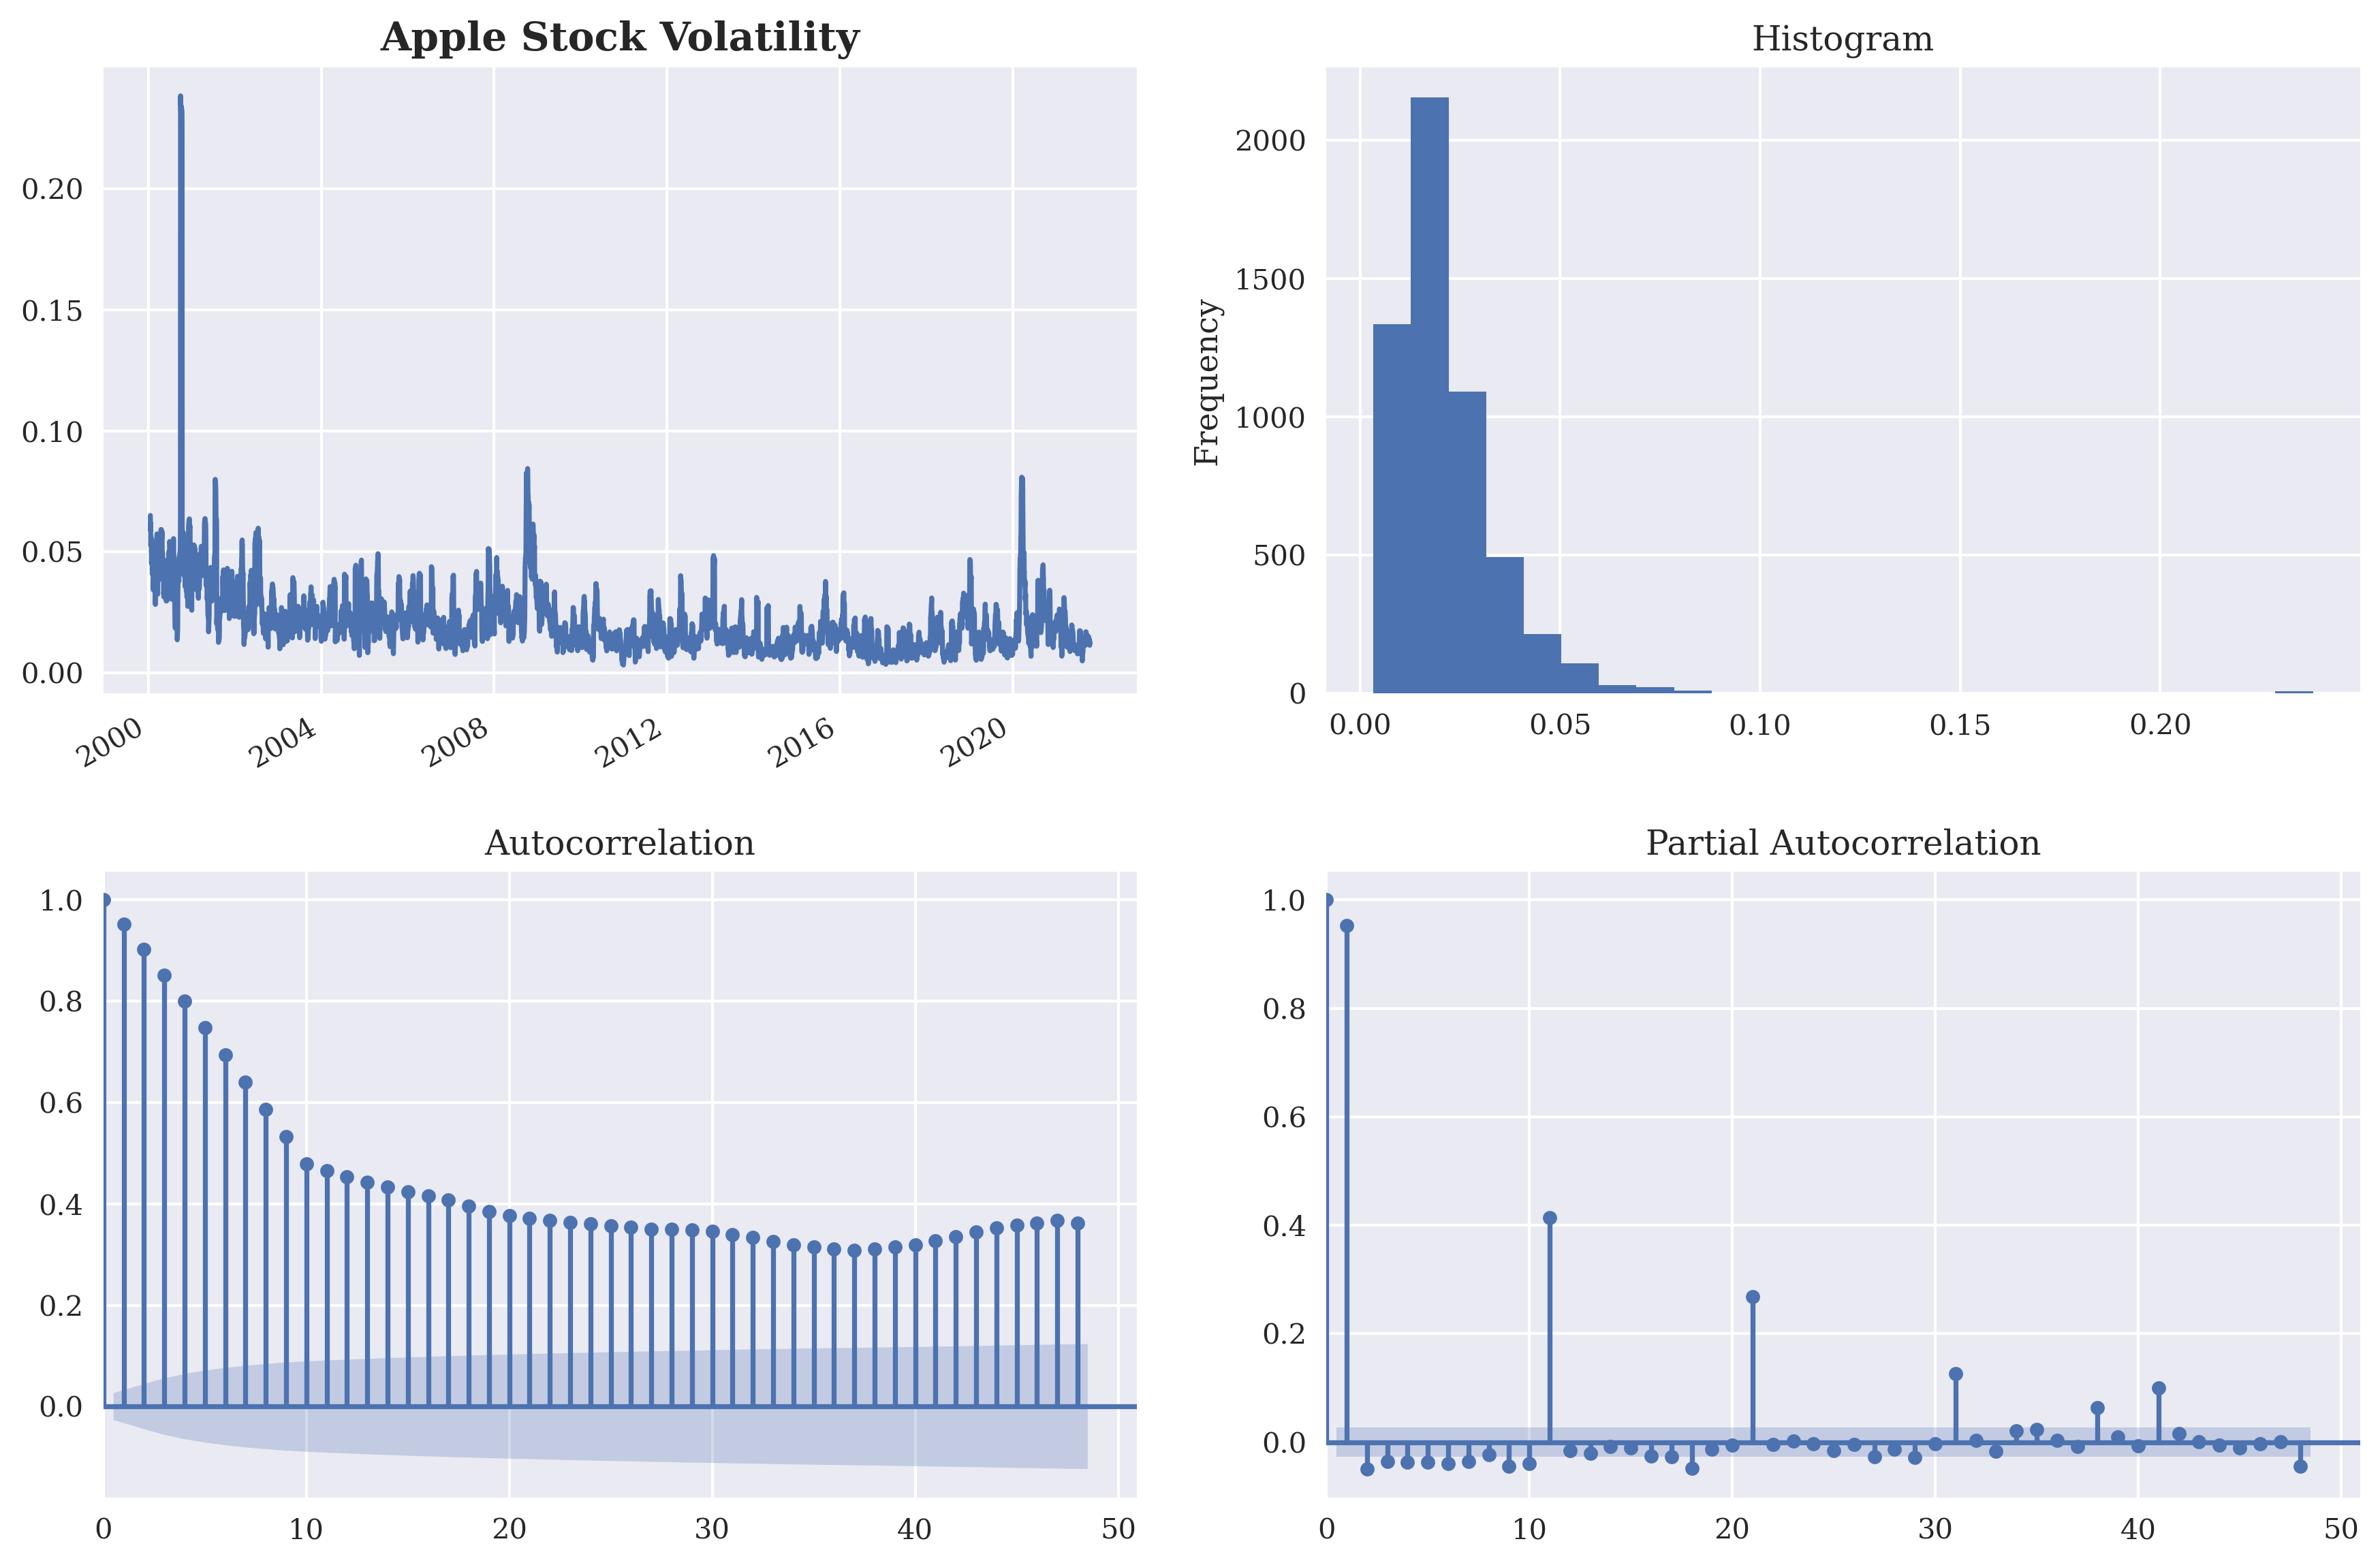

In [324]:
# looks like an autoregressive process
tsplot(sp500['AAPL_returns'].rolling(window = 10).std().dropna(),title = "Apple Stock Volatility",lags = 48)

In [325]:
# add volatility columns for all the stocks
for col in sp500.columns:
    if 'returns' in col:
        sp500[f"{col.split('_')[0]}_volatility"] = sp500[col].rolling(window = 10).std()

# Creating a Target Variable and Preparing our Data for the LSTM

Now that we've added some relevant variables to our data, we can begin working on preparing our target variable and our data for the LSTM network. 

Our target variable is going to be comprised of buy, sell, and hold signals. We want to buy the stock at time $t$ if there is an increase in the stock's future price of 7% or more; we want to sell the stock at time $t$ if there is a decrease in the stock's future price of 5% or more. Thus we have a 2% margin.

Currently, our data is stored in a Pandas DataFrame object. However, LSTM's do not take Pandas Data Frames as input. Instead, they take arrays of data. Therefore, we have to transform our data into that format to run it through our LSTM network and generate predictions.

In [395]:
# length of preceeding data used in generating predictions
sequence_length = 20 
# number of periods into the future that we are trying to predict
periods_ahead = 5 
target_stock = 'AAPL' # Let's try investing in Apple

In [506]:
def classify_target_variable(current, future):
    # if price increases more than 5%, buy
    if (float(future) - float(current))/float(current) >= 0.05: 
        return 1
    # if price drops more than 3%, sell
    if (float(future) - float(current))/float(current) <= -0.03:
        return -1
    # otherwise, hold
    else:  
        return 0

In [507]:
def add_target_to_df(df,target_stock):
    df['future'] = df[f'{target_stock}_adj_close'].shift(-periods_ahead)
    df['target'] = list(map(classify_target_variable, df[f'{target_stock}_adj_close'], 
                             df['future']))
    df = df.drop(['future'],axis = 1)
    return df

In [508]:
from sklearn.preprocessing import StandardScaler

def preprocess_data(df):
    """
    Drop columns with too many NA values;
    Scale the data (except for the target column);
    
    
    Parameters
    - df: a dataframe
    """
    # fill forward NA values
    df = df.ffill() 
    
    # identify columns with too many NAs
    # drop them from the dataframe
    col_NAs = {col:df[col].isna().sum() for col in df.columns}
    bad_cols = []
    for col, num_NAs in col_NAs.items():
        if col_NAs[col] > 500:
            bad_cols.append(col)   
    df = df.drop(bad_cols,axis = 1)
    
    # replace infinites with NAs
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # fill forward again, just in case
    df = df.ffill() 
    df = df.dropna(axis = 0) # drop all the remaining rows with NA values from the dataframe
    
    return df

In [ ]:
def scale_data(df):
    count = 0
    # scale our data
    for col in df.columns:  
        if col != 'target':
            # standardize each feature 
            df[col] = preprocessing.scale(df[col].values)
            # remove any accidental NAs created by pct_change
            df.dropna(inplace=True) 
            count +=1
            if count % 200 == 0:
                print(f'Progress: {count}/{len(df)}')

    df = df.dropna(axis = 0) # just in case
    return df

In [509]:
sp500_new = add_target_to_df(sp500,target_stock)
sp500_clean = preprocess_data(sp500_new)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [ ]:
sp500_clean.head(3)

In [ ]:
sp500_clean = scale_data(sp500_clean)

In [513]:
sp500_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
sp500_clean = sp500_clean.ffill() 
sp500_clean = sp500_clean.dropna(axis = 0)
sp500.shape

(5483, 6567)

In [510]:
sp500_clean.head(3)

MMM_high   MMM_low  MMM_open  MMM_volume  MMM_adj_close  ABT_high  \
2001-12-28 -1.136769 -1.122284 -1.126826   -0.687358      -1.108477 -0.578926   
2001-12-31 -1.139094 -1.133071 -1.127606    0.066724      -1.118029 -0.585474   
2002-01-02 -1.157792 -1.153175 -1.155764    0.517583      -1.124005 -0.593198   

             ABT_low  ABT_open  ABT_volume  ABT_adj_close  ...  \
2001-12-28 -0.574070 -0.571275   -1.029554      -0.700476  ...   
2001-12-31 -0.580401 -0.580596   -0.906593      -0.707719  ...   
2002-01-02 -0.594602 -0.599239   -0.378864      -0.706826  ...   

            WHR_volatility  WMB_volatility  WLTW_volatility  XEL_volatility  \
2001-12-28       -0.715396        0.869287        -0.301044        0.118205   
2001-12-31       -0.711400        0.874530        -0.307146        0.044813   
2002-01-02       -0.662455        0.693163        -0.333998       -0.013909   

            XLNX_volatility  YUM_volatility  ZBRA_volatility  ZBH_volatility  \
2001-12-28         1.670758        0.033571         0.880069       -0.376212   
2001-12-31         1.890896       -0.268349         0.888646       -0.072280   
2002-01-02         2.192472       -0.706783         0.729199       -0.227024   

            ZION_volatility  target  
2001-12-28        -0.516245       0  
2001-12-31        -0.523355       0  
2002-01-02        -0.417010      -1  

[3 rows x 5097 columns]

In [514]:
# save our clean dataframe
with open('sp500_clean','wb') as f:
    pickle.dump(sp500_clean,f)  

In [496]:
# read saved data frame
with open('sp500_clean','rb') as f:
    sp500_clean = pickle.load(f)

In [516]:
def ts_to_supervised(df):
    
    # list containing sequences of data
    sequential_data = []  
    
    # the sequences of data that we're going to gradually
    # add to our sequential_data list
    previous_days = deque(maxlen=sequence_length)  

    # iterate over the values of each column
    for i in df.values:  
        # store all values except for the target variable
        previous_days.append([n for n in i[:-1]])  
        if len(previous_days) == sequence_length:  
            sequential_data.append([np.array(previous_days), i[-1]]) 

    random.shuffle(sequential_data)  # shuffle for good measure.

    buys = []  # list that will store our buy sequences and targets
    sells = []  # list that will store our sell sequences and targets

    for seq, target in sequential_data:  
        if target == 1:  
            buys.append([seq, target])  
        elif target == -1:  
            sells.append([seq, 0])  

    random.shuffle(buys)  
    random.shuffle(sells)  

    lower = min(len(buys), len(sells))  
    
    # make sure both lists are only as long as the shortest length of the other
    # so that we do not introduce bias into our LSTM network
    buys = buys[:lower]  
    sells = sells[:lower]  

    # add the buys and sells together
    sequential_data = buys+sells  # add them together
    
    # another shuffle, so the model doesn't get confused with all one class then the other
    random.shuffle(sequential_data)  

    X = []
    y = []
    
    for seq, target in sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.array(X), y

## Create Train-Test Split

In [518]:
dates = sorted(sp500_clean.index.values)
split_date = (sp500_clean.index[-int(len(dates)*0.25)])

df_val = sp500_clean[sp500_clean.index >= split_date]
df_train = sp500_clean[sp500_clean.index < split_date]

In [519]:
X_train, y_train = ts_to_supervised(df_train)

In [520]:
X_val, y_val = ts_to_supervised(df_val)

In [521]:
print(f"train data: {len(X_train)} validation: {len(X_val)}")
print(f"Dont buys: {y_train.count(0)}, buys: {y_train.count(1)}")
print(f"VALIDATION Dont buys: {y_val.count(0)}, buys: {y_val.count(1)}")

train data: 1262 validation: 236
Dont buys: 631, buys: 631
VALIDATION Dont buys: 118, buys: 118


In [504]:
X_train.shape

(956, 20, 5096)

# Building the LSTM network

In [505]:
epochs = 50  
batch_size = 32
name = f"{sequence_length}-seq-{periods_ahead}-predictions-{int(time.time())}"

In [ ]:
model = Sequential()
model.add(CuDNNLSTM(128, input_shape=(X_train.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
# Normalise activation outputs
model.add(BatchNormalization())  

model.add(CuDNNLSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(CuDNNLSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

In [ ]:
# model compile settings
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

In [ ]:
# Train model
history = model.fit(
    X_train, np.asarray(y_train),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, np.asarray(y_val)),
    #callbacks=[tensorboard, checkpoint],
)

In [ ]:
# Score model
score = model.evaluate(X_val, np.asarray(y_val), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Old

In [ ]:
# standardise our columns to have mean 0, variance 1
from sklearn.preprocessing import StandardScaler 

# LSTM needs scaled data
def scale(train,test):
    scaler = StandardScaler()
    scaler = scaler.fit(train)
    
    # scale the training series
    train = train.reshape(train.shape[0],train.shape[1])
    train_scaled = scaler.transform(train)
    
    # scale the test series
    # NOTE: we use the training data's 
    # mean and standard deviation to scale our testing data too
    test = test.reshape(test.shape[0],test.shape[1])
    test_scaled = scaler.transform(test)
    
    return scaler, train_scaled, test_scaled

In [220]:
def ts_to_supervised(data,lags = 1):
    """
    Return the data in a series format that the LSTM can use, and the new dataframe with lags
    
    Parameters
    - data: a dataframe
    - lags: number of lags observed for our data
    """
    df = pd.DataFrame(data)
    columns = pd.DataFrame([df.shift(i) for i in range(1,lags+1)][0])
    columns.columns = [f'{col}_1' for col in columns.columns]
    columns = [columns]
    columns.append(df)
    df = pd.concat(columns,axis = 1)
    
    # fill forward NA values
    df = df.ffill() 
    
    # identify columns with too many NAs
    # drop them from the dataframe
    col_NAs = {col:df[col].isna().sum() for col in df.columns}
    
    bad_cols = []
    for col, num_NAs in col_NAs.items():
        if col_NAs[col] > 500:
            bad_cols.append(col)
            
    df = df.drop(bad_cols,axis = 1)
    
    # fill forward NA values again, just in case
    df = df.ffill() 
    df = df.dropna() # drop all the remaining rows with NA values from the dataframe
    series_values = df.values
    return series_values, df